# Снижение энергопотребления на металлургическом комбинате

## Введение

**Цель проекта:**  
Разработать модель, способную предсказывать конечную температуру плавки.

**Задачи проекта:**
1. Проанализировать предоставленные данные.
2. Подготовить данные, обработав аномальные значения и подготовив новые признаки.
3. Составить модели для обучения, среди которых дерево решений, градиентный бустинг и нейросети.
4. Интерпретировать работу модели, выявив наиболее значимые признаки.

**План проекта:**
1. Загрузить данные из базы данных.
2. Сделать анализ данных.
3. Обработать аномальные значения.
4. Добавить новые признаки.
5. Составить и обучить модели.
6. Проанализировать модели.
7. Сделать выводы по итогам работы.

**Описание работы**  

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Разработанная модель необходима для имитации технологического процесса.  

Процесс обработки  

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.
Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.  

Прежде чем в первый раз ввести легирующие добавки, персонал предприятия производит химический анализ стали и измеряет её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.  

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).  

Описание данных  
Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
* steel.data_arc — данные об электродах;
* steel.data_bulk — данные об объёме сыпучих материалов;
* steel.data_bulk_time — данные о времени подачи сыпучих материалов;
* steel.data_gas — данные о продувке сплава газом;
* steel.data_temp — данные об измерениях температуры;
* steel.data_wire — данные об объёме проволочных материалов;
* steel.data_wire_time — данные о времени подачи проволочных материалов.  

Таблица steel.data_arc  

* key — номер партии;
* BeginHeat — время начала нагрева;
* EndHeat — время окончания нагрева;
* ActivePower — значение активной мощности;
* ReactivePower — значение реактивной мощности.  

Таблица steel.data_bulk
* key — номер партии;
* Bulk1 … Bulk15 — объём подаваемого материала.  

Таблица steel.data_bulk_time
* key — номер партии;
* Bulk1 … Bulk15 — время подачи материала.  

Таблица steel.data_gas
* key — номер партии;
* gas — объём подаваемого газа.  

Таблица steel.data_temp
* key — номер партии;
* MesaureTime — время замера;
* Temperature — значение температуры.  

Таблица steel.data_wire
* key — номер партии;
* Wire1 … Wire9 — объём подаваемых проволочных материалов.  

Таблица steel.data_wire_time
* key — номер партии;
* Wire1 … Wire9 — время подачи проволочных материалов.  

В таблицах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Загрузка данных

Выполним подключение к базе

In [ ]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-03-04 14:35:54--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.62’

ds-plus-final.db.62 100%[===================>]   3.42M  --.-KB/s    in 0.1s    

2025-03-04 14:35:54 (22.8 MB/s) - ‘ds-plus-final.db.62’ saved [3588096/3588096]



### Установка библиотек

In [ ]:
!pip install phik -q
!pip install catboost -q
!pip install --upgrade seaborn
!pip install --upgrade scikit-learn

     |████████████████████████████████| 294 kB 974 kB/s eta 0:00:01
     |████████████████████████████████| 8.3 MB 13.7 MB/s eta 0:00:01
     |████████████████████████████████| 321 kB 88.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.6 MB 97.1 MB/s eta 0:00:01
     |████████████████████████████████| 19.5 MB 29.6 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.1
    Uninstalling numpy-1.21.1:
      Successfully uninstalled numpy-1.21.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.3.4
    Uninstalling matplotlib-3.3.4:
      Successfully uninstalled matplotlib-3.3.4
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sc

### Библиотеки

In [ ]:
# Библиотеки для работы с базой
import os
from sqlalchemy import create_engine

# Стандартные библиотеки
import pandas as pd
import numpy as np

# Библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns


# Библиотеки для анализа данных
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px

# Библиотеки для работы с моделями
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.tree import DecisionTreeRegressor

# Библиотеки бустингов
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Библиотеки для нейросети
import torch
import torch.nn as nn
from math import ceil


### Функции

In [ ]:
def lunge_analysis(df, columns):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, ax=ax[0], bins=30)
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax[0].tick_params(axis='x', rotation=45)
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        ax[1].tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

In [ ]:
def create_binary_flags(df, columns):
    """
    Создает бинарные флаги для списка столбцов:
    - 1, если значение не является NaN (значение присутствует)
    - 0, если значение является NaN (значение отсутствует)

    Параметры:
    df: исходный датафрейм
    columns: список столбцов для обработки

    Возвращает:
    pandas.DataFrame: датафрейм с добавленными бинарными флагами
    """
    result_df = df.copy()

    for column in columns:
        if column in df.columns:
            # Создаем новый столбец-флаг с префиксом has_
            flag_column_name = f'has_{column}'

            # Заполняем: 1 если значение не NaN, 0 если NaN
            result_df[flag_column_name] = df[column].notna().astype(int)
        else:
            print(f"Предупреждение: Столбец '{column}' не найден в датафрейме")

    return result_df

### Константы

In [ ]:
RANDOM_STATE = 19022025
TEST_SIZE = 0.25

### Загрузка таблиц

Подключимся к базе и загрузим нужные таблицы

In [ ]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [ ]:
table_list = ['data_arc',
              'data_bulk',
              'data_bulk_time',
              'data_gas',
              'data_temp',
              'data_wire',
              'data_wire_time']

In [ ]:
query = '''
SELECT *
FROM data_arc
LIMIT 5
'''

In [ ]:
dataframes = {}

for table in table_list:
  query = f'''
  SELECT *
  FROM {table}
  '''
  dataframes[table] = pd.read_sql_query(query, con = engine)


Ознакомимся с таблицами

In [ ]:
for table, dataframe in dataframes.items():
    print(f"\nTable: {table}")
    print(dataframe.head())
    print(dataframe.info())
    print('='*50)


Table: data_arc
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  

Таблицы относительно небольшие, поэтому можно сохранить в отдельные переменные.

In [ ]:
data_arc = dataframes['data_arc']
data_bulk = dataframes['data_bulk']
data_bulk_time = dataframes['data_bulk_time']
data_gas = dataframes['data_gas']
data_temp = dataframes['data_temp']
data_wire = dataframes['data_wire']
data_wire_time = dataframes['data_wire_time']

## Анализ данных

### Таблица data_arc

Начнем с таблица data_arc, содержащую информацию о нагреве сплава.

In [ ]:
data_arc.head()

key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691

Переименуем столбцы, чтобы было удобнее работать

In [ ]:
rename_columns = {'Начало нагрева дугой':'heating_start',
                  'Конец нагрева дугой': 'heating_end',
                  'Активная мощность':'active_power',
                  'Реактивная мощность':'reactive_power'}

In [ ]:
data_arc = data_arc.rename(columns=rename_columns)

В таблице нет пропусков. Время определено неверно. Переведем в нужный формат

In [ ]:
date_columns = ['heating_start', 'heating_end']
data_arc[date_columns] = data_arc[date_columns].apply(pd.to_datetime)

In [ ]:
data_arc.head()

key       heating_start         heating_end  active_power  reactive_power
0    1 2019-05-03 11:02:14 2019-05-03 11:06:02      0.305130        0.211253
1    1 2019-05-03 11:07:28 2019-05-03 11:10:33      0.765658        0.477438
2    1 2019-05-03 11:11:44 2019-05-03 11:14:36      0.580313        0.430460
3    1 2019-05-03 11:18:14 2019-05-03 11:24:19      0.518496        0.379979
4    1 2019-05-03 11:26:09 2019-05-03 11:28:37      0.867133        0.643691

In [ ]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   heating_start   14876 non-null  datetime64[ns]
 2   heating_end     14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Столбцы переименованы, тип данных изменен.

Добавим новые признаки, а потом оценим их распределение

Сперва получим данные по времени первого и последнего нагрева для каждой партии

In [ ]:
# Получаем первый нагрев и последний для каждой партии
heating_summary = data_arc.groupby('key').agg({
    'heating_start': 'min',
    'heating_end': 'max'
}).reset_index()

heating_summary = heating_summary.rename(columns={
    'heating_start': 'first_heating_start',
    'heating_end': 'last_heating_end'
})

In [ ]:
# Продолжительность нагрева
data_arc['heating_duration'] = (data_arc['heating_end'] -
                              data_arc['heating_start']).dt.total_seconds()

In [ ]:
# Полная мощность
data_arc['apparent_power'] = np.sqrt(data_arc['active_power']**2 + data_arc['reactive_power']**2)

In [ ]:
# Соотношение мощностей
data_arc['power_ratio'] = data_arc['active_power']/data_arc['reactive_power']

In [ ]:
# Интервал между нагревами
data_arc['interval_between_start'] = (data_arc.groupby('key')['heating_start'].shift(-1) - data_arc['heating_end']).dt.total_seconds()

In [ ]:
# Час старта нагрева
data_arc['hour_heating_start'] = data_arc['heating_start'].dt.hour

In [ ]:
# Час окончания нагрева
data_arc['hour_heating_end'] = data_arc['heating_end'].dt.hour

In [ ]:
# День недели старта нагрева
data_arc['weekday_heating_start'] = data_arc['heating_start'].dt.weekday

In [ ]:
# День недели конца нагрева
data_arc['weekday_heating_end'] = data_arc['heating_end'].dt.weekday

In [ ]:
# Месяц старта нагрева
data_arc['month_heating_start'] = data_arc['heating_start'].dt.month

In [ ]:
# Месяц конца нагрева
data_arc['month_heating_end'] = data_arc['heating_end'].dt.month

In [ ]:
# Категории суток нагрева (день или ночь)
condition = (data_arc['heating_start'].dt.hour >= 22) | (data_arc['heating_start'].dt.hour < 7)
data_arc['day_night'] = np.where(condition, 'ночь', 'день')

In [ ]:
# Потребряемая мощность за секунду нагрева
data_arc['power_per_second'] = data_arc['apparent_power'] / data_arc['heating_duration']

In [ ]:
# Соотношение активной мощности к полной
data_arc['power_factor'] = data_arc['active_power'] / data_arc['apparent_power']

In [ ]:
# Затраченная мощность за время нагрева
data_arc['expended_energy'] = data_arc['apparent_power'] * data_arc['heating_duration']

В столбце reactive power есть явно аномальные значения. Посмотрим на него

In [ ]:
data_arc.loc[data_arc['reactive_power'] < 0]

key       heating_start         heating_end  active_power  \
9780  2116 2019-07-28 02:22:08 2019-07-28 02:23:57      0.705344   

      reactive_power  heating_duration  apparent_power  power_ratio  \
9780     -715.479924             109.0      715.480272    -0.000986   

      interval_between_start  hour_heating_start  hour_heating_end  \
9780                   314.0                   2                 2   

      weekday_heating_start  weekday_heating_end  month_heating_start  \
9780                      6                    6                    7   

      month_heating_end day_night  power_per_second  power_factor  \
9780                  7      ночь          6.564039      0.000986   

      expended_energy  
9780     77987.349613

Как видно, значение ошибочно. Лучше его исключить из общей выборки

In [ ]:
data_arc = data_arc.loc[data_arc['reactive_power'] >= 0]

Построим графики

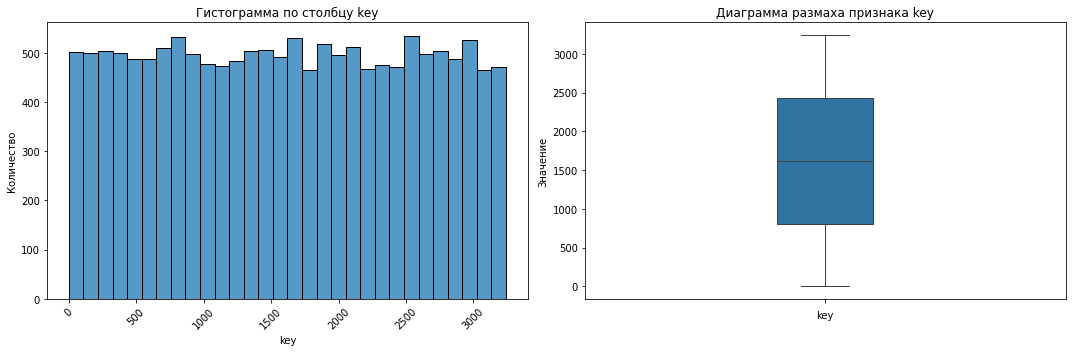

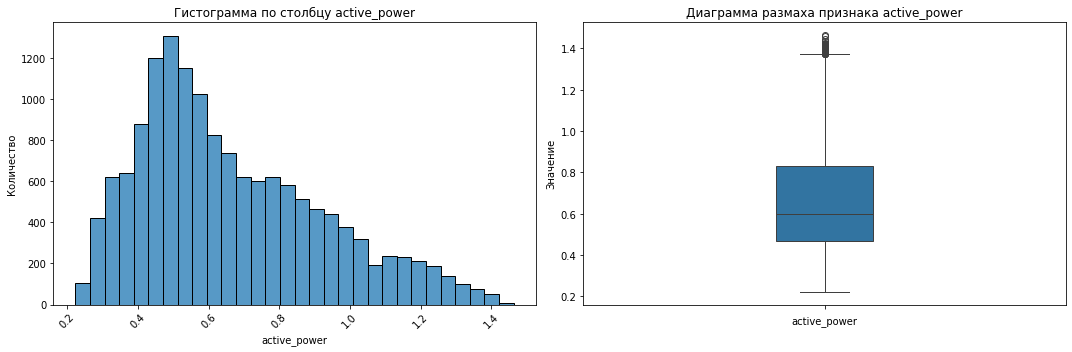

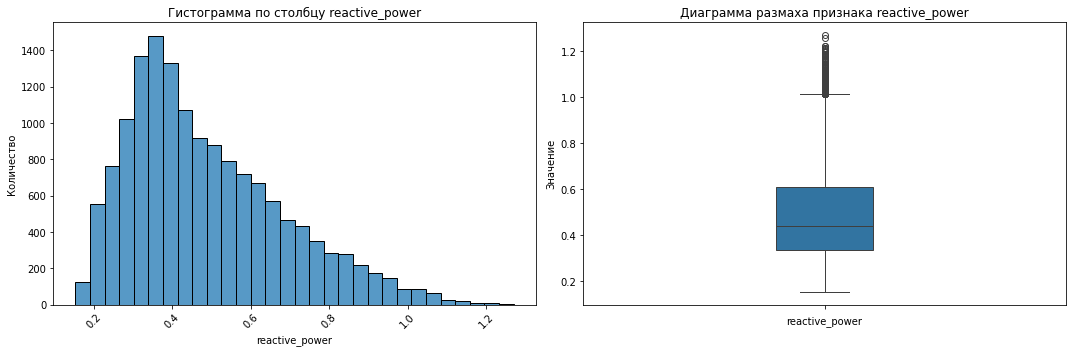

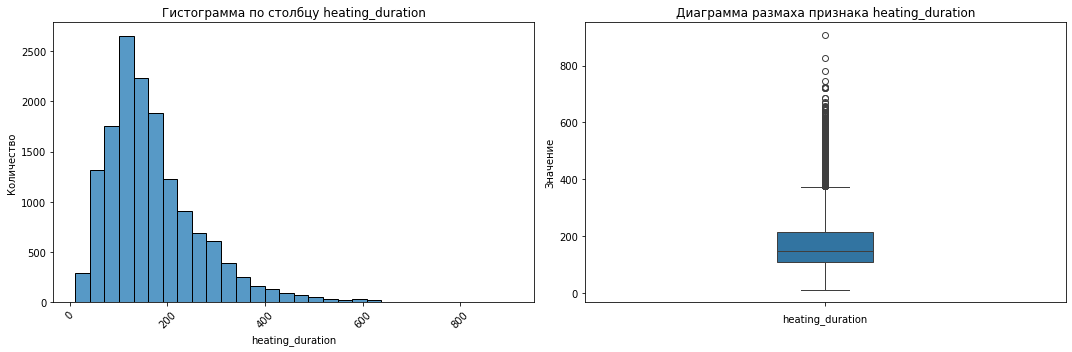

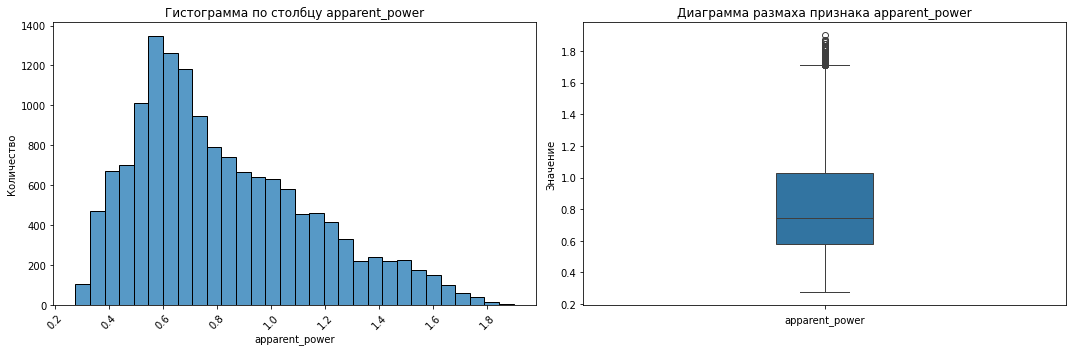

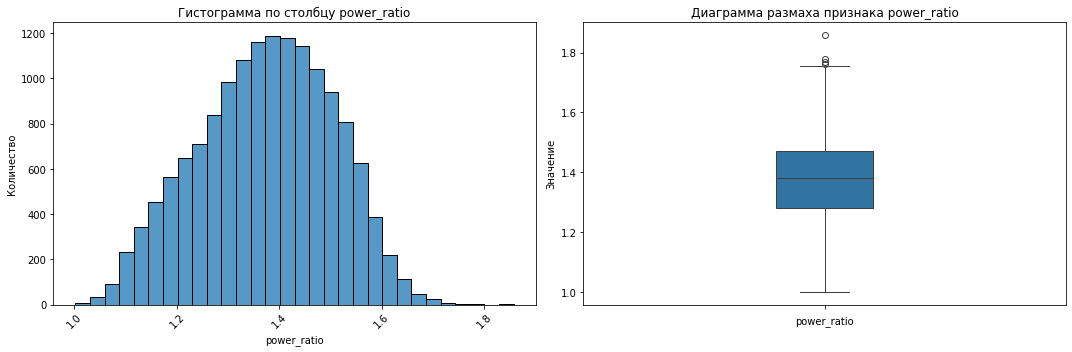

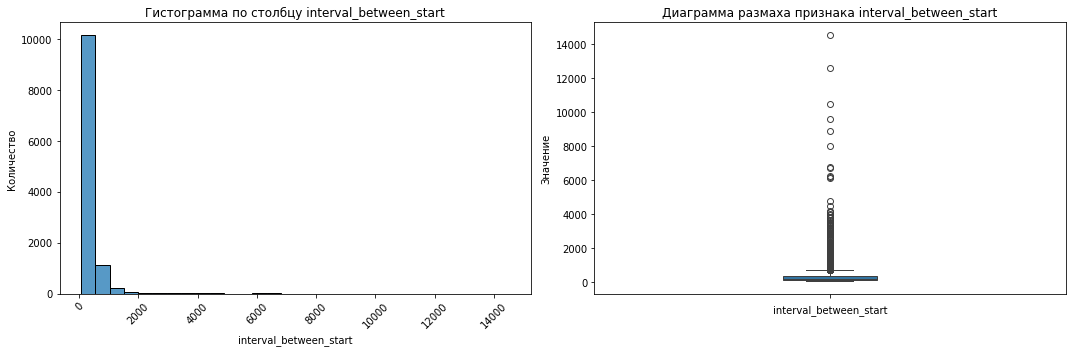

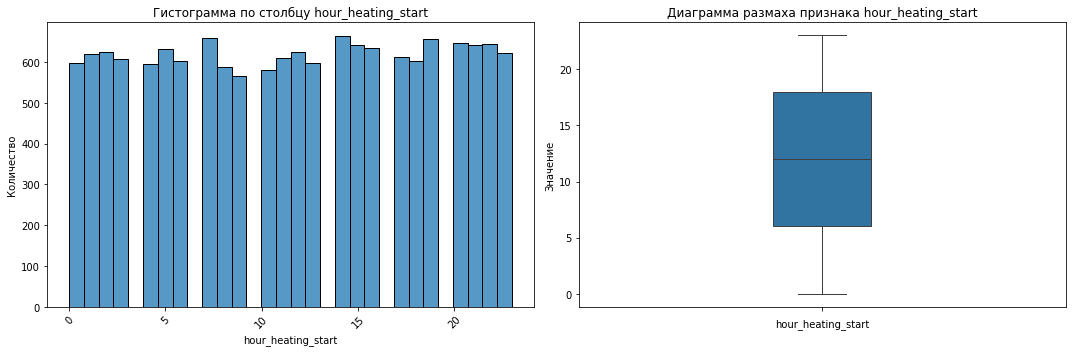

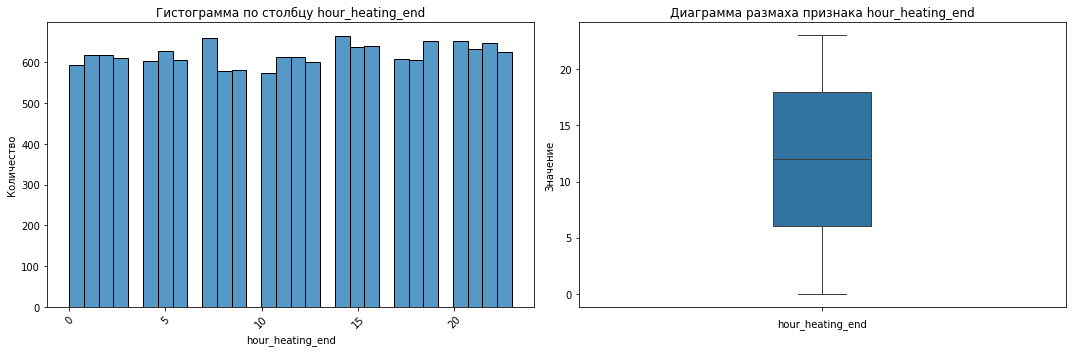

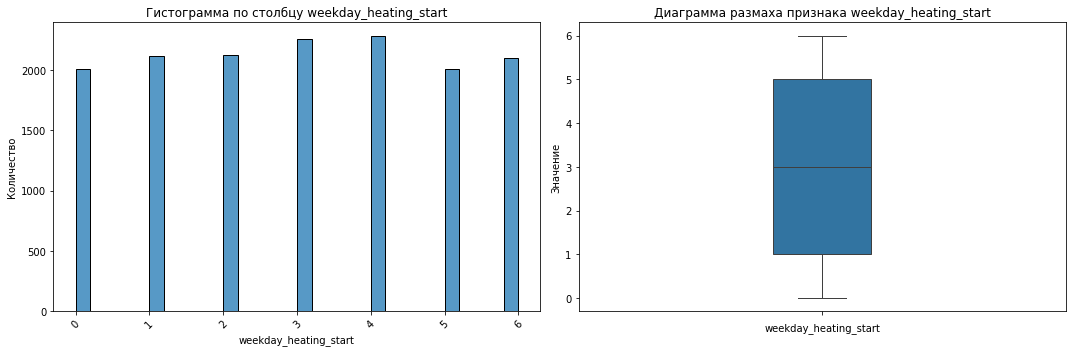

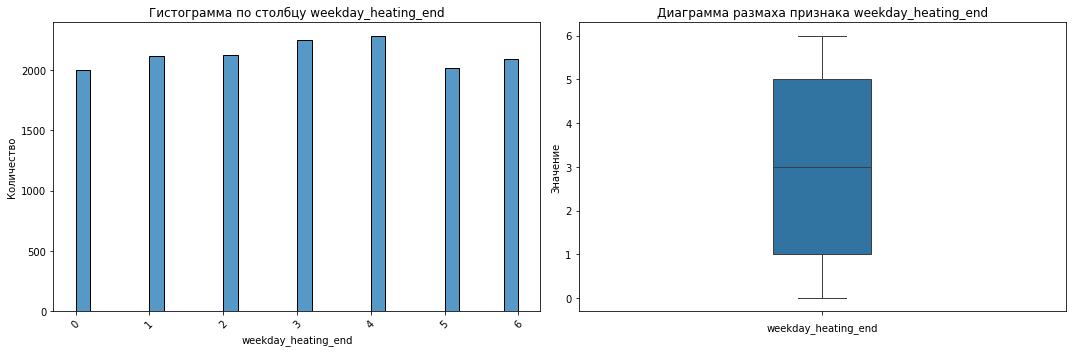

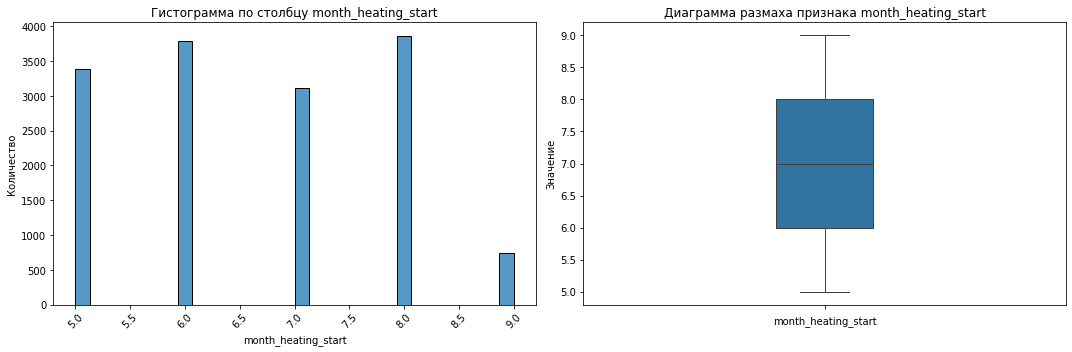

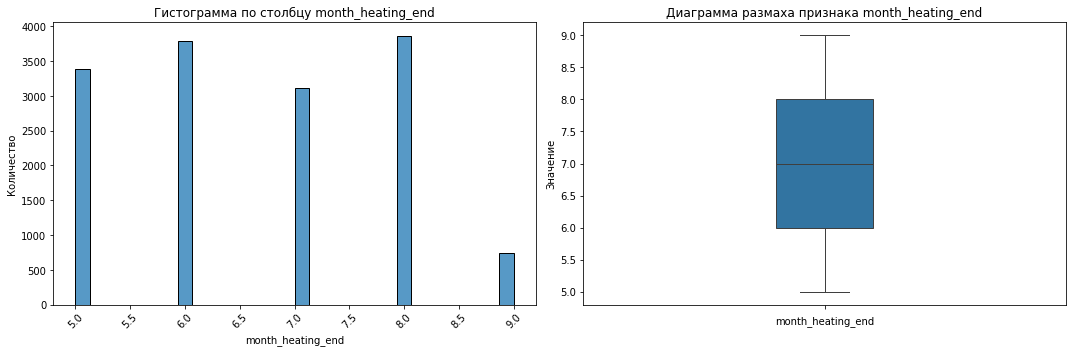

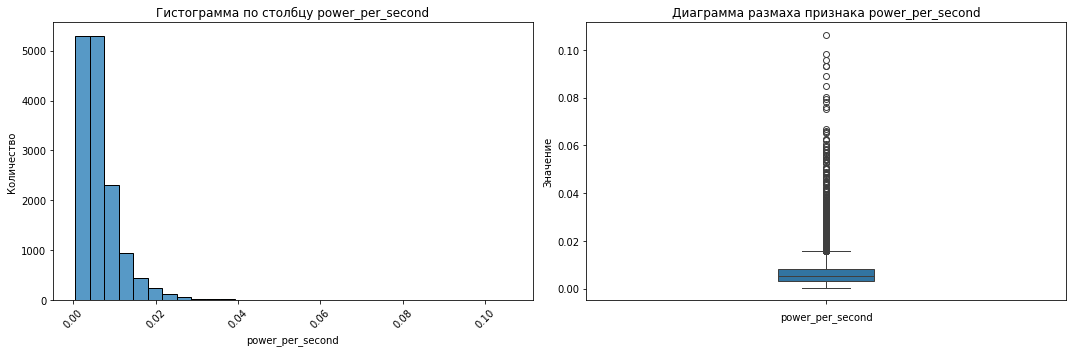

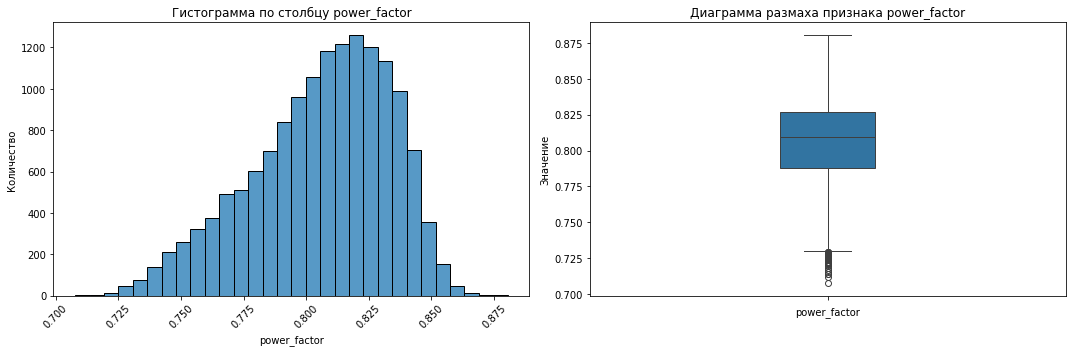

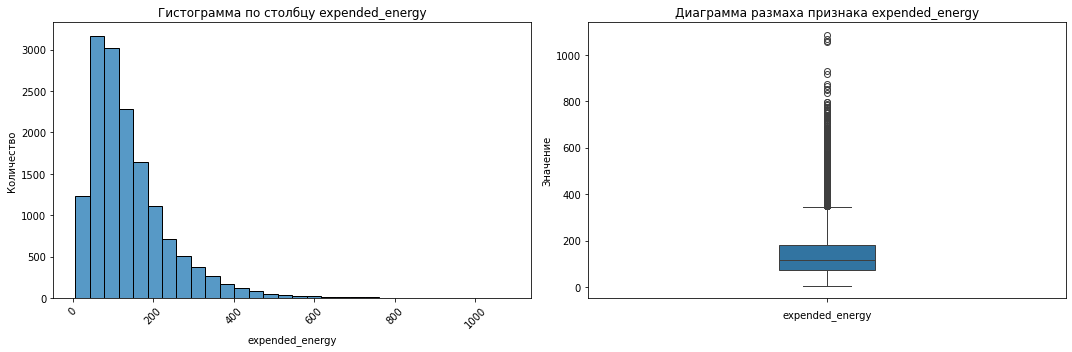

In [ ]:
lunge_analysis(data_arc, data_arc.drop(['heating_start', 'heating_end','day_night'], axis=1).columns)

Из графиков видно:
1. Нет партий, который значительно бы выделились на фоне остальные по количеству упоминаний в датафрейме. Есть, которые упоминаются чаще, но не значительно.
2. Нет сильно выделающийхся дней, когда количество раз включений значительно превышает среднее.
3. Тоже самое про количество выключений.
4. Активная мощность чаще всего составляет примерно 0,5 кВт.
5. Реактивная мощность чаще всего составляет примерно 0,35 кВт.
6. Чаще всего время нагрева составляет 100 секунд, но бывали случаи, когда оно превышло 800 секунд.
7. Полная мощность чаще всего составляет около 0,6 кВт.
8. Соотношение активной мощности в реактивной чаще всего составляет 1,4 кВт.
9. Нет значительных отклонений по времени суток, когда начинается нагрев.
10. Такая же ситуация со времением, когда заканчивается нагрев.
11. Так же нет значительных отклонений по дням недели.
12. Данные предоставлены не за весь год, а только с мая по сентябрь. В сентябре зафиксировано малое количество случаев, но скорее всего это связано с неполной информацией за этот месяц.
13. Преимущественно работа идет днём. Ночью количество записей значительно меньше.
14. Чаще всего мощность составляет 0,01 в секунду, но бывают случаи, когда она доходит до 0,10 в секунду.
15. Чаще всего фактор мощности (отношение активной мощности к полной) составляет 0,820 кВт.
16. Затраченная мощность чаще всего составляет от 50-100 кВт на один случай.


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Мне интересно было изучить твои графики, осмысленный и красочный графический анализ. Найдены очень интересные закономерности)

Остальные выпадающие значения пока удалять не будем.

Сделаем сводную таблицу по партиям и проанализируем её.

In [ ]:
group_key = pd.pivot_table(data_arc,
                          index='key',
                          values=['active_power',
                                 'reactive_power',
                                 'heating_duration',
                                 'apparent_power',
                                 'expended_energy',
                                  'interval_between_start'],
                          aggfunc={'active_power': 'sum',
                                  'reactive_power': 'sum',
                                  'heating_duration': 'sum',
                                  'apparent_power': 'sum',
                                  'expended_energy': 'sum',
                                   'interval_between_start':'sum',
                                  'key': 'count'})

Переименуем двойной столбец

In [ ]:
group_key = group_key.rename(columns={'key':'count_heating'})

Подсоединим таблицу с ранее вычисленным стартом и концом нагрева

In [ ]:
group_key = group_key.merge(heating_summary, on='key', how='left')

In [ ]:
group_key.head()

key  active_power  apparent_power  expended_energy  heating_duration  \
0    1      3.036730        3.718736       770.282114            1098.0   
1    2      2.139408        2.588349       481.760005             811.0   
2    3      4.063641        5.019223       722.837668             655.0   
3    4      2.706489        3.400038       683.455597             741.0   
4    5      2.252950        2.816980       512.169934             869.0   

   interval_between_start  count_heating  reactive_power first_heating_start  \
0                   485.0              5        2.142821 2019-05-03 11:02:14   
1                   333.0              4        1.453357 2019-05-03 11:34:14   
2                   870.0              5        2.937457 2019-05-03 12:06:54   
3                   352.0              4        2.056992 2019-05-03 12:39:37   
4                   493.0              4        1.687991 2019-05-03 13:11:13   

     last_heating_end  
0 2019-05-03 11:28:37  
1 2019-05-03 11:53:18  
2 2019-05-03 12:32:19  
3 2019-05-03 12:57:50  
4 2019-05-03 13:33:55

In [ ]:
group_key.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     3214 non-null   int64         
 1   active_power            3214 non-null   float64       
 2   apparent_power          3214 non-null   float64       
 3   expended_energy         3214 non-null   float64       
 4   heating_duration        3214 non-null   float64       
 5   interval_between_start  3214 non-null   float64       
 6   count_heating           3214 non-null   int64         
 7   reactive_power          3214 non-null   float64       
 8   first_heating_start     3214 non-null   datetime64[ns]
 9   last_heating_end        3214 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int64(2)
memory usage: 276.2 KB


Проанализируем распределения

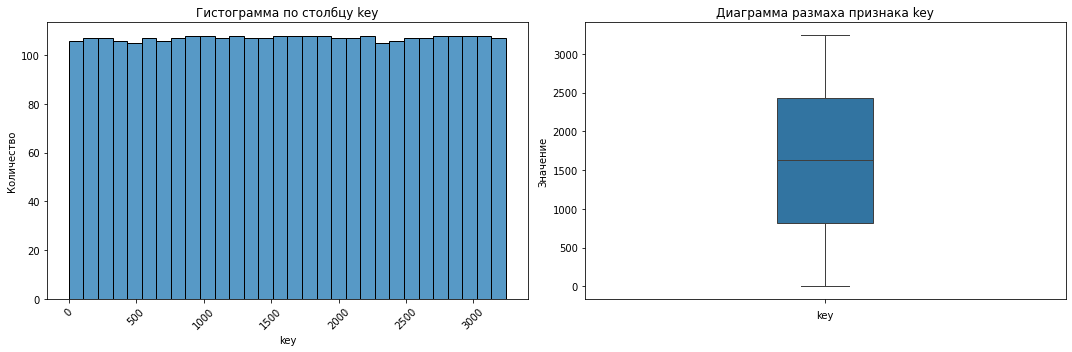

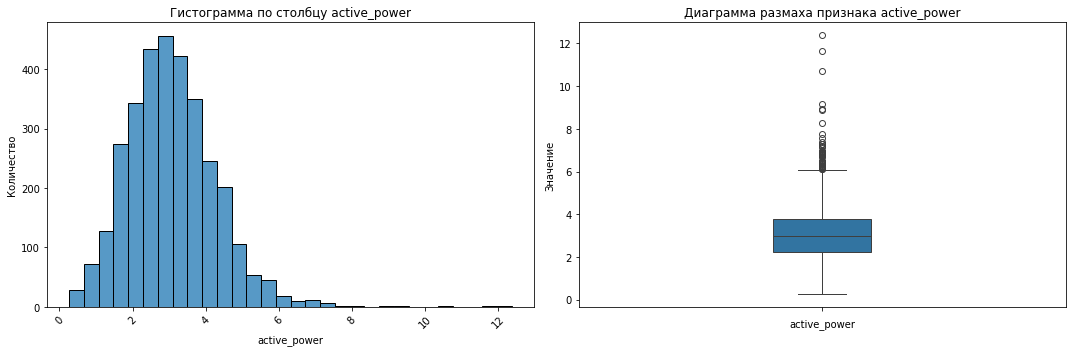

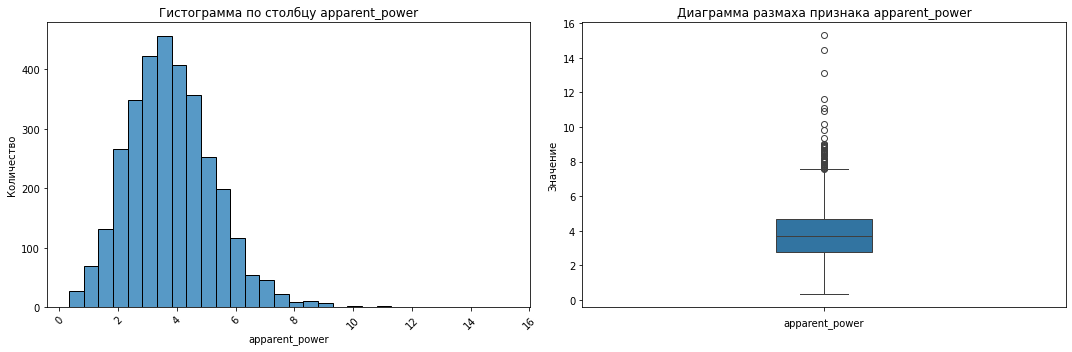

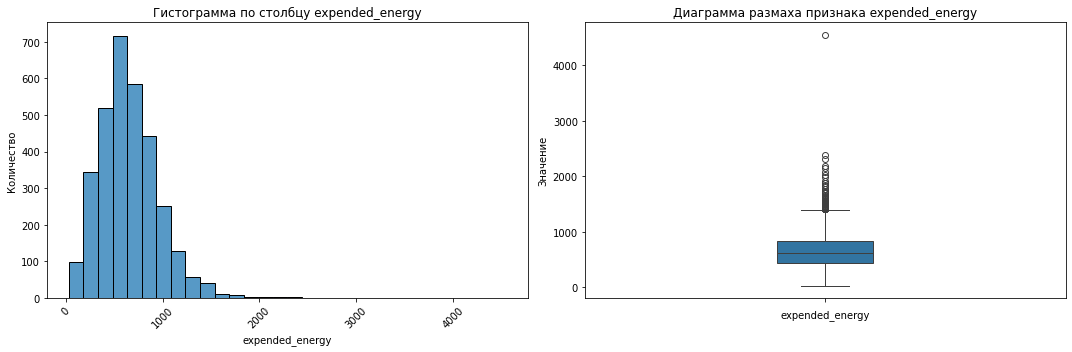

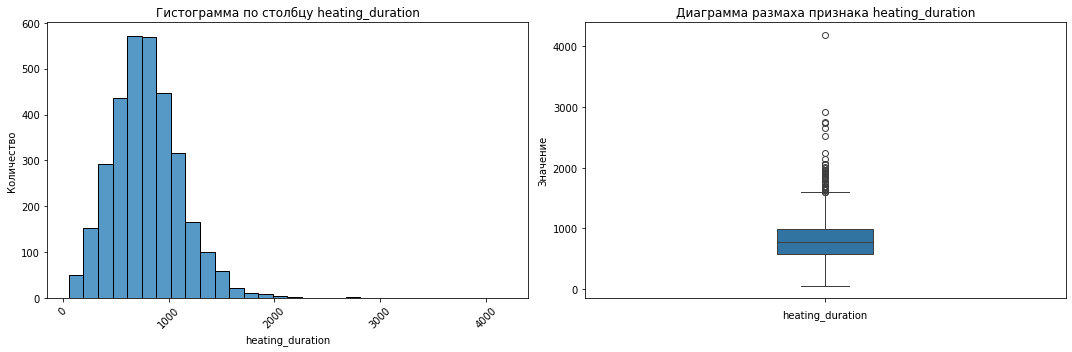

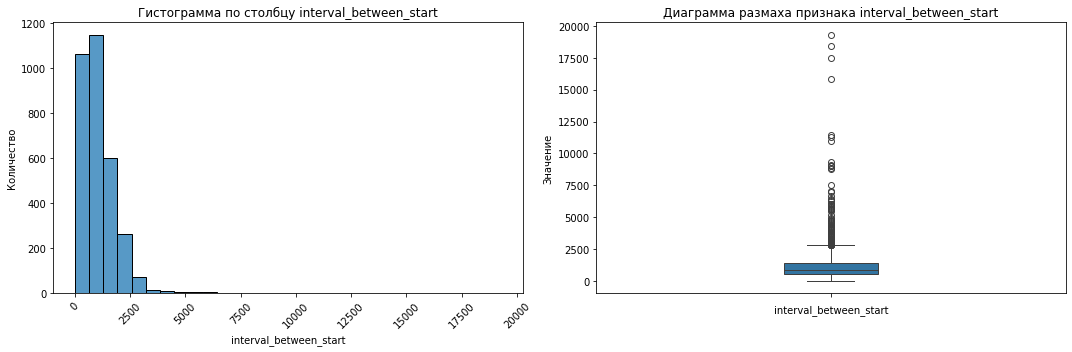

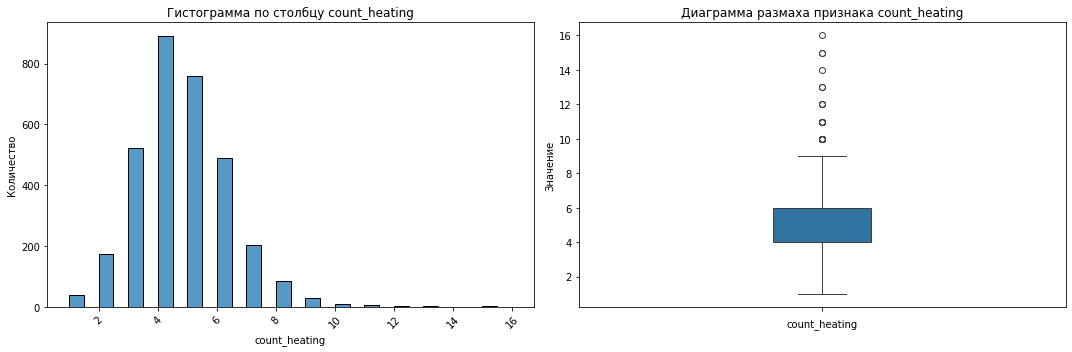

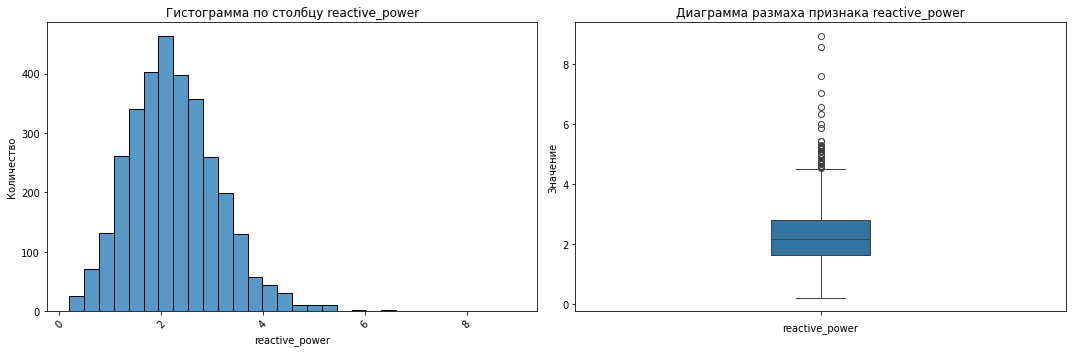

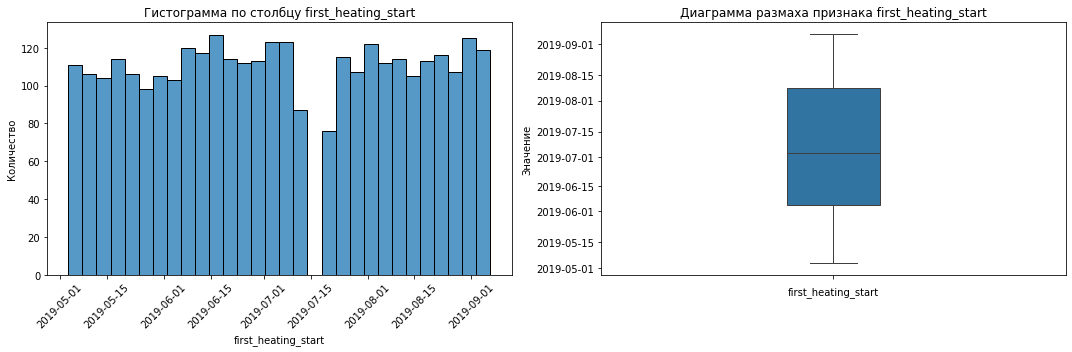

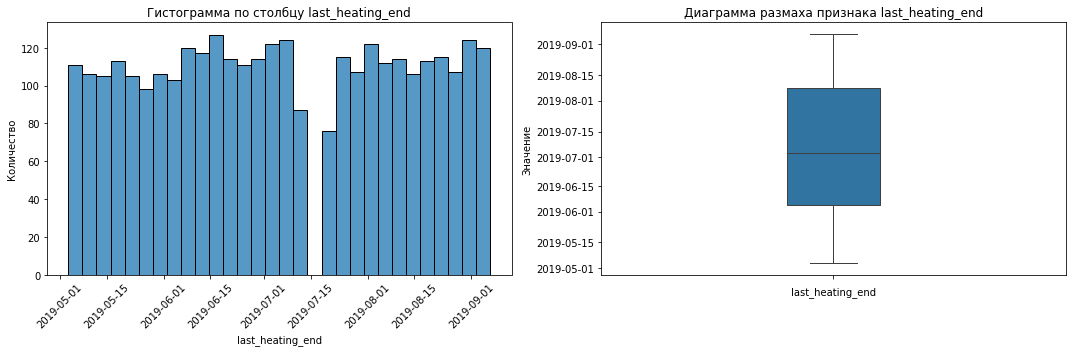

In [ ]:
lunge_analysis(group_key, group_key.columns)

Из данных видно:
1. На одну партию чаще всего приходится 3 кВт активной мощности.
2. На одной партию чаще всего приходится чуть меньше 4 кВт полной мощности.
3. На одну партию чаще всего затрачивается около 500 кВт, но бывают случаи, когда затраты составлют более 4000 кВт.
4. Общее всего нагрева одной партии чаще всего составляет около 600-800 с, но бывают случаи, когда партия суммарно нагревается более 4000 с.
5. Реактивная мощность, приходящаяся на одну партию, чаще всего составляет 2 кВт, но бывают случаи, когда она более 8 кВт.
6. Чаще всего одна и та же партия нагревается 4 раза, но бывают случаи, когда нагрев включается до 16 раз.


### Таблица data_bulk

Теперь поработаем с таблице data_bulk, которая содержит информацию о добавлении сыпучих веществ.

In [ ]:
data_bulk.head()

key  Bulk 1  Bulk 2  Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1     NaN     NaN     NaN    43.0   None   None   None   None   None   
1    2     NaN     NaN     NaN    73.0   None   None   None   None   None   
2    3     NaN     NaN     NaN    34.0   None   None   None   None   None   
3    4     NaN     NaN     NaN    81.0   None   None   None   None   None   
4    5     NaN     NaN     NaN    78.0   None   None   None   None   None   

  Bulk 10 Bulk 11 Bulk 12 Bulk 13 Bulk 14 Bulk 15  
0    None    None   206.0    None   150.0   154.0  
1    None    None   206.0    None   149.0   154.0  
2    None    None   205.0    None   152.0   153.0  
3    None    None   207.0    None   153.0   154.0  
4    None    None   203.0    None   151.0   152.0

In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


В ней много пропусков и названия столбцов не удобны для работы. Изменим их.

In [ ]:
for i in range(1, 16):
  data_bulk = data_bulk.rename(columns={f'Bulk {i}':f'mass_bulk_{i}'})

В некоторых столбцах очень мало значений. Вряд ли они будут полезны для модели. Лучше их удалить.

In [ ]:
data_bulk = data_bulk.drop(['mass_bulk_8'], axis=1)

Создадим категориальный признак для каждого компонента. Если материал добавлялся, то 1, если нет, то 0.

In [ ]:
data_bulk = create_binary_flags(data_bulk, data_bulk.drop('key', axis=1).columns)

Согласно описанию к заданию, пропуски означают, что материал не добавлялся. Следовательно, логично присвоить им значение 0.

In [ ]:
data_bulk = data_bulk.fillna(0)

Приведем к типу данных

In [ ]:
data_bulk = data_bulk.astype(np.float64)

In [ ]:
data_bulk.head()

key  mass_bulk_1  mass_bulk_2  mass_bulk_3  mass_bulk_4  mass_bulk_5  \
0  1.0          0.0          0.0          0.0         43.0          0.0   
1  2.0          0.0          0.0          0.0         73.0          0.0   
2  3.0          0.0          0.0          0.0         34.0          0.0   
3  4.0          0.0          0.0          0.0         81.0          0.0   
4  5.0          0.0          0.0          0.0         78.0          0.0   

   mass_bulk_6  mass_bulk_7  mass_bulk_9  mass_bulk_10  ...  has_mass_bulk_5  \
0          0.0          0.0          0.0           0.0  ...              0.0   
1          0.0          0.0          0.0           0.0  ...              0.0   
2          0.0          0.0          0.0           0.0  ...              0.0   
3          0.0          0.0          0.0           0.0  ...              0.0   
4          0.0          0.0          0.0           0.0  ...              0.0   

   has_mass_bulk_6  has_mass_bulk_7  has_mass_bulk_9  has_mass_bulk_10  \
0              0.0              0.0              0.0               0.0   
1              0.0              0.0              0.0               0.0   
2              0.0              0.0              0.0               0.0   
3              0.0              0.0              0.0               0.0   
4              0.0              0.0              0.0               0.0   

   has_mass_bulk_11  has_mass_bulk_12  has_mass_bulk_13  has_mass_bulk_14  \
0               0.0               1.0               0.0               1.0   
1               0.0               1.0               0.0               1.0   
2               0.0               1.0               0.0               1.0   
3               0.0               1.0               0.0               1.0   
4               0.0               1.0               0.0               1.0   

   has_mass_bulk_15  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0  

[5 rows x 29 columns]

In [ ]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               3129 non-null   float64
 1   mass_bulk_1       3129 non-null   float64
 2   mass_bulk_2       3129 non-null   float64
 3   mass_bulk_3       3129 non-null   float64
 4   mass_bulk_4       3129 non-null   float64
 5   mass_bulk_5       3129 non-null   float64
 6   mass_bulk_6       3129 non-null   float64
 7   mass_bulk_7       3129 non-null   float64
 8   mass_bulk_9       3129 non-null   float64
 9   mass_bulk_10      3129 non-null   float64
 10  mass_bulk_11      3129 non-null   float64
 11  mass_bulk_12      3129 non-null   float64
 12  mass_bulk_13      3129 non-null   float64
 13  mass_bulk_14      3129 non-null   float64
 14  mass_bulk_15      3129 non-null   float64
 15  has_mass_bulk_1   3129 non-null   float64
 16  has_mass_bulk_2   3129 non-null   float64


Проведем анализ распределения

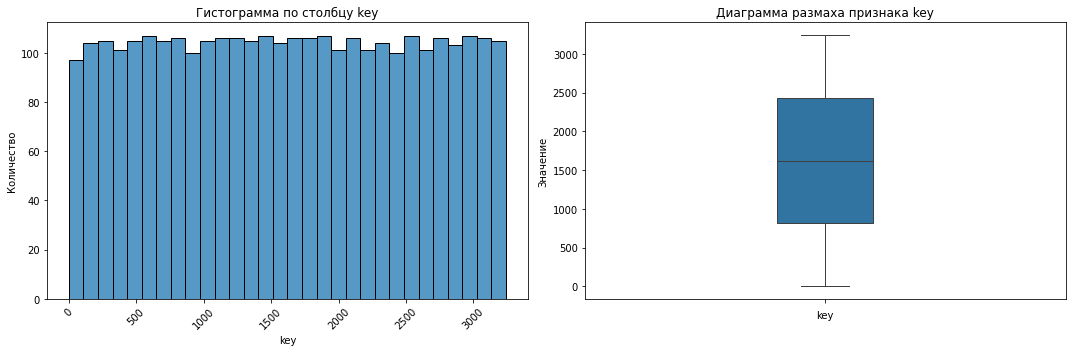

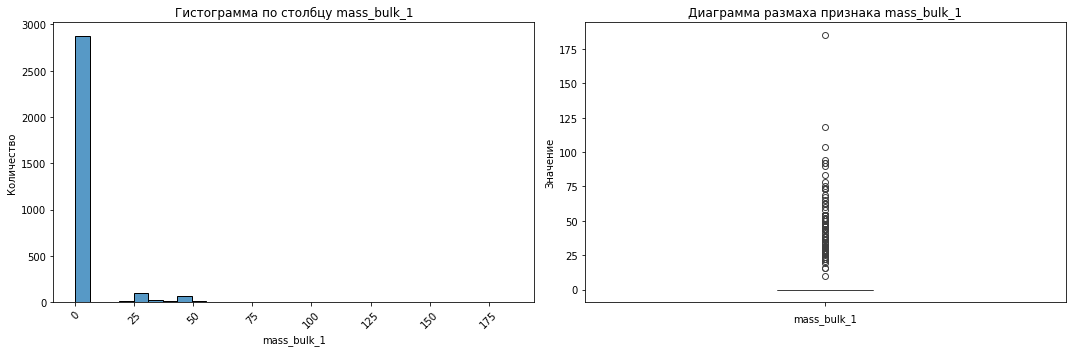

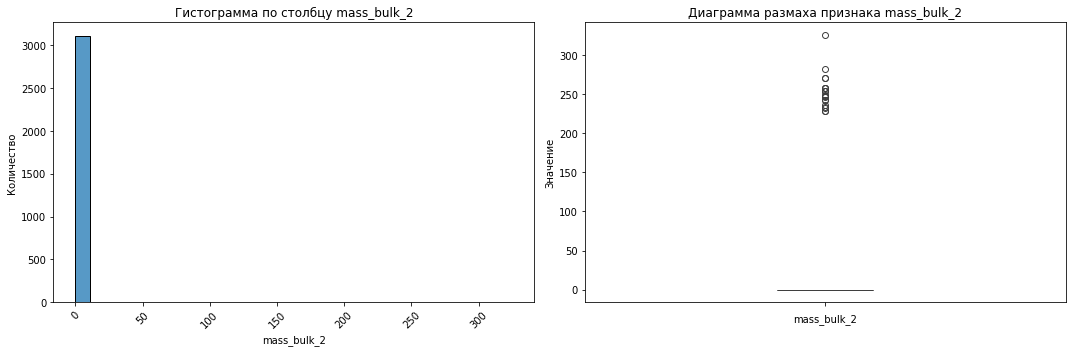

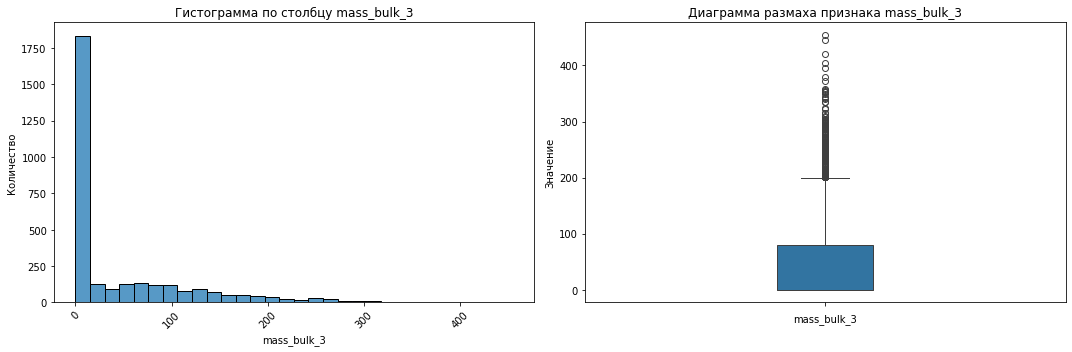

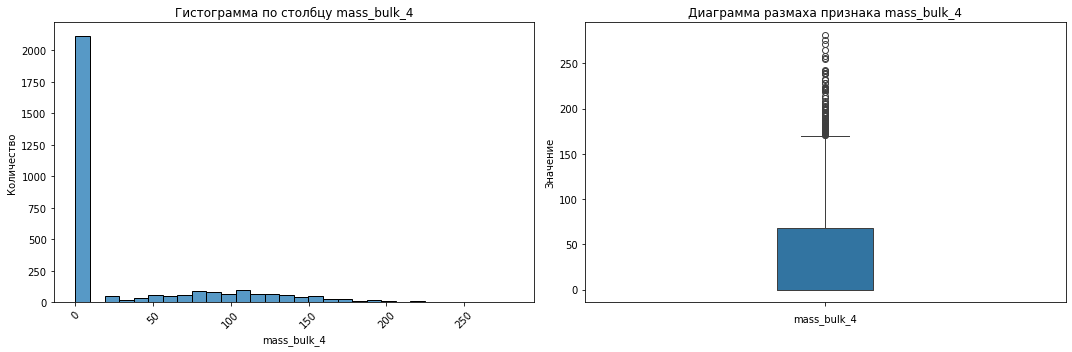

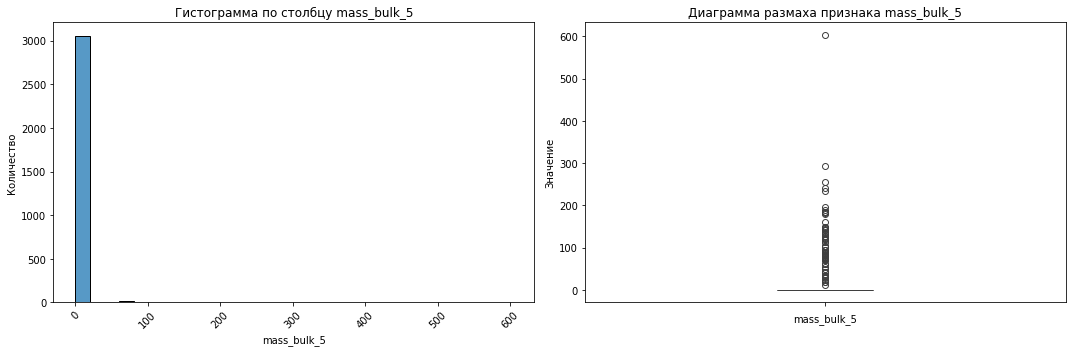

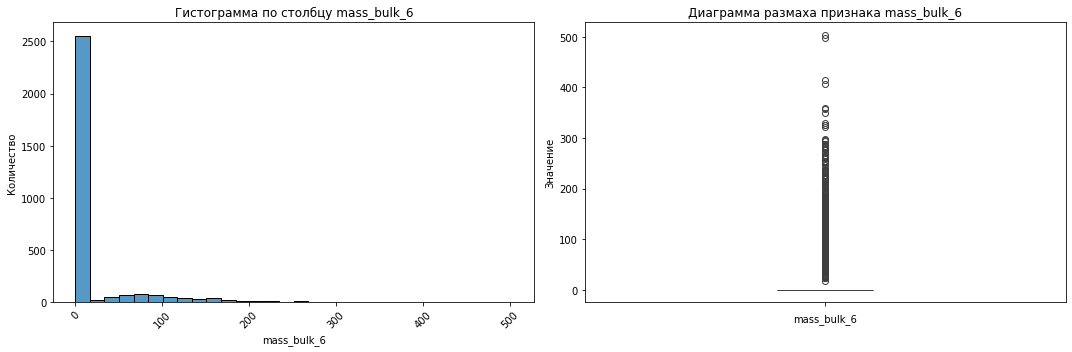

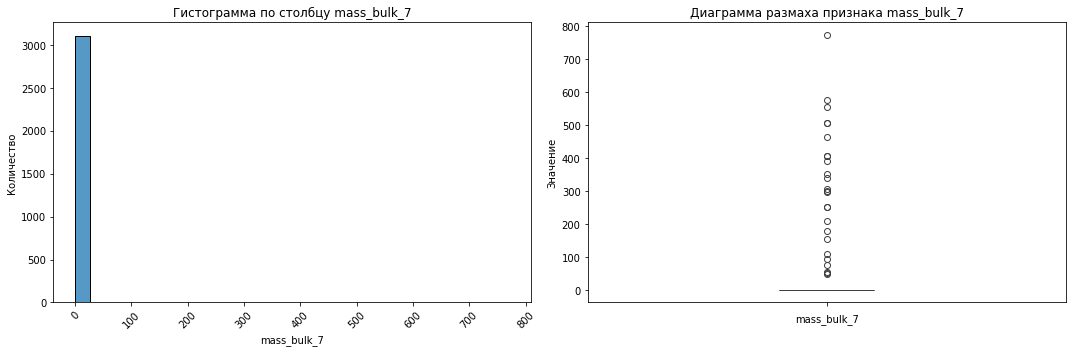

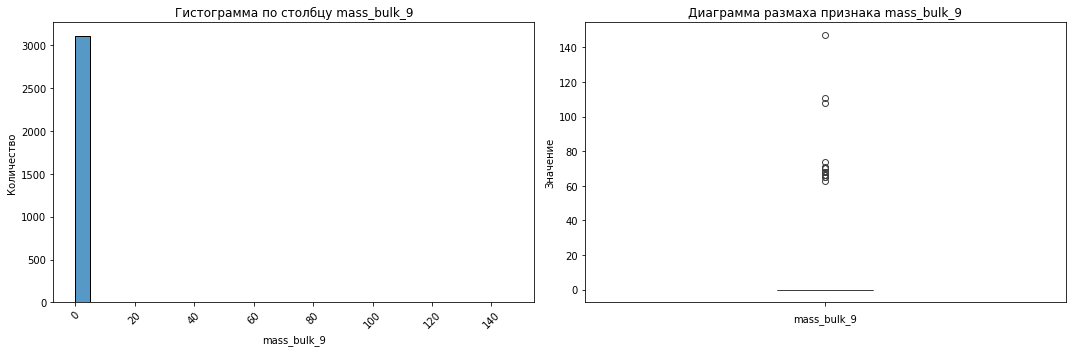

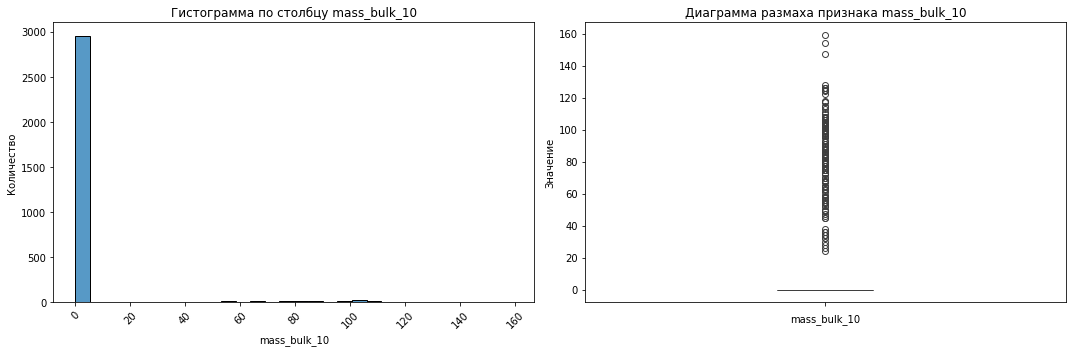

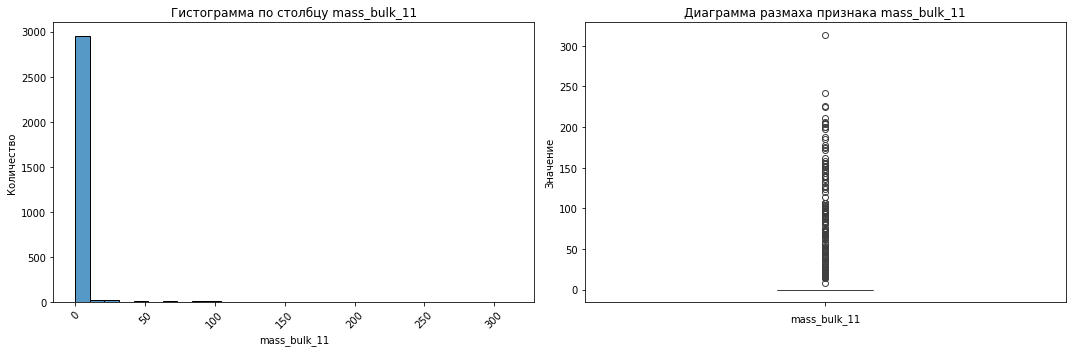

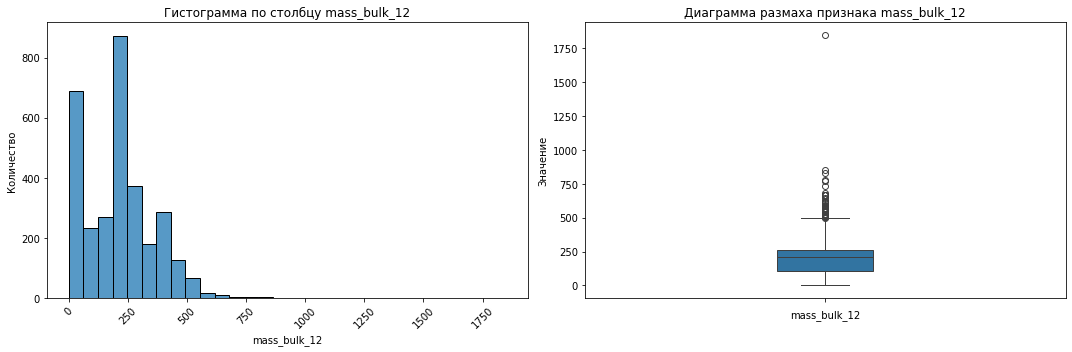

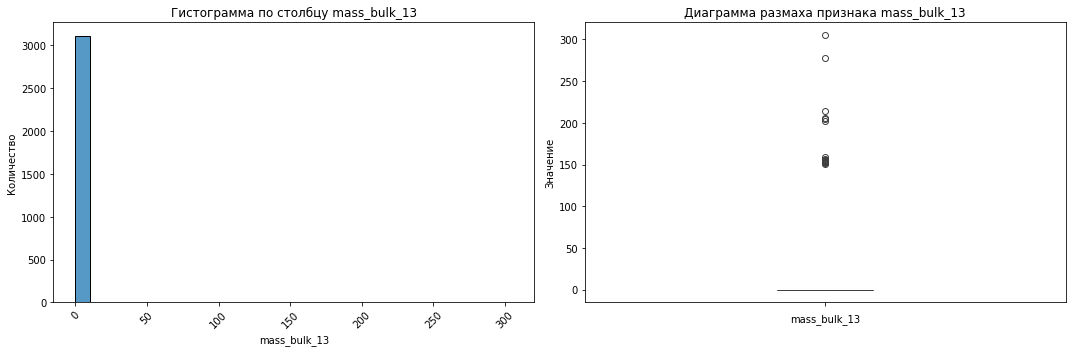

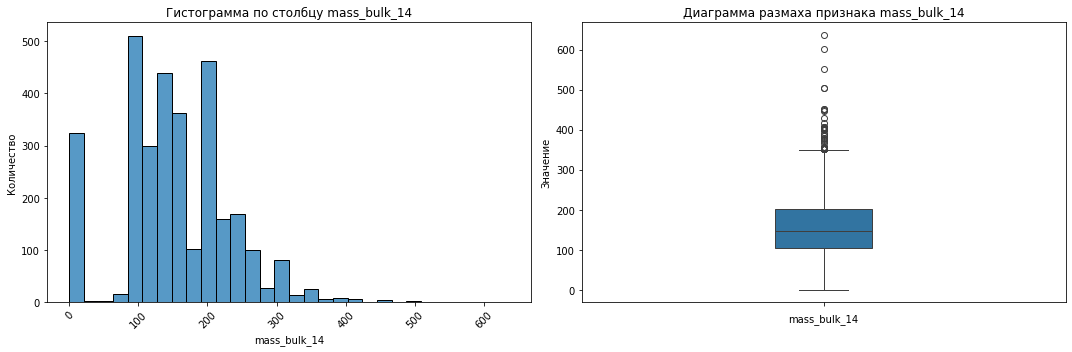

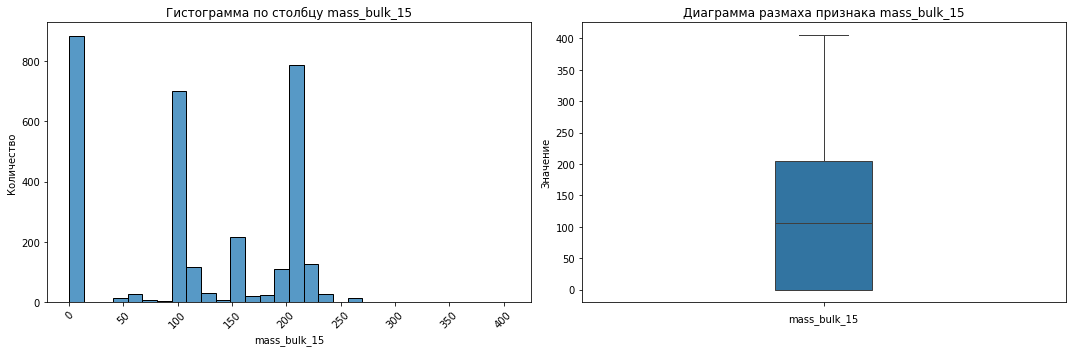

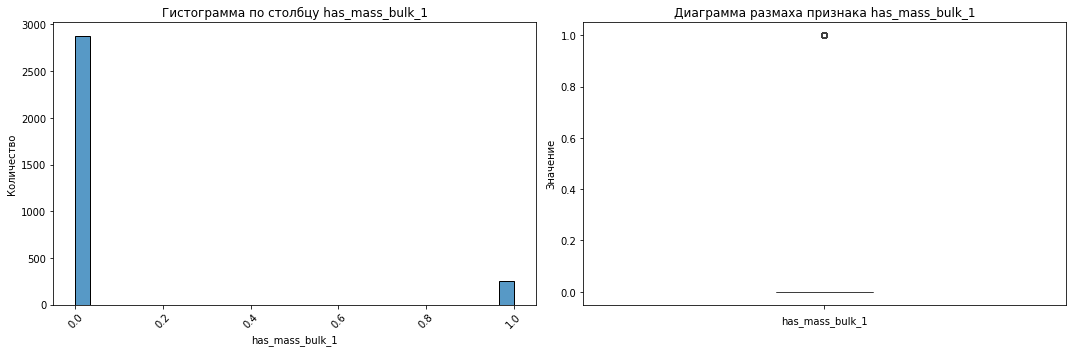

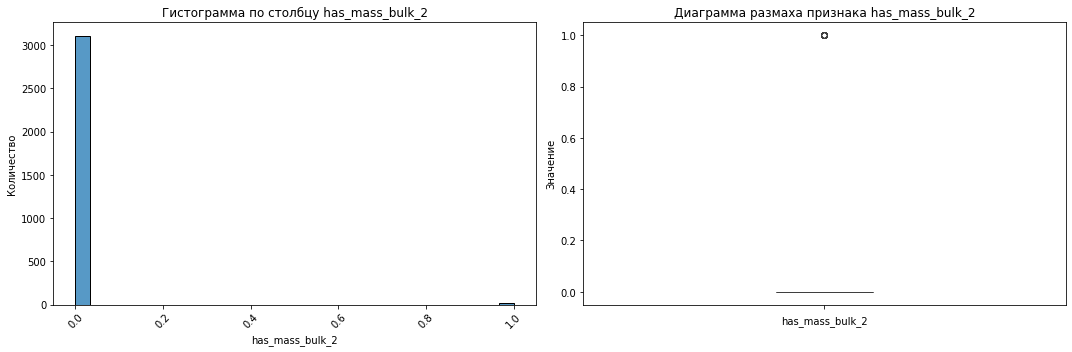

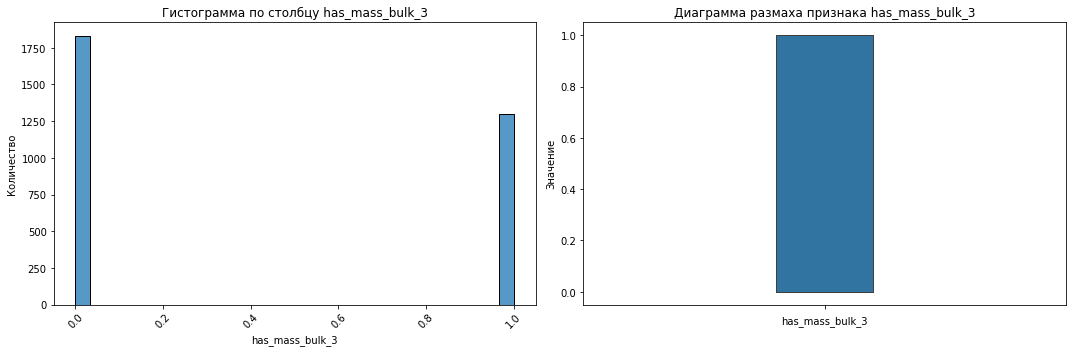

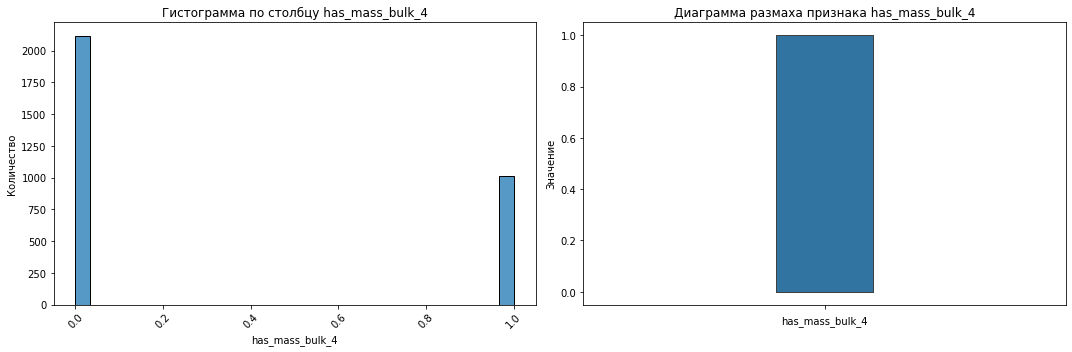

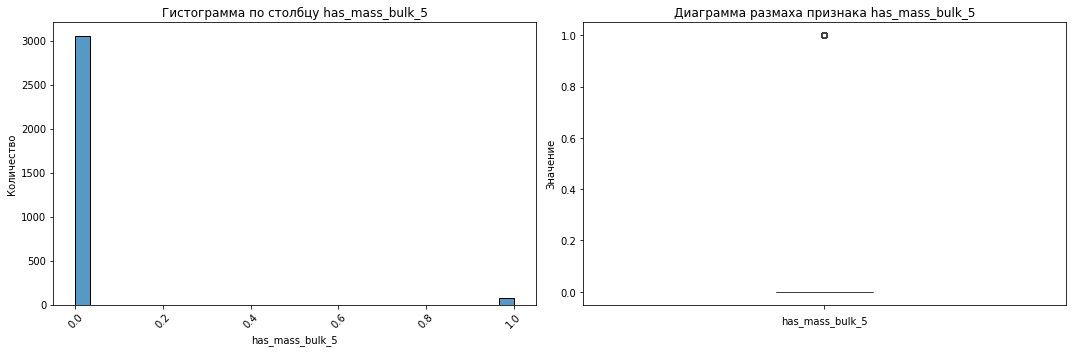

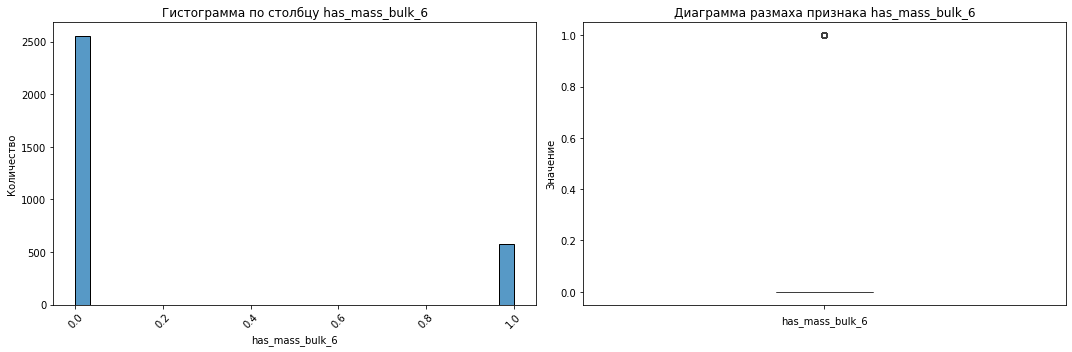

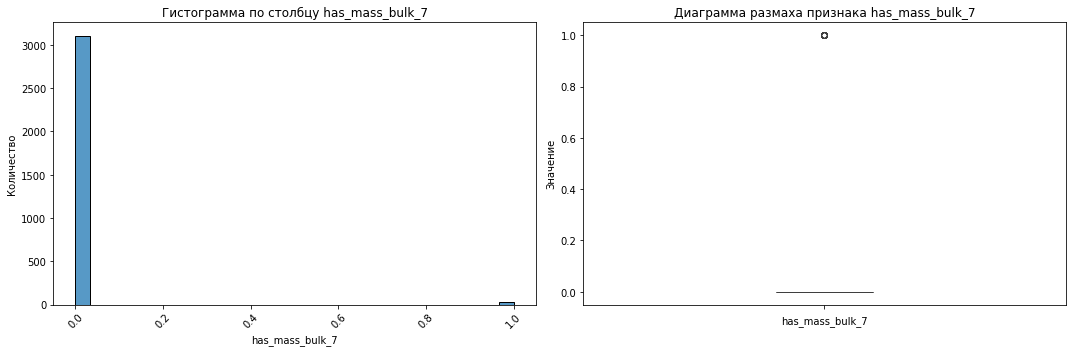

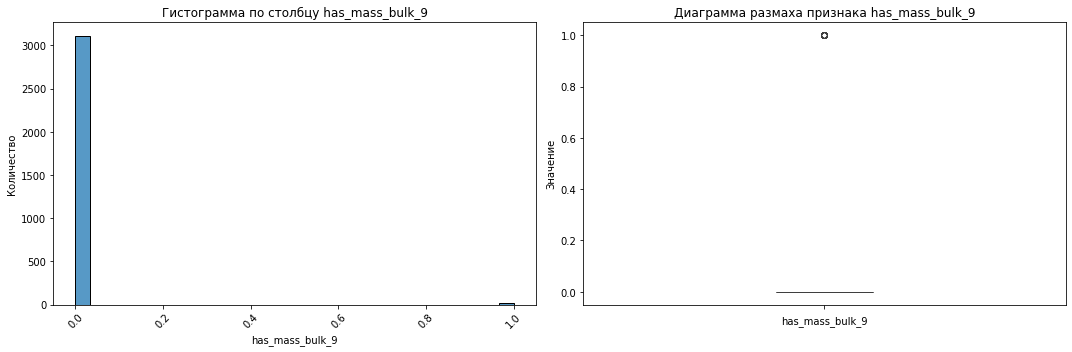

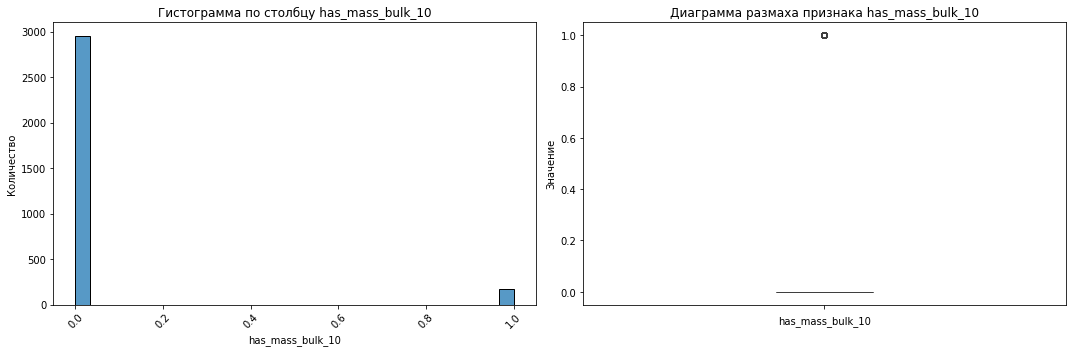

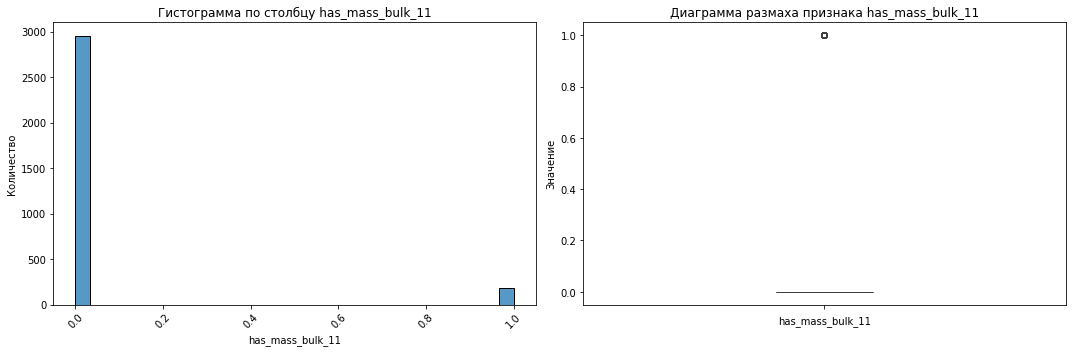

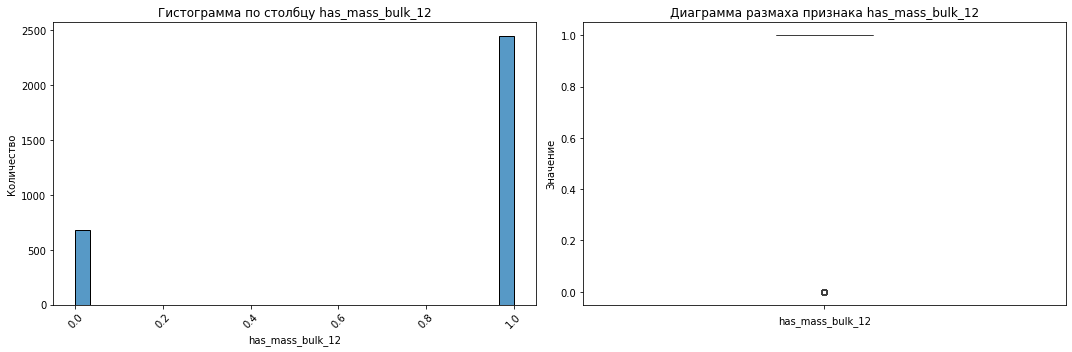

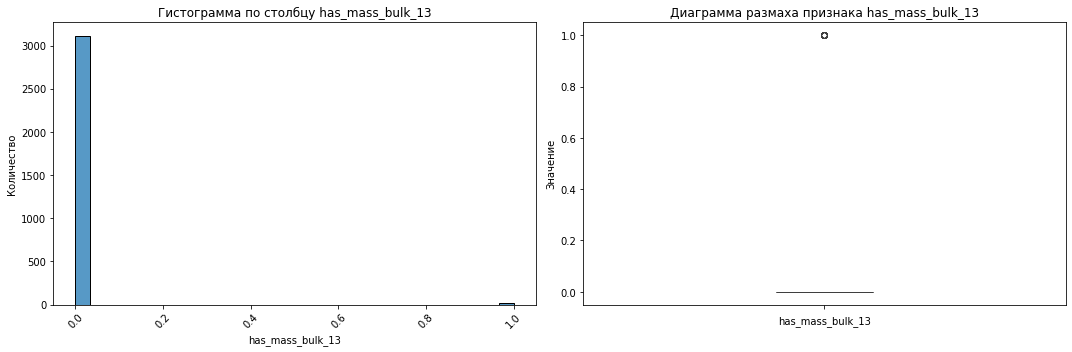

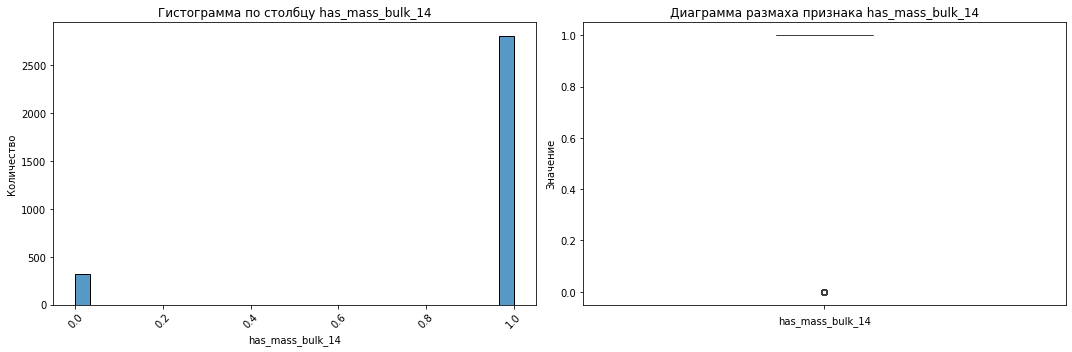

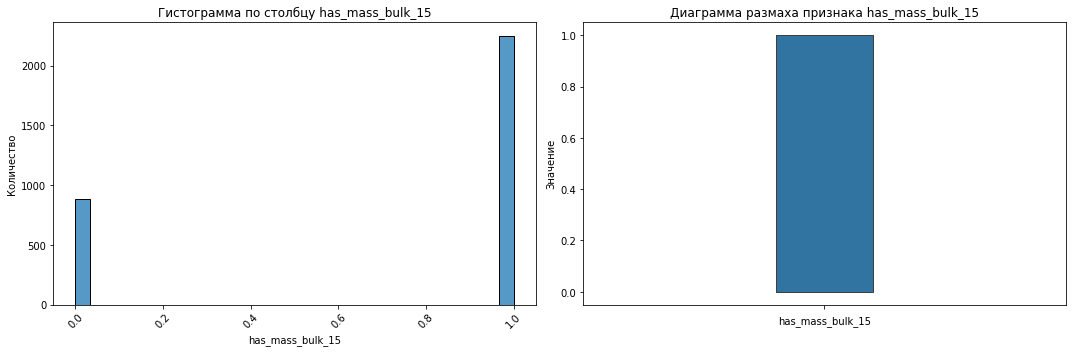

In [ ]:
lunge_analysis(data_bulk, data_bulk.columns)

Из графиков видно:
1. Не все материалы добавляются во все партии.
2. Чаще всего добавляются порошки №12, №14 и 15

### Таблица data_bulk_time

Теперь таблица data_bulk_time

In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [ ]:
data_bulk_time.head()

key Bulk 1 Bulk 2 Bulk 3               Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8  \
0    1   None   None   None  2019-05-03 11:28:48   None   None   None   None   
1    2   None   None   None  2019-05-03 11:36:50   None   None   None   None   
2    3   None   None   None  2019-05-03 12:32:39   None   None   None   None   
3    4   None   None   None  2019-05-03 12:43:22   None   None   None   None   
4    5   None   None   None  2019-05-03 13:30:47   None   None   None   None   

  Bulk 9 Bulk 10 Bulk 11              Bulk 12 Bulk 13              Bulk 14  \
0   None    None    None  2019-05-03 11:24:31    None  2019-05-03 11:14:50   
1   None    None    None  2019-05-03 11:53:30    None  2019-05-03 11:48:37   
2   None    None    None  2019-05-03 12:27:13    None  2019-05-03 12:21:01   
3   None    None    None  2019-05-03 12:58:00    None  2019-05-03 12:51:11   
4   None    None    None  2019-05-03 13:30:47    None  2019-05-03 13:34:12   

               Bulk 15  
0  2019-05-03 11:10:43  
1  2019-05-03 11:44:39  
2  2019-05-03 12:16:16  
3  2019-05-03 12:46:36  
4  2019-05-03 13:30:47

Здесь также не очень удобны для работы названия столбцов. Переименуем их.

In [ ]:
for i in range(1, 16):
  data_bulk_time = data_bulk_time.rename(columns={f'Bulk {i}':f'time_bulk_{i}'})

In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           3129 non-null   int64 
 1   time_bulk_1   252 non-null    object
 2   time_bulk_2   22 non-null     object
 3   time_bulk_3   1298 non-null   object
 4   time_bulk_4   1014 non-null   object
 5   time_bulk_5   77 non-null     object
 6   time_bulk_6   576 non-null    object
 7   time_bulk_7   25 non-null     object
 8   time_bulk_8   1 non-null      object
 9   time_bulk_9   19 non-null     object
 10  time_bulk_10  176 non-null    object
 11  time_bulk_11  177 non-null    object
 12  time_bulk_12  2450 non-null   object
 13  time_bulk_13  18 non-null     object
 14  time_bulk_14  2806 non-null   object
 15  time_bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Здесь такое же количество пропусков. Удалим столбцы с малым количеством значений.

In [ ]:
data_bulk_time = data_bulk_time.drop(['time_bulk_8'], axis=1)

Переведем данные в даты.

In [ ]:
date_columns = data_bulk_time.drop('key', axis=1).columns
data_bulk_time[date_columns] = data_bulk_time[date_columns].apply(pd.to_datetime)

In [ ]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           3129 non-null   int64         
 1   time_bulk_1   252 non-null    datetime64[ns]
 2   time_bulk_2   22 non-null     datetime64[ns]
 3   time_bulk_3   1298 non-null   datetime64[ns]
 4   time_bulk_4   1014 non-null   datetime64[ns]
 5   time_bulk_5   77 non-null     datetime64[ns]
 6   time_bulk_6   576 non-null    datetime64[ns]
 7   time_bulk_7   25 non-null     datetime64[ns]
 8   time_bulk_9   19 non-null     datetime64[ns]
 9   time_bulk_10  176 non-null    datetime64[ns]
 10  time_bulk_11  177 non-null    datetime64[ns]
 11  time_bulk_12  2450 non-null   datetime64[ns]
 12  time_bulk_13  18 non-null     datetime64[ns]
 13  time_bulk_14  2806 non-null   datetime64[ns]
 14  time_bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](14), int64(1)
memory

Проанализируем результаты

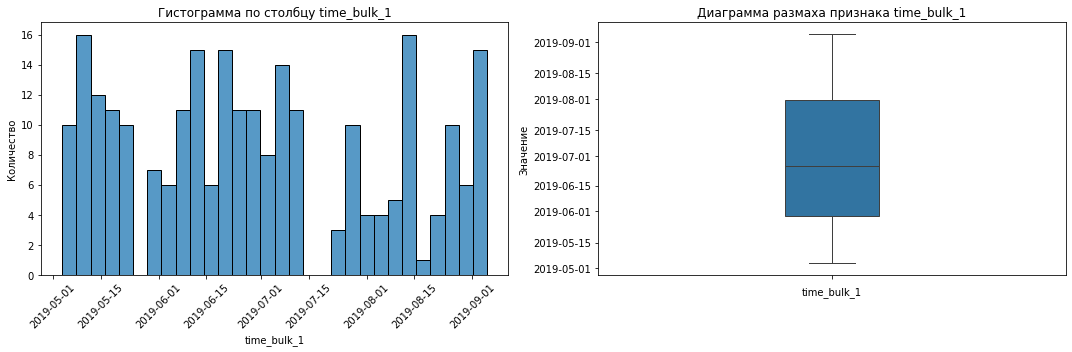

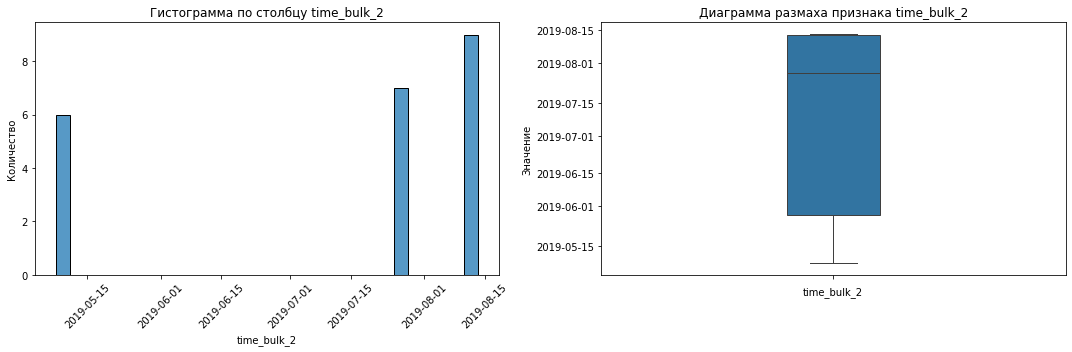

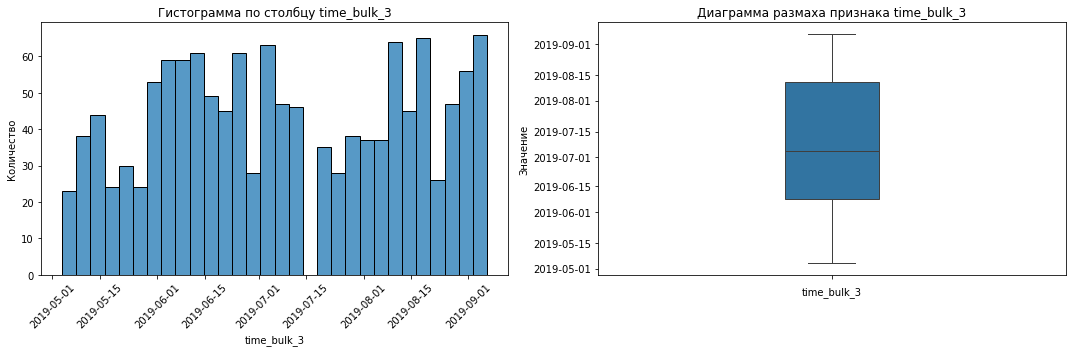

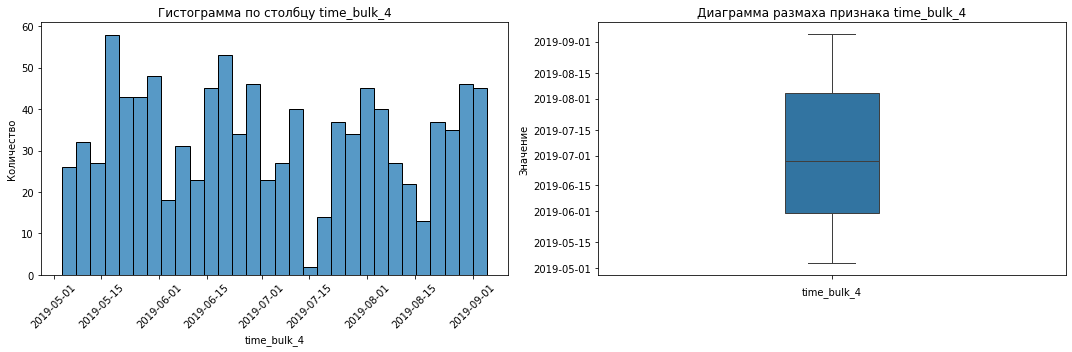

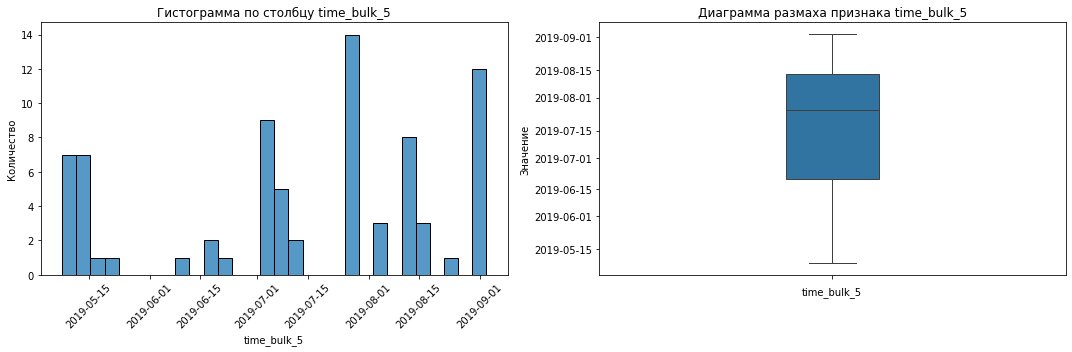

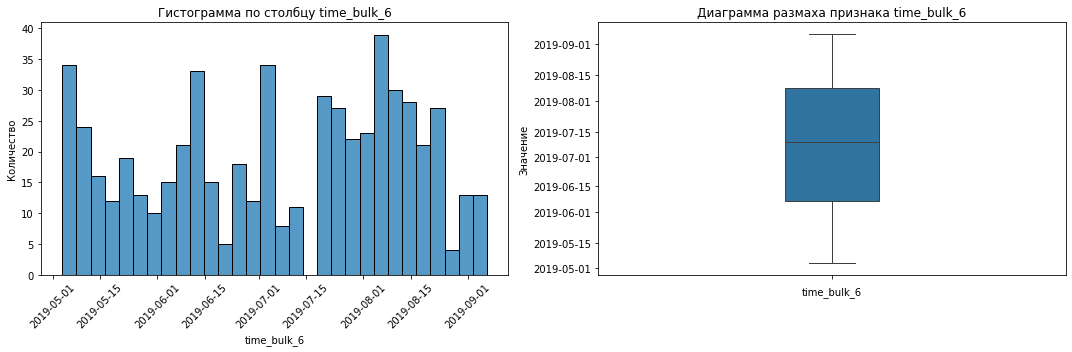

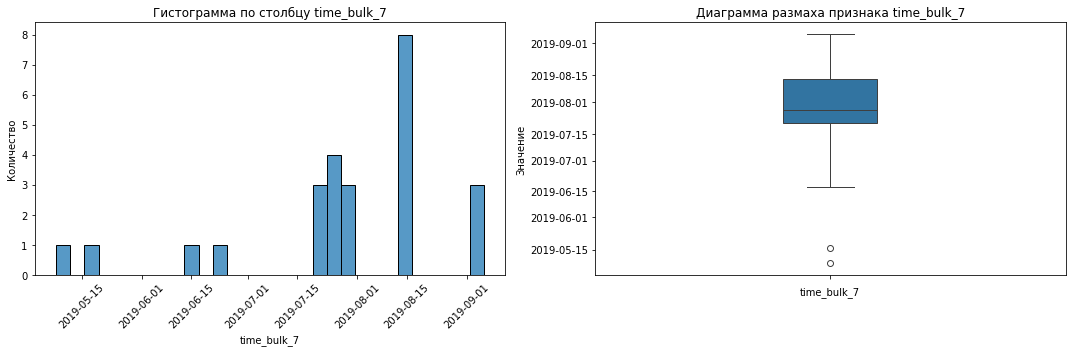

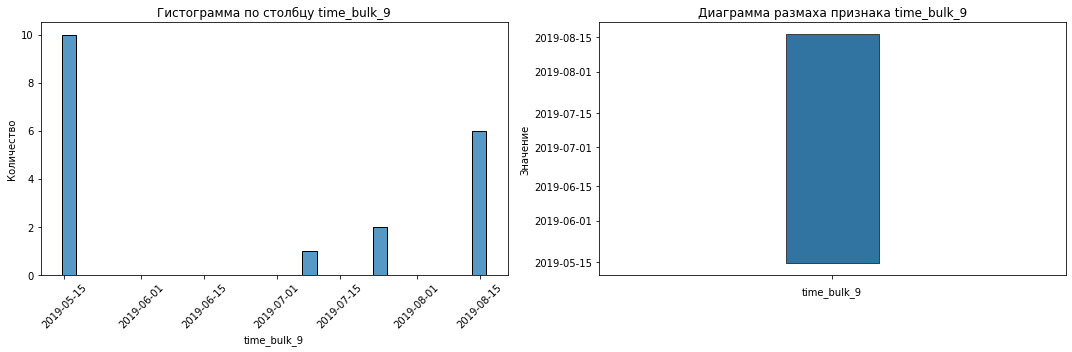

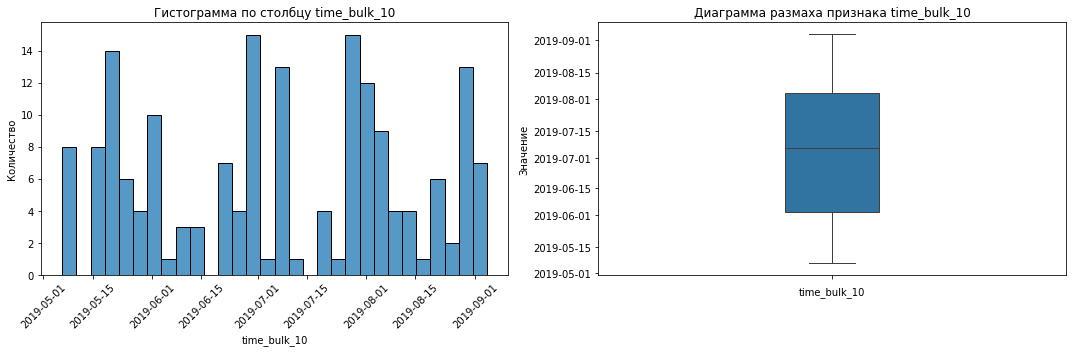

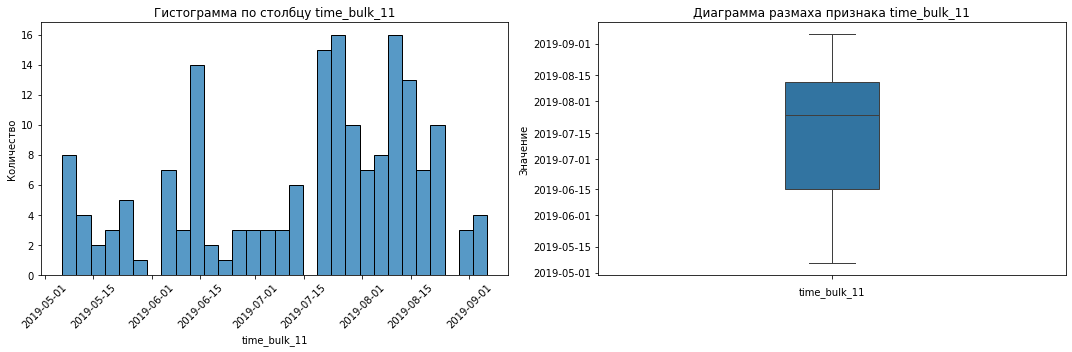

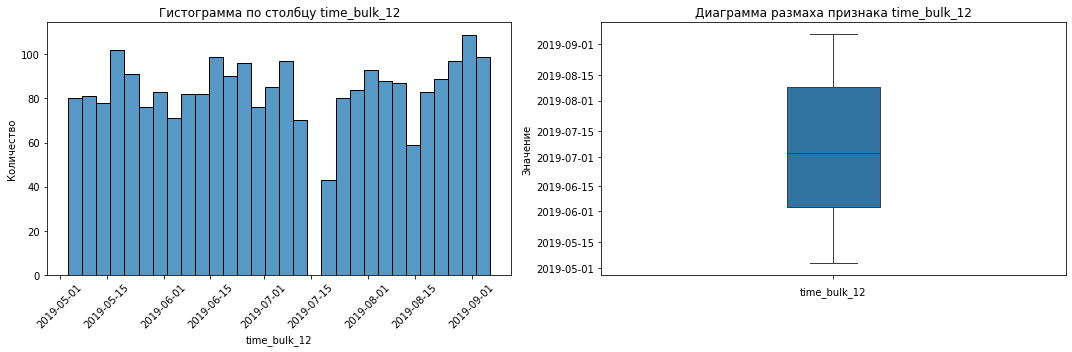

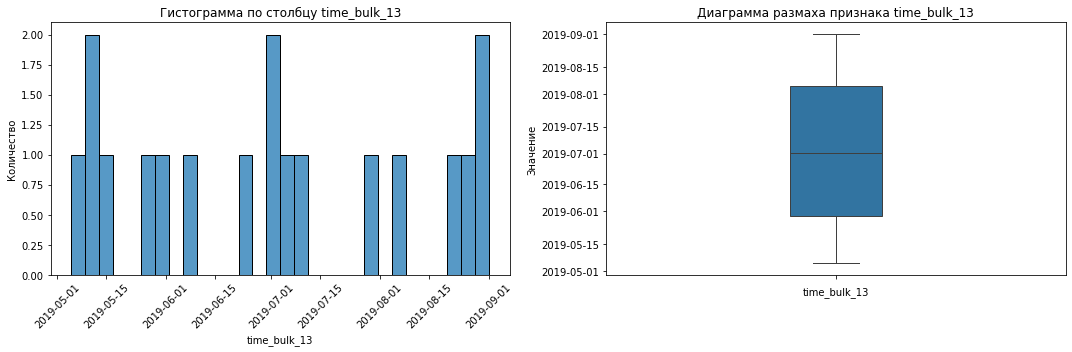

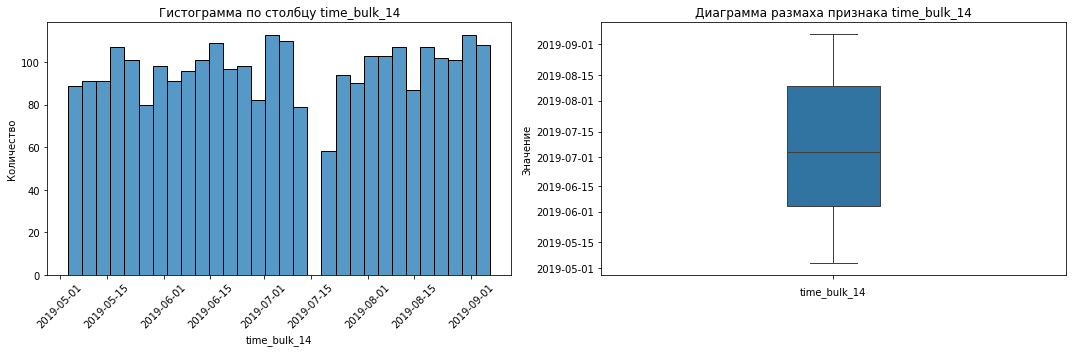

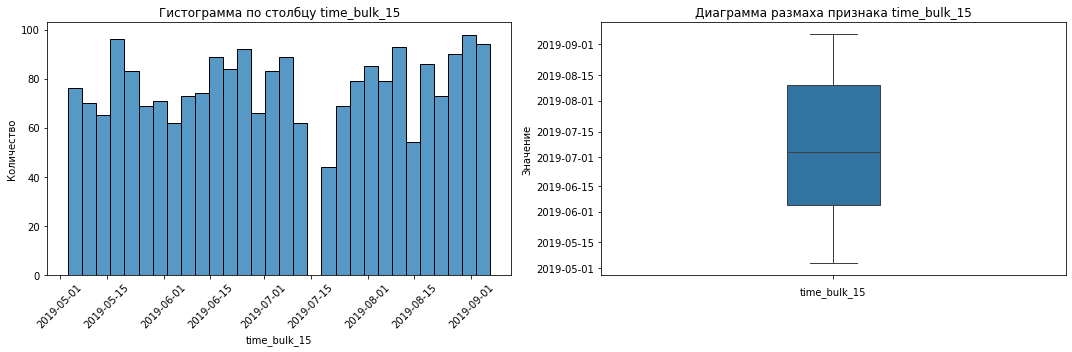

In [ ]:
lunge_analysis(data_bulk_time, data_bulk_time[date_columns])

Из диаграмм видно, что нет четкой зависимости добавления компонентов от даты.

### Таблица data_gas

Теперь таблица data_gas, в ней содержится информация об объеме газа на продувки сплава.

In [ ]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [ ]:
data_gas.head()

key      Газ 1
0    1  29.749986
1    2  12.555561
2    3  28.554793
3    4  18.841219
4    5   5.413692

Пропусков нет, переименуем столбцы

In [ ]:
data_gas = data_gas.rename(columns={'Газ 1':'gas'})

Проанализируем распределение

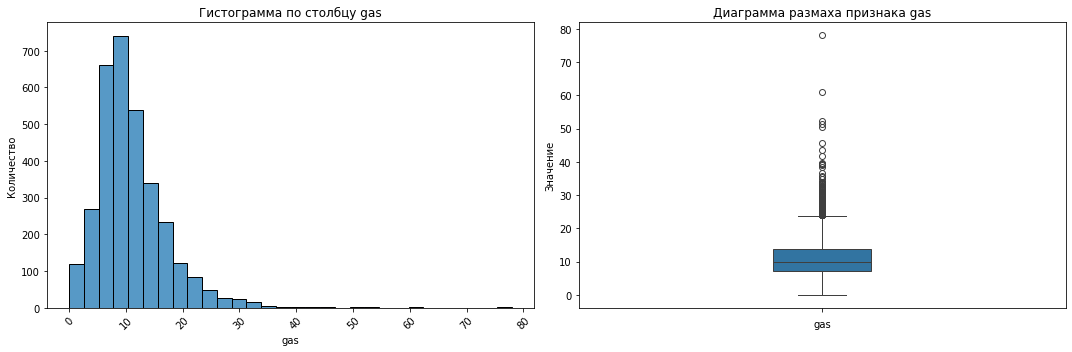

In [ ]:
lunge_analysis(data_gas, ['gas'])

Очевидно, что чаще всего объем газа составляет около 10, но есть редкие случаи, когда его до 80.

### Таблица data_temp

Теперь таблица data_temp. В ней содержится целевой признак - конечная температура.

In [ ]:
data_temp.head()

key         Время замера Температура
0    1  2019-05-03 11:02:04      1571.0
1    1  2019-05-03 11:07:18      1604.0
2    1  2019-05-03 11:11:34      1618.0
3    1  2019-05-03 11:18:04      1601.0
4    1  2019-05-03 11:25:59      1606.0

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


Пропуски есть, переименуем столбцы и приведем тип данных к одному значению.

In [ ]:
data_temp = data_temp.rename(columns={'Время замера': 'meas_time',
                                      'Температура':'temp'})

In [ ]:
data_temp['meas_time'] = data_temp['meas_time'].apply(pd.to_datetime)
data_temp['temp'] = data_temp['temp'].astype(np.float64)

По указанию заказчика, температуры ниже 1500 - аномалии. Значит их необходимо отрезать.

In [ ]:
data_temp = data_temp.loc[data_temp['temp']>=1500]

In [ ]:
data_temp.head()

key           meas_time    temp
0    1 2019-05-03 11:02:04  1571.0
1    1 2019-05-03 11:07:18  1604.0
2    1 2019-05-03 11:11:34  1618.0
3    1 2019-05-03 11:18:04  1601.0
4    1 2019-05-03 11:25:59  1606.0

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14660 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        14660 non-null  int64         
 1   meas_time  14660 non-null  datetime64[ns]
 2   temp       14660 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.1 KB


Аномальные значения отрезаны, пропусков не осталось. Потеряно примерно 18% данных.

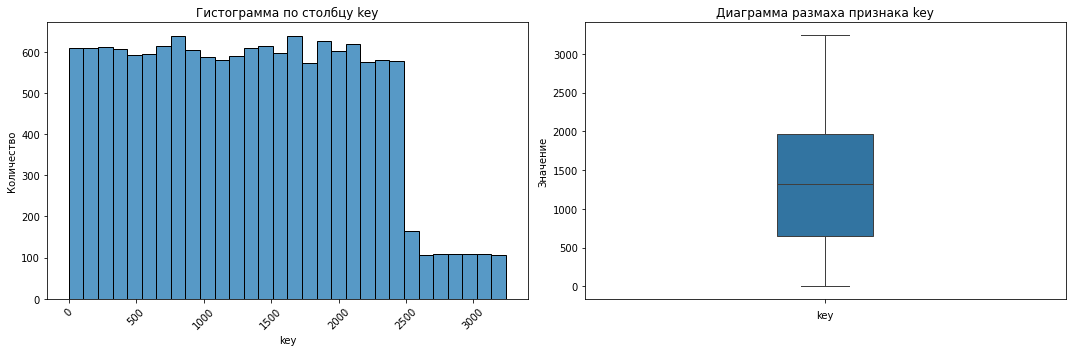

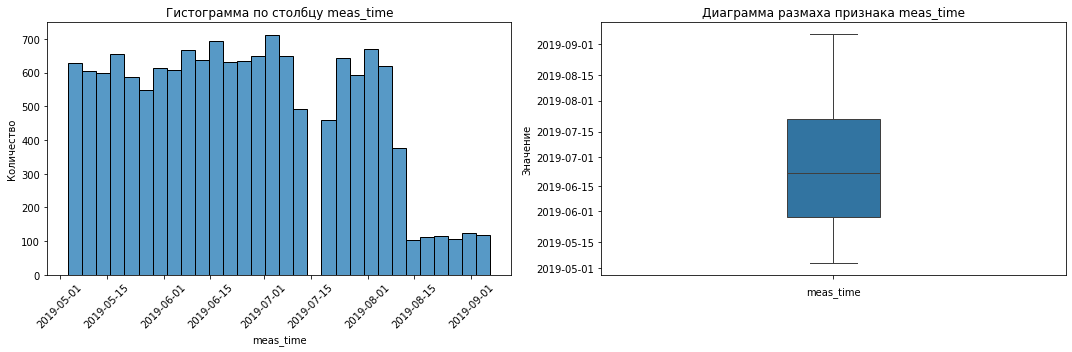

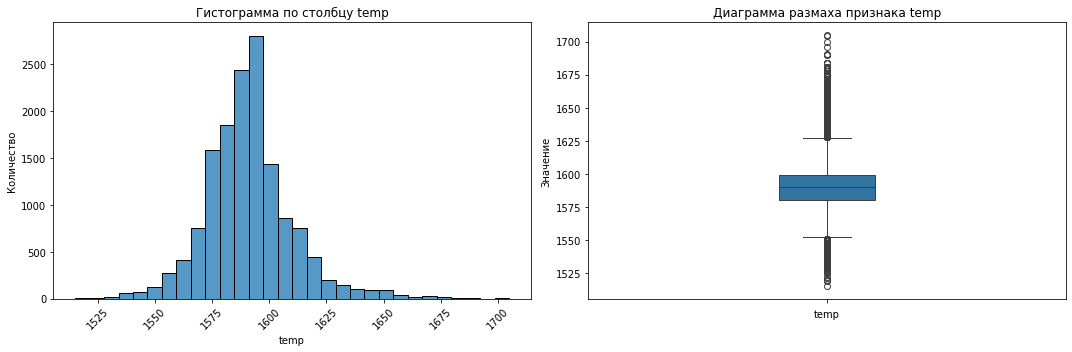

In [ ]:
lunge_analysis(data_temp, data_temp.columns)

Из диаграмм видно:
1. Среди партия с номером более 2500 мало измерений. Вероятно, аномальные значений, которые были отрезаны, в основном относились к ним.
2. Чаще всего регистрируется температура около 1600 градусов.

Извлечем из данной таблицы целевой признак (конечную температуру) и посчитаем количество измерений для каждой партии.

In [ ]:
party_counts = data_temp.groupby('key').size().reset_index(name='measurement_count')

In [ ]:
key_temp = data_temp.groupby('key').agg({'meas_time': ['min', 'max']}).reset_index()
key_temp.columns = ['key', 'start_time', 'end_time']

Добавим в таблицу информацию о количестве замеров.

In [ ]:
key_temp = key_temp.merge(party_counts, on='key', how='left')

In [ ]:
key_temp.head()

key          start_time            end_time  measurement_count
0    1 2019-05-03 11:02:04 2019-05-03 11:30:38                  6
1    2 2019-05-03 11:34:04 2019-05-03 11:55:09                  5
2    3 2019-05-03 12:06:44 2019-05-03 12:35:57                  6
3    4 2019-05-03 12:39:27 2019-05-03 12:59:47                  5
4    5 2019-05-03 13:11:03 2019-05-03 13:36:39                  5

Добавим в таблицу информацию о начальной и конечной температуре

In [ ]:
# Добавляем соответствующие температуры
# Для начальной температуры
start_temps = data_temp.loc[data_temp.groupby('key')['meas_time'].idxmin(), 'temp']
key_temp['start_temp'] = start_temps.values

# Для конечной температуры
end_temps = data_temp.loc[data_temp.groupby('key')['meas_time'].idxmax(), 'temp']
key_temp['end_temp'] = end_temps.values

Отсеем те партии, в которых температура измерялась менее 2 раз, так как в этих партиях нельзя сказать, какая температура начальная, а какая конечная.

In [ ]:
key_temp = key_temp.loc[key_temp['measurement_count'] > 1]

In [ ]:
key_temp = key_temp.reset_index(drop=True)

Удалим признак с подсчетом количества замеров для исключения утечки данных.

In [ ]:
key_temp = key_temp.drop('measurement_count', axis=1)

In [ ]:
key_temp.head()

key          start_time            end_time  start_temp  end_temp
0    1 2019-05-03 11:02:04 2019-05-03 11:30:38      1571.0    1613.0
1    2 2019-05-03 11:34:04 2019-05-03 11:55:09      1581.0    1602.0
2    3 2019-05-03 12:06:44 2019-05-03 12:35:57      1596.0    1599.0
3    4 2019-05-03 12:39:27 2019-05-03 12:59:47      1601.0    1625.0
4    5 2019-05-03 13:11:03 2019-05-03 13:36:39      1576.0    1602.0

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Целевой признак выбран корректно

In [ ]:
key_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2475 entries, 0 to 2474
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   key         2475 non-null   int64         
 1   start_time  2475 non-null   datetime64[ns]
 2   end_time    2475 non-null   datetime64[ns]
 3   start_temp  2475 non-null   float64       
 4   end_temp    2475 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 96.8 KB


Посмотрим на распределение

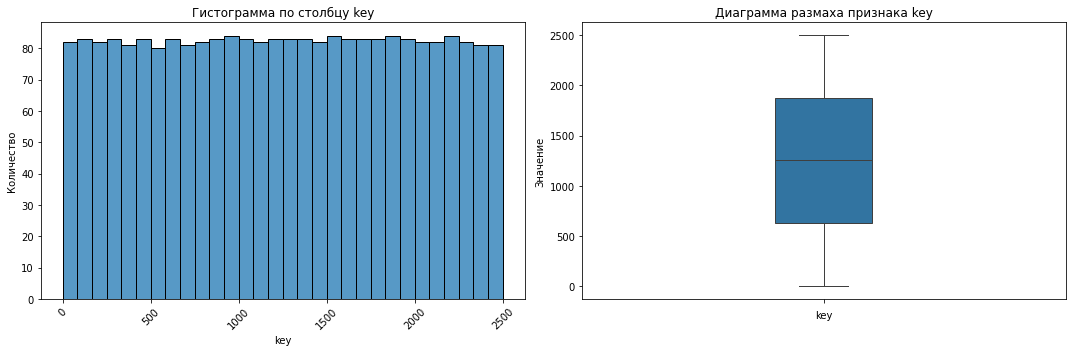

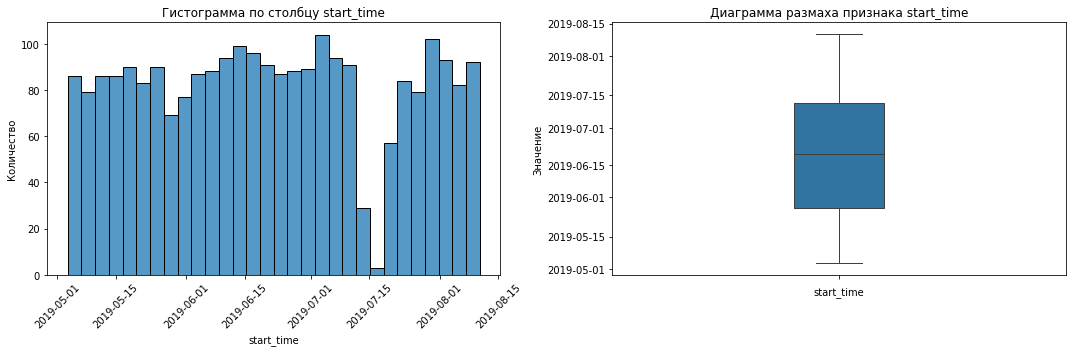

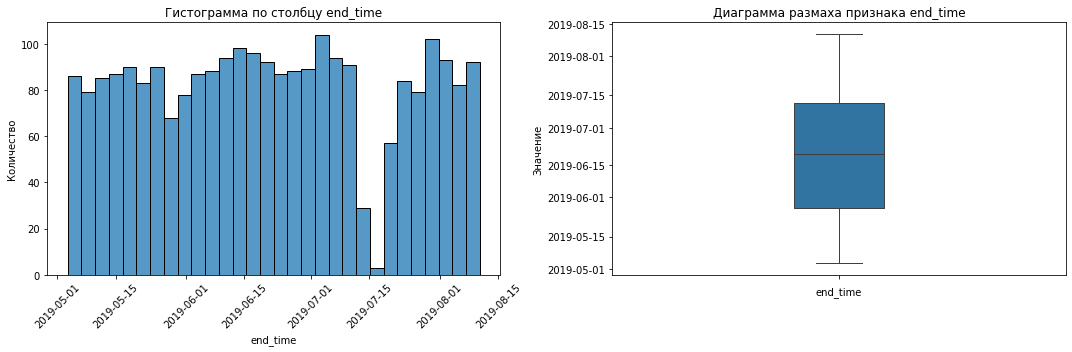

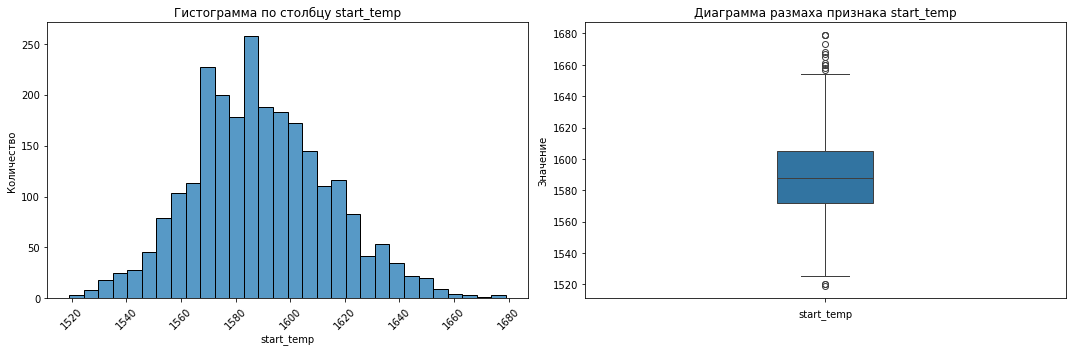

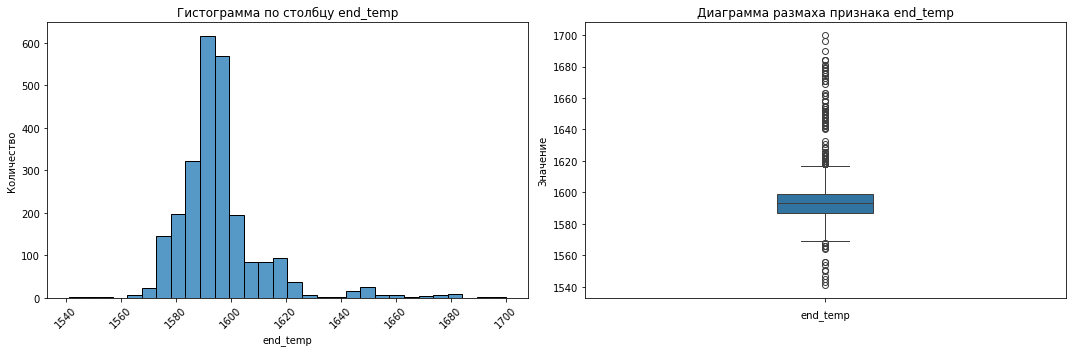

In [ ]:
lunge_analysis(key_temp, key_temp.columns)

Из диаграмм видно:
1. Начальная температура имеет более широкое распределение, чем конечная.
2. Начальная температура чаще всего оказывается в районе 1580 градусов, конечная в районе 1590.

### Таблица data_wire

Теперь таблица data_wire. Она содержит информацию о количестве добавленной проволоки.

In [ ]:
data_wire.head()

key     Wire 1   Wire 2 Wire 3 Wire 4 Wire 5 Wire 6 Wire 7 Wire 8 Wire 9
0    1  60.059998     None   None   None   None   None   None   None   None
1    2  96.052315     None   None   None   None   None   None   None   None
2    3  91.160157     None   None   None   None   None   None   None   None
3    4  89.063515     None   None   None   None   None   None   None   None
4    5  89.238236  9.11456   None   None   None   None   None   None   None

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Переименнуем столбцы.

In [ ]:
for i in range(1, 10):
  data_wire = data_wire.rename(columns={f'Wire {i}': f'mass_wire_{i}'})

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3081 non-null   int64  
 1   mass_wire_1  3055 non-null   float64
 2   mass_wire_2  1079 non-null   object 
 3   mass_wire_3  63 non-null     object 
 4   mass_wire_4  14 non-null     object 
 5   mass_wire_5  1 non-null      object 
 6   mass_wire_6  73 non-null     object 
 7   mass_wire_7  11 non-null     object 
 8   mass_wire_8  19 non-null     object 
 9   mass_wire_9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


Здесь также наблюдается ряд столбцов с очень малым количеством значений. Их предполагается отрезать.

In [ ]:
data_wire = data_wire.drop('mass_wire_5', axis=1)

Добавим категориальный признак, обозначающий факт добавления материала.

In [ ]:
data_wire = create_binary_flags(data_wire, data_wire.drop('key', axis=1).columns)

Столбцы удалены. Так как отсутствует информация о добавлении, значит материал не добавлялся и пропуски можно приравнять к 0.

In [ ]:
data_wire = data_wire.fillna(0)

In [ ]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              3081 non-null   int64  
 1   mass_wire_1      3081 non-null   float64
 2   mass_wire_2      3081 non-null   object 
 3   mass_wire_3      3081 non-null   object 
 4   mass_wire_4      3081 non-null   object 
 5   mass_wire_6      3081 non-null   object 
 6   mass_wire_7      3081 non-null   object 
 7   mass_wire_8      3081 non-null   object 
 8   mass_wire_9      3081 non-null   object 
 9   has_mass_wire_1  3081 non-null   int64  
 10  has_mass_wire_2  3081 non-null   int64  
 11  has_mass_wire_3  3081 non-null   int64  
 12  has_mass_wire_4  3081 non-null   int64  
 13  has_mass_wire_6  3081 non-null   int64  
 14  has_mass_wire_7  3081 non-null   int64  
 15  has_mass_wire_8  3081 non-null   int64  
 16  has_mass_wire_9  3081 non-null   int64  
dtypes: float64(1),

Пропуски заполнены, но осталась проблема с типом данных. Исправим её.

In [ ]:
type_columns = data_wire.drop('key', axis=1).columns

In [ ]:
data_wire[type_columns] = data_wire[type_columns].astype(np.float64)

Проанализируем результат

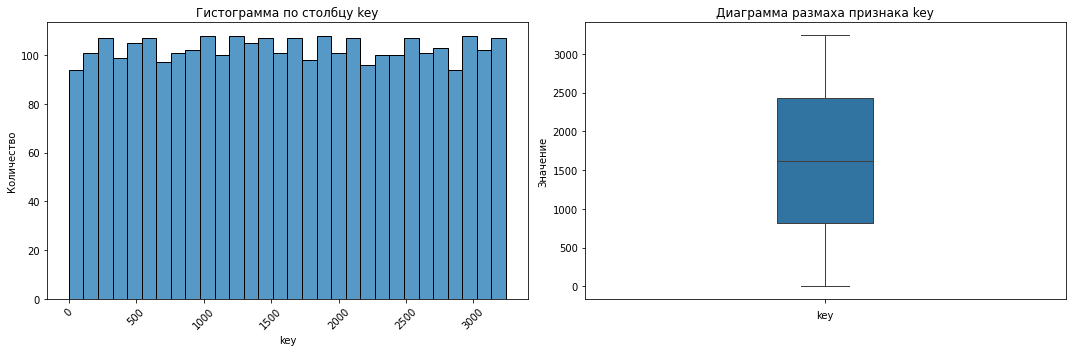

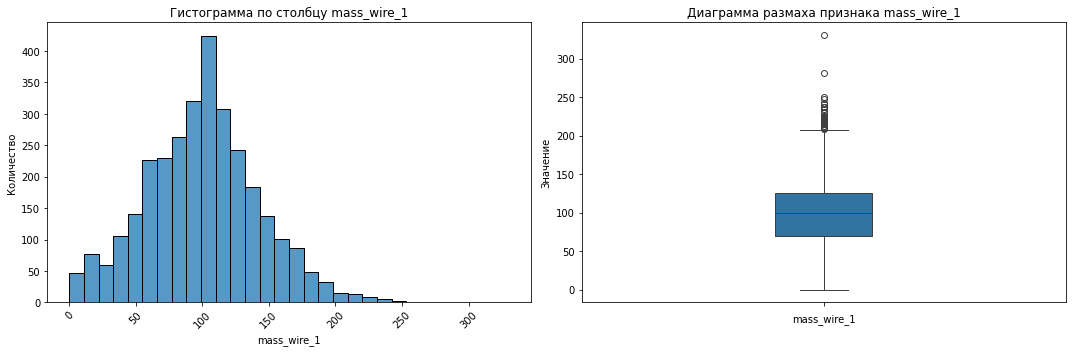

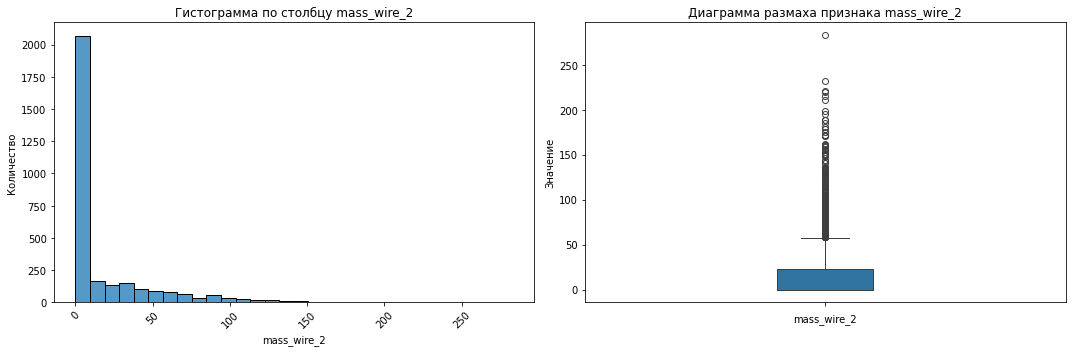

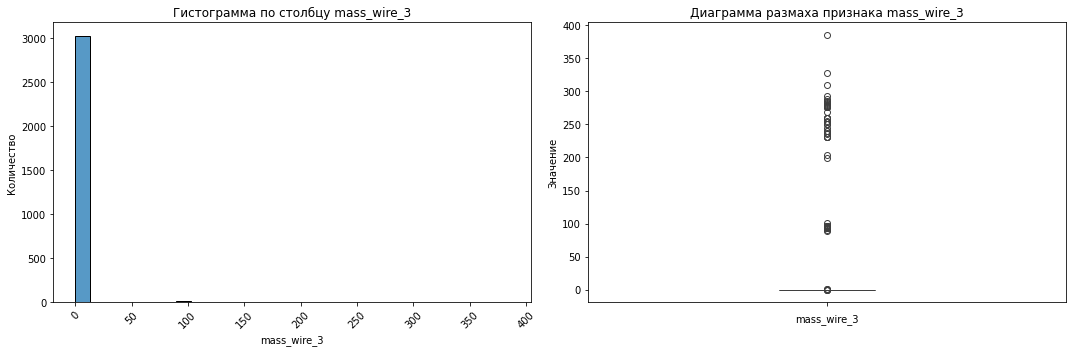

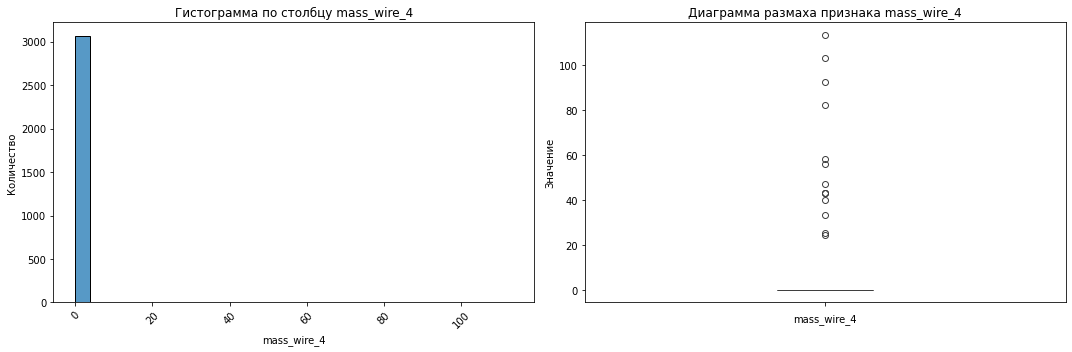

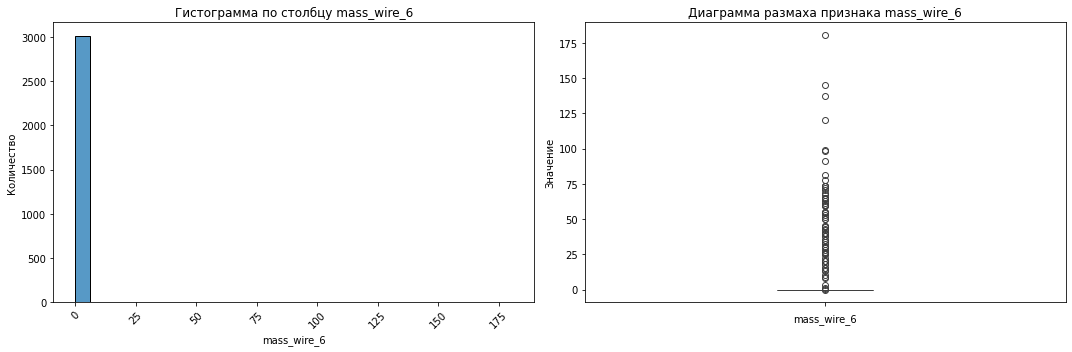

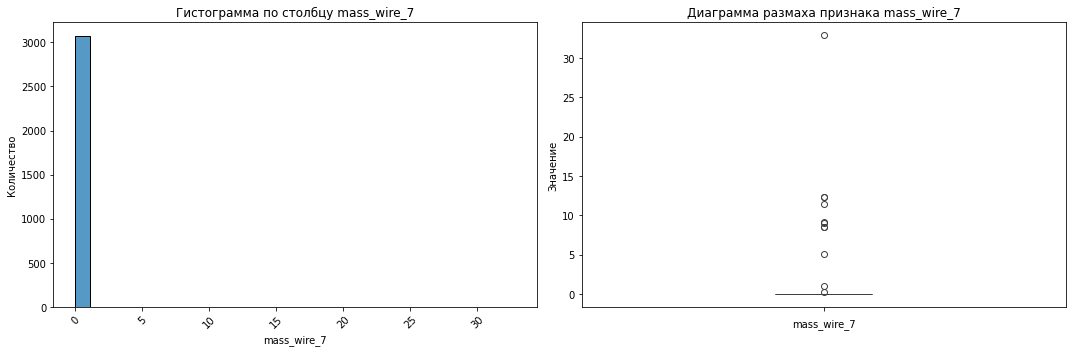

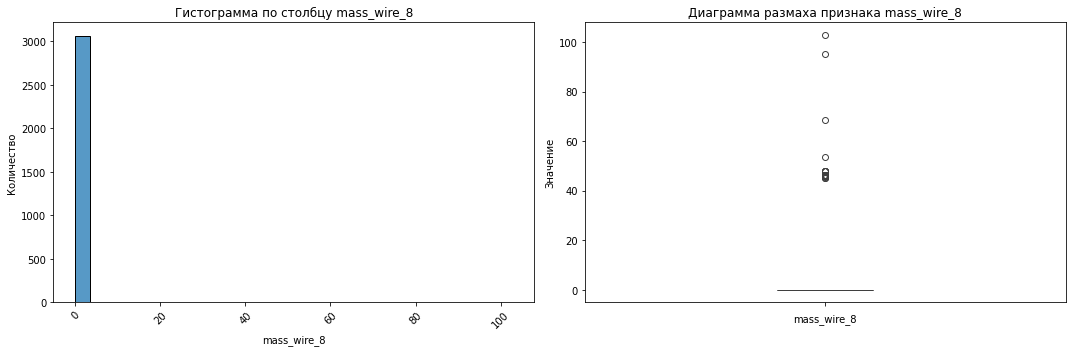

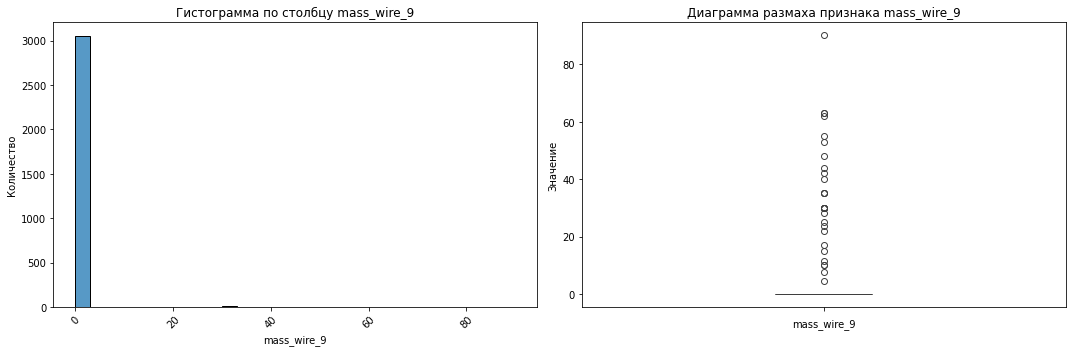

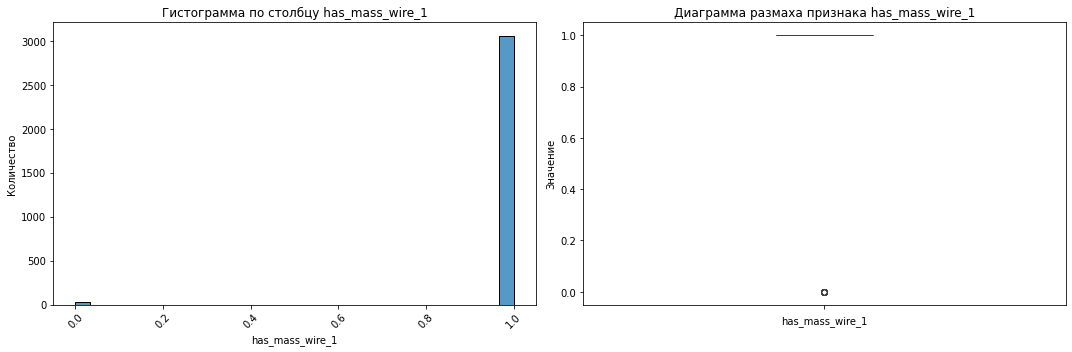

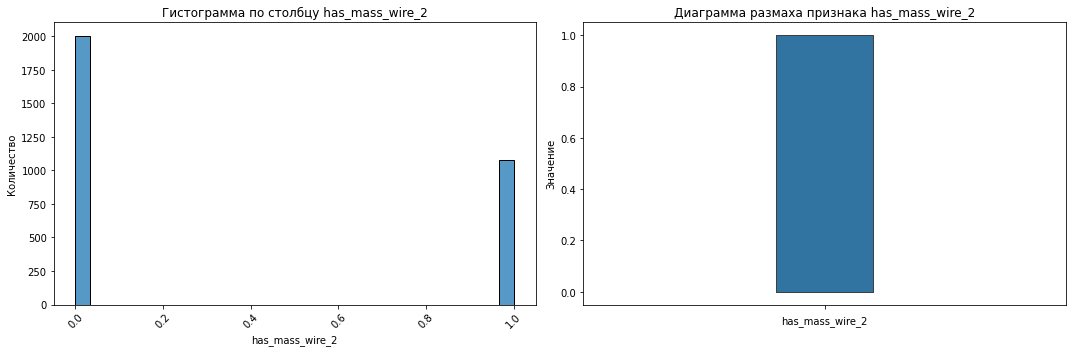

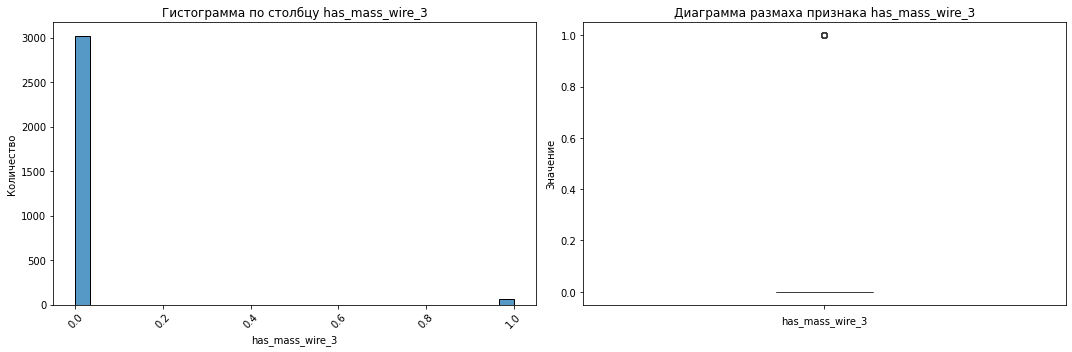

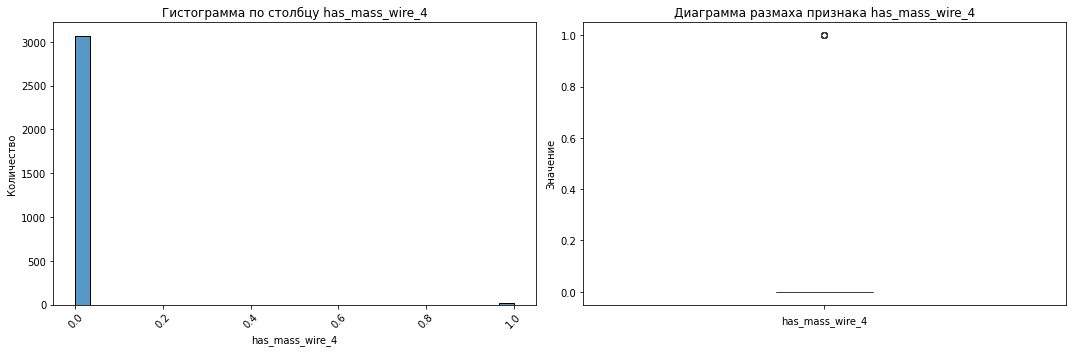

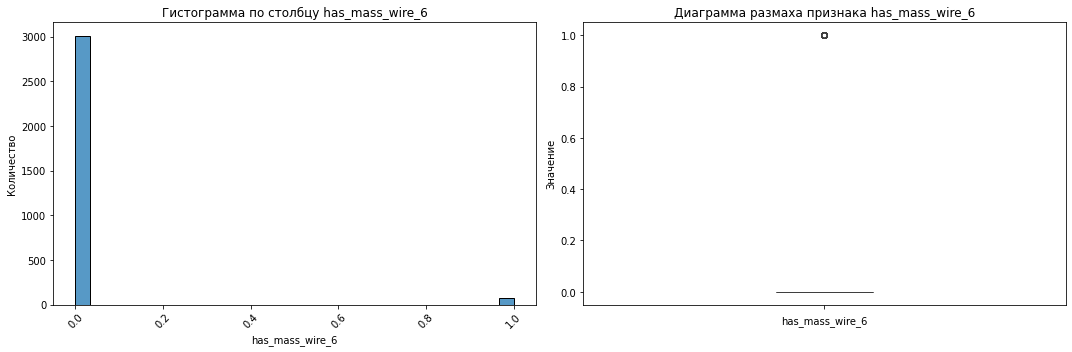

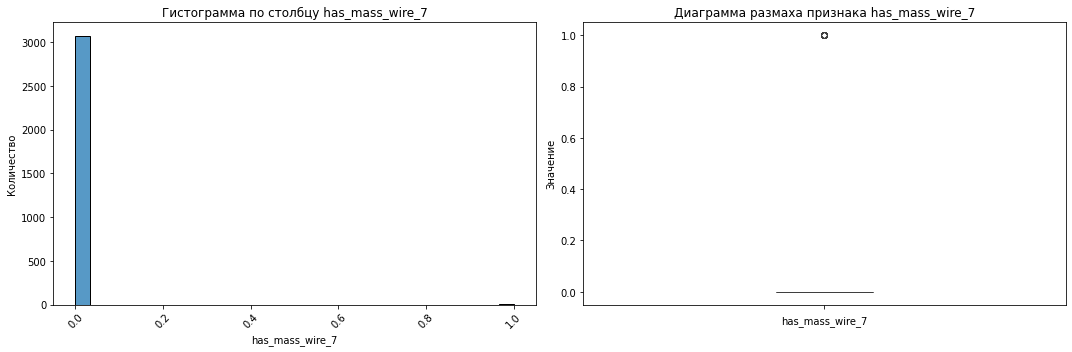

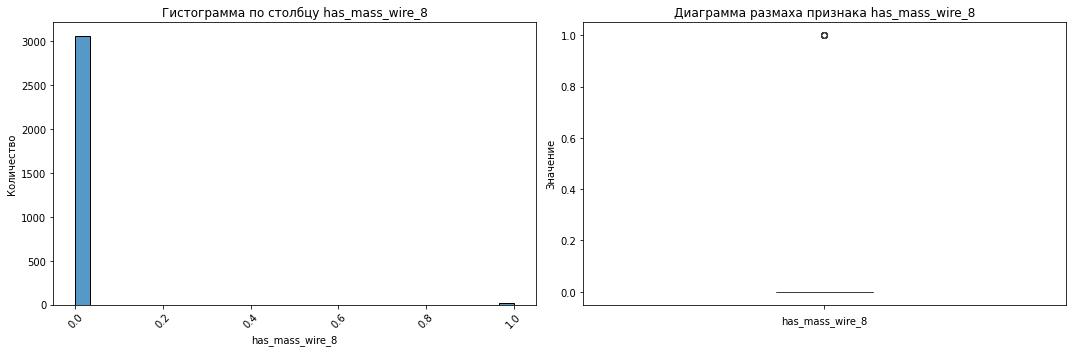

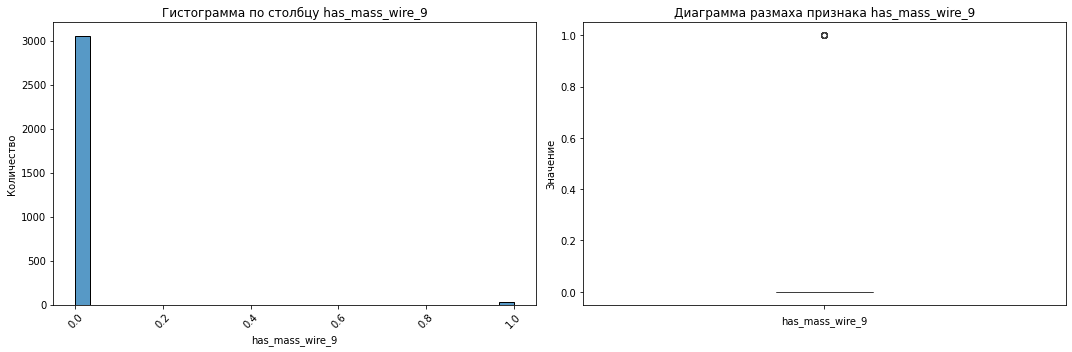

In [ ]:
lunge_analysis(data_wire, data_wire.columns)

Из диаграмм видно:
1. Wire 1 чаще всего равно 100.
2. Для Wire 2 из-за заполнение пропусков чаще всего встречается значение 0.

### Таблица data_wire_time

Теперь таблица data_wire_time. В ней содержится информация о времени добавлении проволоки.

In [ ]:
data_wire_time.head()

key               Wire 1               Wire 2 Wire 3 Wire 4 Wire 5 Wire 6  \
0    1  2019-05-03 11:06:19                 None   None   None   None   None   
1    2  2019-05-03 11:36:50                 None   None   None   None   None   
2    3  2019-05-03 12:11:46                 None   None   None   None   None   
3    4  2019-05-03 12:43:22                 None   None   None   None   None   
4    5  2019-05-03 13:20:44  2019-05-03 13:15:34   None   None   None   None   

  Wire 7 Wire 8 Wire 9  
0   None   None   None  
1   None   None   None  
2   None   None   None  
3   None   None   None  
4   None   None   None

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Переименуем столбцы.

In [ ]:
for i in range(1, 10):
  data_wire_time = data_wire_time.rename(columns={f'Wire {i}': f'time_wire_{i}'})

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          3081 non-null   int64 
 1   time_wire_1  3055 non-null   object
 2   time_wire_2  1079 non-null   object
 3   time_wire_3  63 non-null     object
 4   time_wire_4  14 non-null     object
 5   time_wire_5  1 non-null      object
 6   time_wire_6  73 non-null     object
 7   time_wire_7  11 non-null     object
 8   time_wire_8  19 non-null     object
 9   time_wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Тут тоже много столбцов с малым количеством значений.

In [ ]:
data_wire_time = data_wire_time.drop('time_wire_5', axis=1)

In [ ]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   key          3081 non-null   int64 
 1   time_wire_1  3055 non-null   object
 2   time_wire_2  1079 non-null   object
 3   time_wire_3  63 non-null     object
 4   time_wire_4  14 non-null     object
 5   time_wire_6  73 non-null     object
 6   time_wire_7  11 non-null     object
 7   time_wire_8  19 non-null     object
 8   time_wire_9  29 non-null     object
dtypes: int64(1), object(8)
memory usage: 216.8+ KB


Столбцы отрезаны. Теперь изменим тип данных

In [ ]:
date_columns = data_wire_time.drop('key', axis=1).columns

In [ ]:
data_wire_time[date_columns] = data_wire_time[date_columns].apply(pd.to_datetime)

Проанализируем данные.

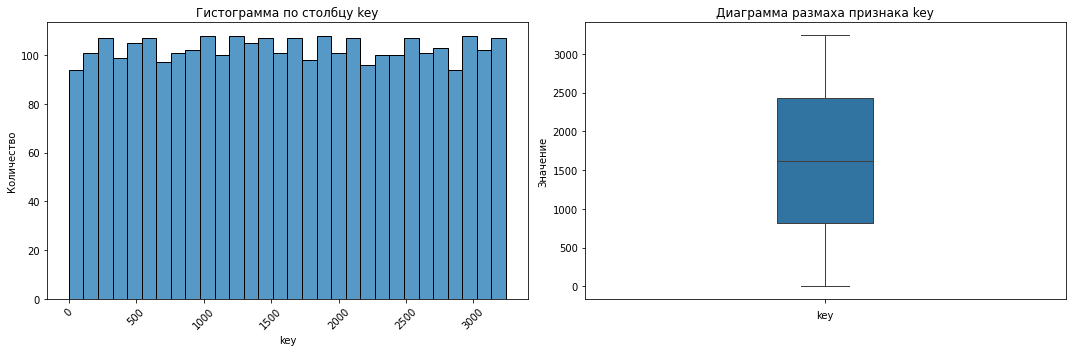

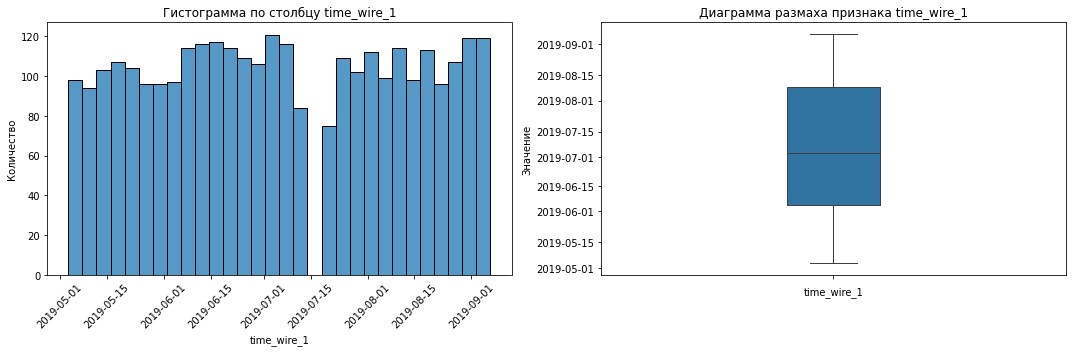

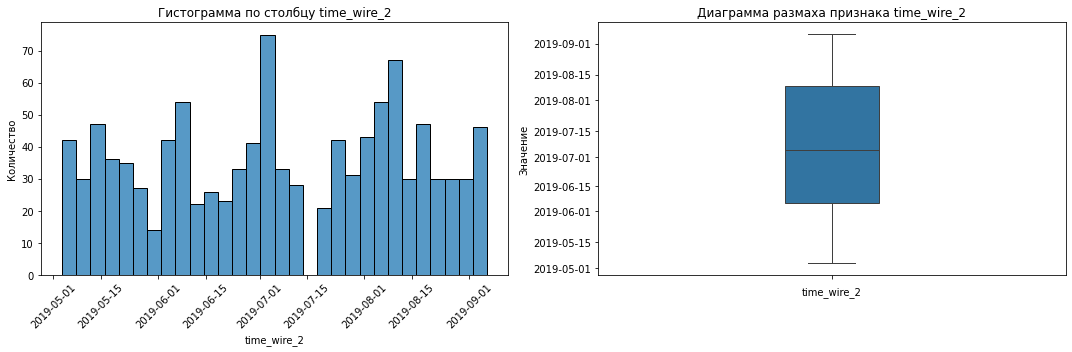

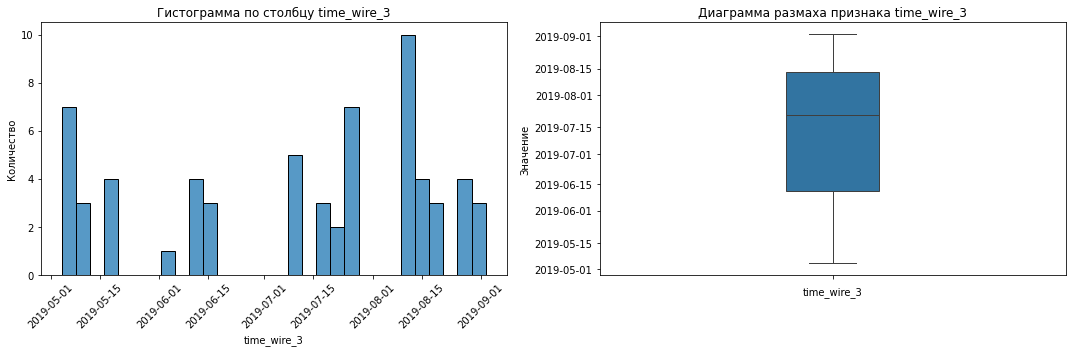

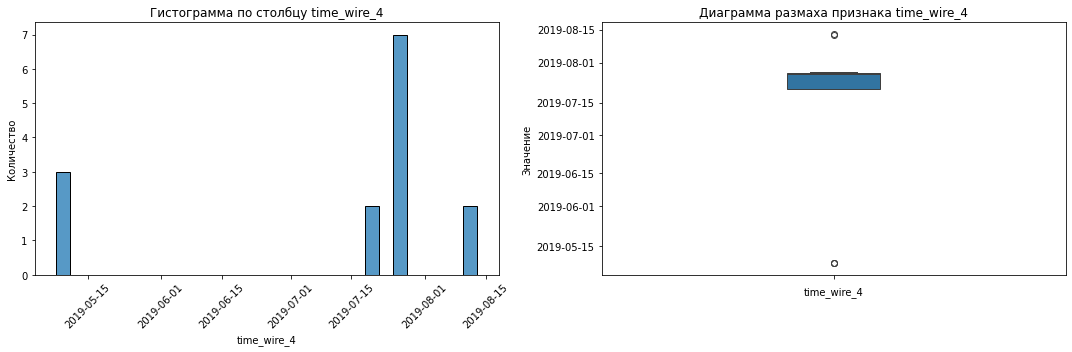

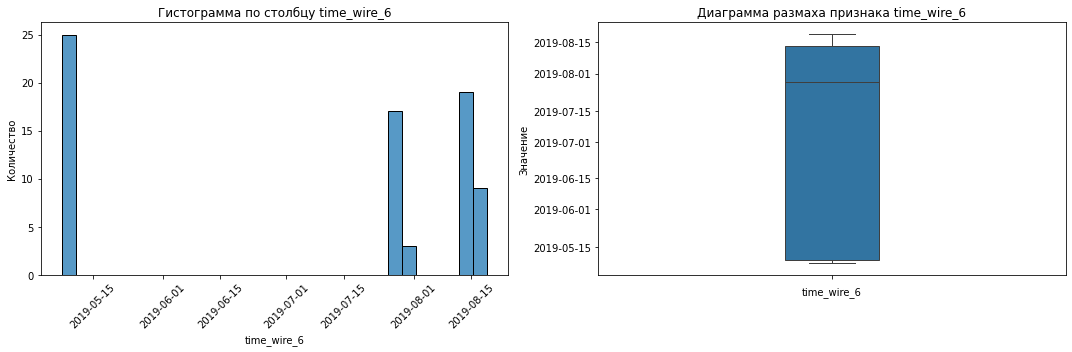

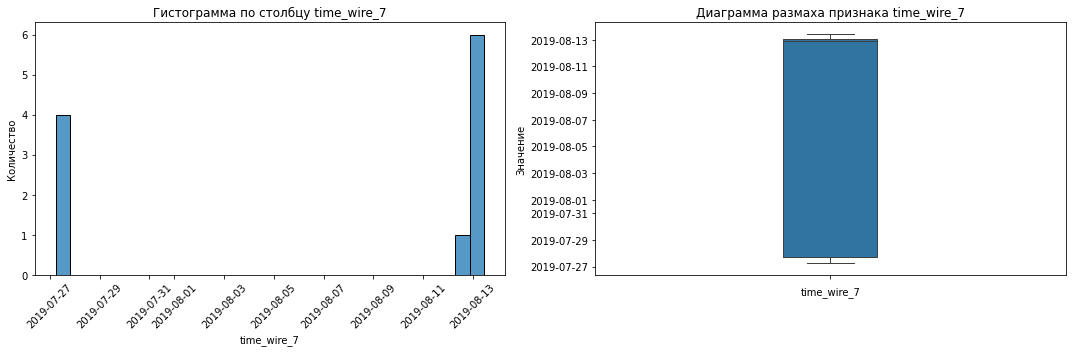

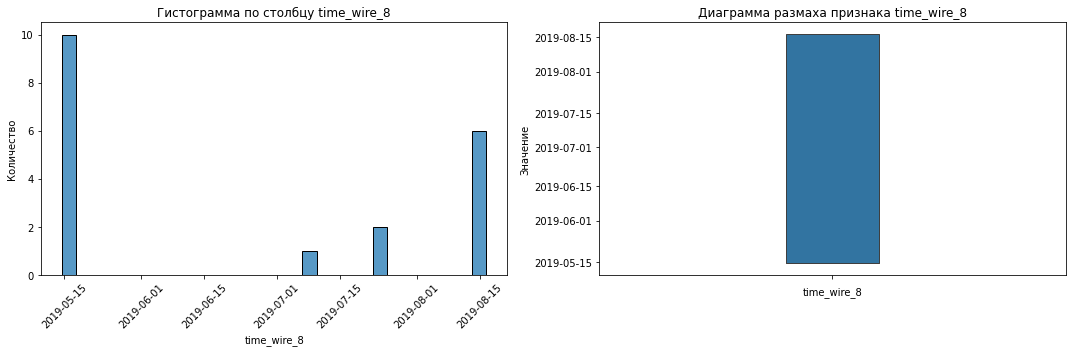

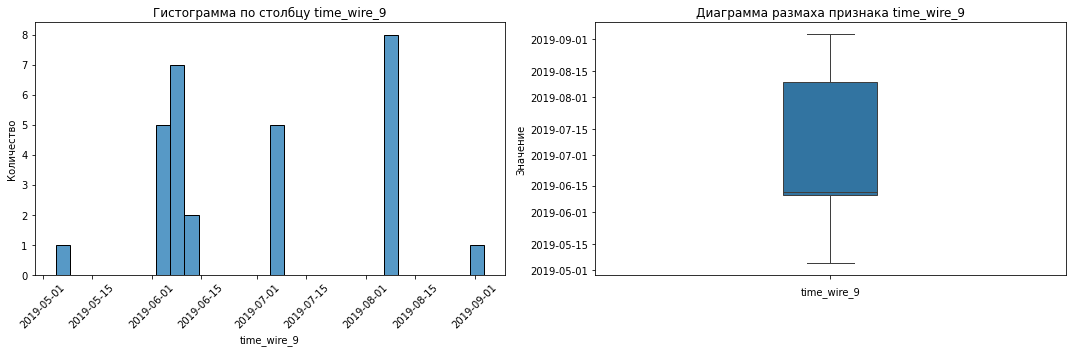

In [ ]:
lunge_analysis(data_wire_time, data_wire_time.columns)

Из диаграмм видно чаще всего добавляли проволоку wire 2 01.07.2019. По другим материалам трудно выявить зависимости.

### Сборка общего датафрейма

Соберем общий датафрейм

In [ ]:
#Перечень датафреймов для сборки в один для обучения
dataframe_list = [data_bulk,
                  data_bulk_time,
                  data_gas,
                  key_temp,
                  data_wire,
                  data_wire_time]

In [ ]:
for dataframe in dataframe_list:
    dataframe = dataframe.fillna(0)

In [ ]:
final_df = group_key
for dataframe in dataframe_list:
  final_df = final_df.merge(dataframe, on='key', how='inner')


In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2329 non-null   int64         
 1   active_power            2329 non-null   float64       
 2   apparent_power          2329 non-null   float64       
 3   expended_energy         2329 non-null   float64       
 4   heating_duration        2329 non-null   float64       
 5   interval_between_start  2329 non-null   float64       
 6   count_heating           2329 non-null   int64         
 7   reactive_power          2329 non-null   float64       
 8   first_heating_start     2329 non-null   datetime64[ns]
 9   last_heating_end        2329 non-null   datetime64[ns]
 10  mass_bulk_1             2329 non-null   float64       
 11  mass_bulk_2             2329 non-null   float64       
 12  mass_bulk_3             2329 non-null   float64 

In [ ]:
final_df.head()

key  active_power  apparent_power  expended_energy  heating_duration  \
0    1      3.036730        3.718736       770.282114            1098.0   
1    2      2.139408        2.588349       481.760005             811.0   
2    3      4.063641        5.019223       722.837668             655.0   
3    4      2.706489        3.400038       683.455597             741.0   
4    5      2.252950        2.816980       512.169934             869.0   

   interval_between_start  count_heating  reactive_power first_heating_start  \
0                   485.0              5        2.142821 2019-05-03 11:02:14   
1                   333.0              4        1.453357 2019-05-03 11:34:14   
2                   870.0              5        2.937457 2019-05-03 12:06:54   
3                   352.0              4        2.056992 2019-05-03 12:39:37   
4                   493.0              4        1.687991 2019-05-03 13:11:13   

     last_heating_end  ...  has_mass_wire_8  has_mass_wire_9  \
0 2019-05-03 11:28:37  ...              0.0              0.0   
1 2019-05-03 11:53:18  ...              0.0              0.0   
2 2019-05-03 12:32:19  ...              0.0              0.0   
3 2019-05-03 12:57:50  ...              0.0              0.0   
4 2019-05-03 13:33:55  ...              0.0              0.0   

          time_wire_1         time_wire_2  time_wire_3  time_wire_4  \
0 2019-05-03 11:06:19                 NaT          NaT          NaT   
1 2019-05-03 11:36:50                 NaT          NaT          NaT   
2 2019-05-03 12:11:46                 NaT          NaT          NaT   
3 2019-05-03 12:43:22                 NaT          NaT          NaT   
4 2019-05-03 13:20:44 2019-05-03 13:15:34          NaT          NaT   

   time_wire_6  time_wire_7  time_wire_8  time_wire_9  
0          NaT          NaT          NaT          NaT  
1          NaT          NaT          NaT          NaT  
2          NaT          NaT          NaT          NaT  
3          NaT          NaT          NaT          NaT  
4          NaT          NaT          NaT          NaT  

[5 rows x 81 columns]

In [ ]:
final_df[['start_time', 'end_time']].tail()

start_time            end_time
2324 2019-08-10 11:27:47 2019-08-10 11:50:47
2325 2019-08-10 11:56:48 2019-08-10 12:25:13
2326 2019-08-10 12:37:26 2019-08-10 12:53:28
2327 2019-08-10 12:58:11 2019-08-10 13:23:31
2328 2019-08-10 13:33:21 2019-08-10 13:58:58

Время начало замера и время окончания замера неравны, значит для всех партий есть как минимум два замера температуры.

Датафрейм собран, но в нём есть пропуски и стобцы, которые не могут быть использованы для обучения (с датами). Добавим ещё признаки в модель.

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   key                     2329 non-null   int64         
 1   active_power            2329 non-null   float64       
 2   apparent_power          2329 non-null   float64       
 3   expended_energy         2329 non-null   float64       
 4   heating_duration        2329 non-null   float64       
 5   interval_between_start  2329 non-null   float64       
 6   count_heating           2329 non-null   int64         
 7   reactive_power          2329 non-null   float64       
 8   first_heating_start     2329 non-null   datetime64[ns]
 9   last_heating_end        2329 non-null   datetime64[ns]
 10  mass_bulk_1             2329 non-null   float64       
 11  mass_bulk_2             2329 non-null   float64       
 12  mass_bulk_3             2329 non-null   float64 

In [ ]:
# Разница между добавление сыпучего вещества и началом нагрева
for i in [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]:
  final_df[f'diff_bulk_{i}_heat'] = (final_df[f'time_bulk_{i}'] - final_df['first_heating_start']).dt.total_seconds()

In [ ]:
# Разница между добавлением проволоки и началом нагрева
for i in [1, 2, 3, 4, 6, 7, 8, 9]:
  final_df[f'diff_wire_{i}_heat'] = (final_df[f'time_wire_{i}'] - final_df['first_heating_start']).dt.total_seconds()

In [ ]:
# Разница между концом нагрева и добавлением сыпучего материала
for i in [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]:
  final_df[f'diff_heat_bulk_{i}'] = (final_df['last_heating_end'] - final_df[f'time_bulk_{i}']).dt.total_seconds()

In [ ]:
# Разница между концом нагрева и добавлением проволоки
for i in [1, 2, 3, 4, 6, 7, 8, 9]:
  final_df[f'diff_heat_wire_{i}'] = (final_df['last_heating_end']- final_df[f'time_wire_{i}']).dt.total_seconds()

In [ ]:
# Общее количество добавленной проволоки
final_df['sum_wire'] = final_df[f'mass_wire_1'] + final_df[f'mass_wire_2'] + final_df[f'mass_wire_3'] + final_df[f'mass_wire_4'] + final_df[f'mass_wire_6'] + final_df[f'mass_wire_7'] + final_df[f'mass_wire_8'] + final_df[f'mass_wire_9']

In [ ]:
# Общее количество добавленного сыпучего материала
bulk_columns = ['mass_bulk_1', 'mass_bulk_2', 'mass_bulk_3', 'mass_bulk_4', 'mass_bulk_6', 'mass_bulk_7',
                'mass_bulk_9', 'mass_bulk_10', 'mass_bulk_11', 'mass_bulk_13',
                'mass_bulk_12', 'mass_bulk_14', 'mass_bulk_15']
final_df['sum_bulk'] = final_df[bulk_columns].sum(axis=1)

In [ ]:
# Общее количество добавленных материалов
final_df['total_add'] = final_df['sum_wire'] + final_df['sum_bulk']

In [ ]:
# Соотношение добавленных материалов и времени нагрева
final_df['ratio_add_time'] = final_df['total_add'] / final_df['heating_duration']

In [ ]:
# Интенсивность нагрева
final_df['heating_intensity'] = final_df['expended_energy'] / final_df['heating_duration'].clip(lower=0.001)

In [ ]:
# Соотношение количества проволоки и сыпучего материала
final_df['wire_to_bulk_ratio'] = final_df['sum_wire'] / final_df['sum_bulk'].clip(lower=0.001)

In [ ]:
# Умножение начальной температуры на самый массовый компонент №15
final_df[f'start_temp_mass_bulk_15'] = final_df['start_temp'] * final_df['mass_bulk_15']

In [ ]:
# Умножение начальной температуры на самый массовый компонент №14
final_df[f'start_temp_mass_bulk_14'] = final_df['start_temp'] * final_df['mass_bulk_14']

In [ ]:
# Умножение начальной температуры на самую массовую проволоку №1
final_df[f'start_temp_mass_wire_1'] = final_df['start_temp'] * final_df['mass_wire_1']

In [ ]:
# Соотношение добавленных материалов ко времени нагрева
final_df['mass_per_heating_time'] = final_df['total_add'] / final_df['heating_duration'].clip(lower=0.001)

Проверим результат

In [ ]:
final_df.head()

key  active_power  apparent_power  expended_energy  heating_duration  \
0    1      3.036730        3.718736       770.282114            1098.0   
1    2      2.139408        2.588349       481.760005             811.0   
2    3      4.063641        5.019223       722.837668             655.0   
3    4      2.706489        3.400038       683.455597             741.0   
4    5      2.252950        2.816980       512.169934             869.0   

   interval_between_start  count_heating  reactive_power first_heating_start  \
0                   485.0              5        2.142821 2019-05-03 11:02:14   
1                   333.0              4        1.453357 2019-05-03 11:34:14   
2                   870.0              5        2.937457 2019-05-03 12:06:54   
3                   352.0              4        2.056992 2019-05-03 12:39:37   
4                   493.0              4        1.687991 2019-05-03 13:11:13   

     last_heating_end  ...   sum_wire  sum_bulk   total_add  ratio_add_time  \
0 2019-05-03 11:28:37  ...  60.059998     553.0  613.059998        0.558342   
1 2019-05-03 11:53:18  ...  96.052315     582.0  678.052315        0.836069   
2 2019-05-03 12:32:19  ...  91.160157     544.0  635.160157        0.969710   
3 2019-05-03 12:57:50  ...  89.063515     595.0  684.063515        0.923163   
4 2019-05-03 13:33:55  ...  98.352796     584.0  682.352796        0.785216   

   heating_intensity  wire_to_bulk_ratio  start_temp_mass_bulk_15  \
0           0.701532            0.108608                 241934.0   
1           0.594032            0.165038                 243474.0   
2           1.103569            0.167574                 244188.0   
3           0.922342            0.149687                 246554.0   
4           0.589379            0.168412                 239552.0   

   start_temp_mass_bulk_14  start_temp_mass_wire_1  mass_per_heating_time  
0                 235650.0            94354.256858               0.558342  
1                 235569.0           151858.710015               0.836069  
2                 242592.0           145491.610572               0.969710  
3                 244953.0           142590.687515               0.923163  
4                 237976.0           140639.459936               0.785216  

[5 rows x 135 columns]

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Columns: 135 entries, key to mass_per_heating_time
dtypes: datetime64[ns](26), float64(107), int64(2)
memory usage: 2.4 MB


Признаки добавлены. Теперь удалим неинформативные столбцы, а именно столбцы с датами.

In [ ]:
non_datetime_columns = [col for col in final_df.columns
                        if final_df[col].dtype != 'datetime64[ns]']

# Создание датафрейма только с не-datetime столбцами
df_for_corr = final_df[non_datetime_columns]

In [ ]:
df_for_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Columns: 109 entries, key to mass_per_heating_time
dtypes: float64(107), int64(2)
memory usage: 2.0 MB


Удалим строки, в которых конечная температура отсутствует

In [ ]:
filtered_df = df_for_corr[df_for_corr['end_temp'].notna()].copy()

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Columns: 109 entries, key to mass_per_heating_time
dtypes: float64(107), int64(2)
memory usage: 2.0 MB


Пропуски заполним нулями.

In [ ]:
filtered_df = filtered_df.fillna(0)

### Целевой признак

Посмотрим на распределение целевого признака

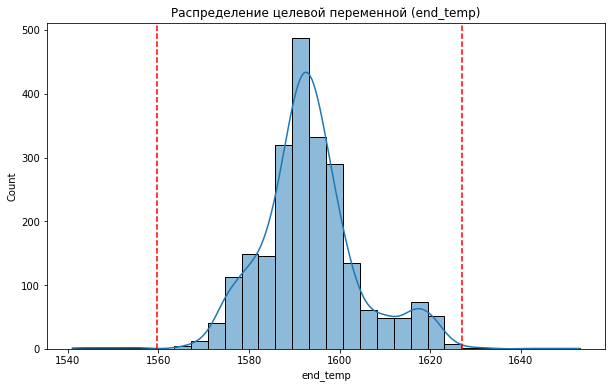

Количество выбросов: 16 из 2329 (0.69%)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Анализ распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['end_temp'], bins=30, kde=True)
plt.title('Распределение целевой переменной (end_temp)')
plt.axvline(np.mean(filtered_df['end_temp']) + 3*np.std(filtered_df['end_temp']), color='r', linestyle='--')
plt.axvline(np.mean(filtered_df['end_temp']) - 3*np.std(filtered_df['end_temp']), color='r', linestyle='--')
plt.show()

# Определение выбросов по правилу 3-сигма
mean_y = np.mean(filtered_df['end_temp'])
std_y = np.std(filtered_df['end_temp'])
upper_bound = mean_y + 3 * std_y
lower_bound = mean_y - 3 * std_y
outliers = (filtered_df['end_temp'] > upper_bound) | (filtered_df['end_temp'] < lower_bound)
print(f"Количество выбросов: {sum(outliers)} из {len(filtered_df['end_temp'])} ({sum(outliers)/len(filtered_df['end_temp'])*100:.2f}%)")

Очевидно, есть выбросы, но их немного. Обработаем их, но чтобы не терять строки, приравняем выбросы к граничным значениям.

In [ ]:
raw_filtered_df = filtered_df.copy()

In [ ]:
# Применение винсоризации к признаку end_temp
filtered_df.loc[filtered_df['end_temp'] > upper_bound, 'end_temp'] = upper_bound
filtered_df.loc[filtered_df['end_temp'] < lower_bound, 'end_temp'] = lower_bound

Исходный датафрейм - мин: 1541.0, макс: 1653.0
После винсоризации - мин: 1559.7698618258146, макс: 1626.9609239191404


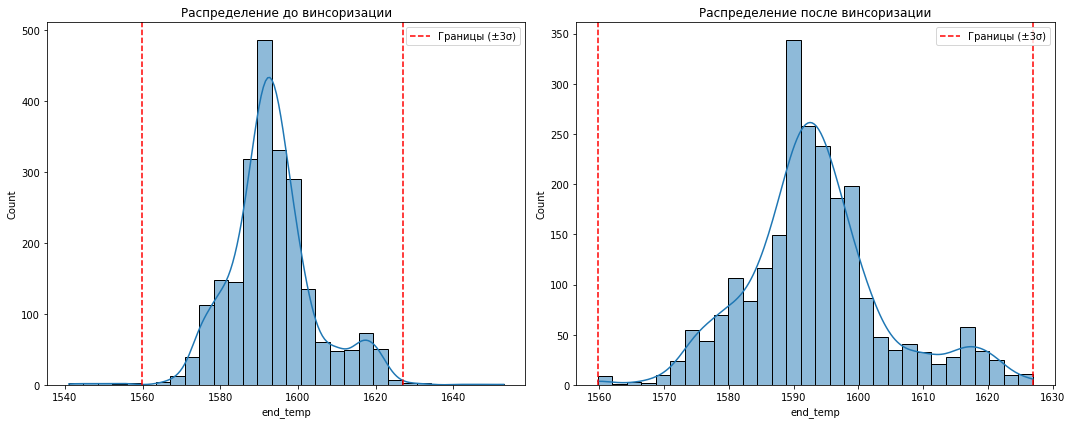

In [ ]:
# Проверка результатов
print(f"Исходный датафрейм - мин: {raw_filtered_df['end_temp'].min()}, макс: {raw_filtered_df['end_temp'].max()}")
print(f"После винсоризации - мин: {filtered_df['end_temp'].min()}, макс: {filtered_df['end_temp'].max()}")

# Визуализация для сравнения
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Исходное распределение
sns.histplot(raw_filtered_df['end_temp'], bins=30, kde=True, ax=ax1)
ax1.set_title('Распределение до винсоризации')
ax1.axvline(upper_bound, color='r', linestyle='--', label='Границы (±3σ)')
ax1.axvline(lower_bound, color='r', linestyle='--')
ax1.legend()

# Распределение после винсоризации
sns.histplot(filtered_df['end_temp'], bins=30, kde=True, ax=ax2)
ax2.set_title('Распределение после винсоризации')
ax2.axvline(upper_bound, color='r', linestyle='--', label='Границы (±3σ)')
ax2.axvline(lower_bound, color='r', linestyle='--')
ax2.legend()

plt.tight_layout()
plt.show()

Теперь проанализируем распределение признаков в конечной таблице

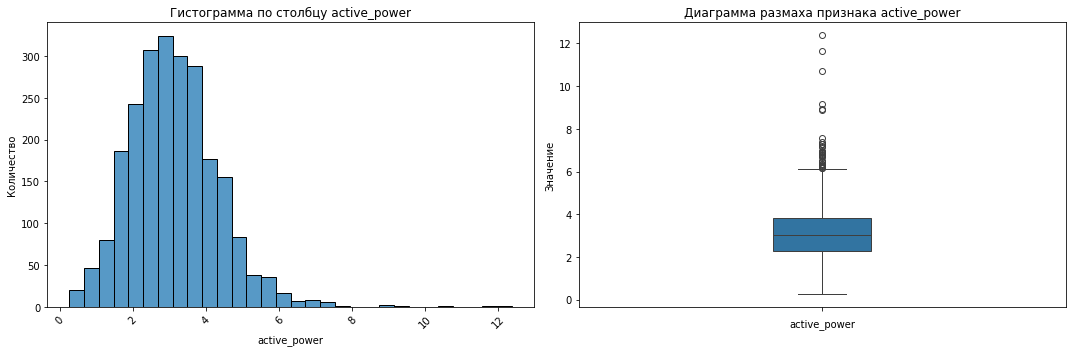

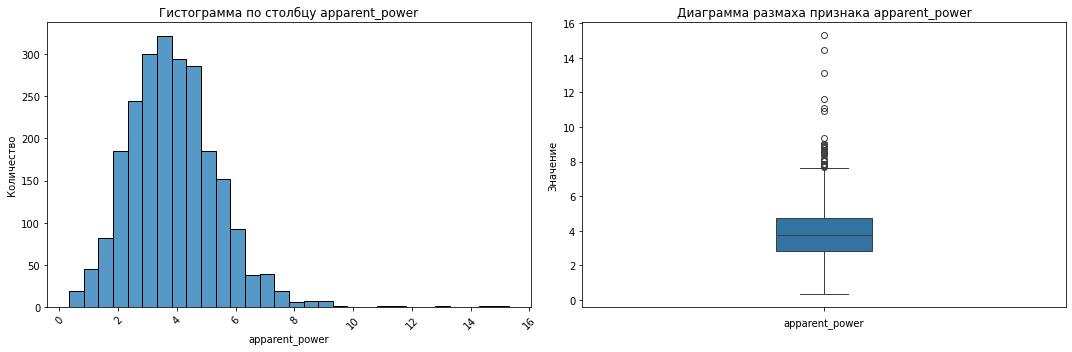

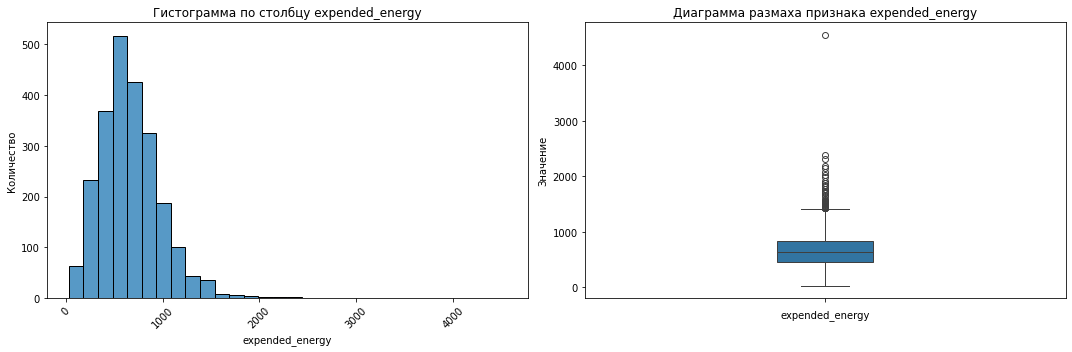

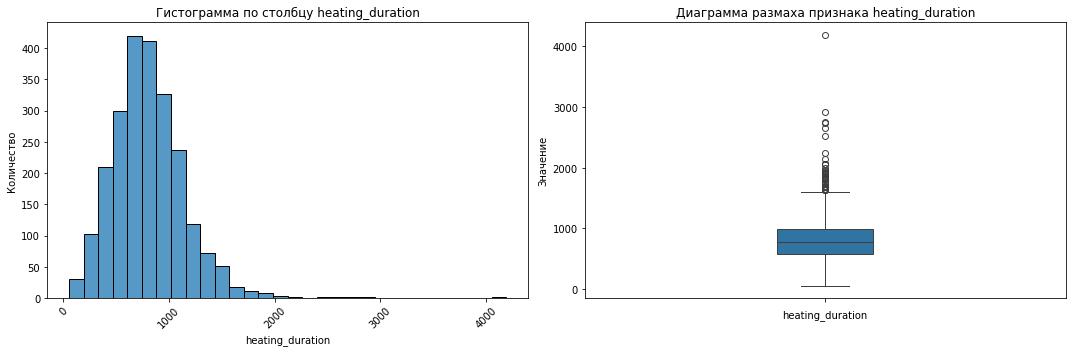

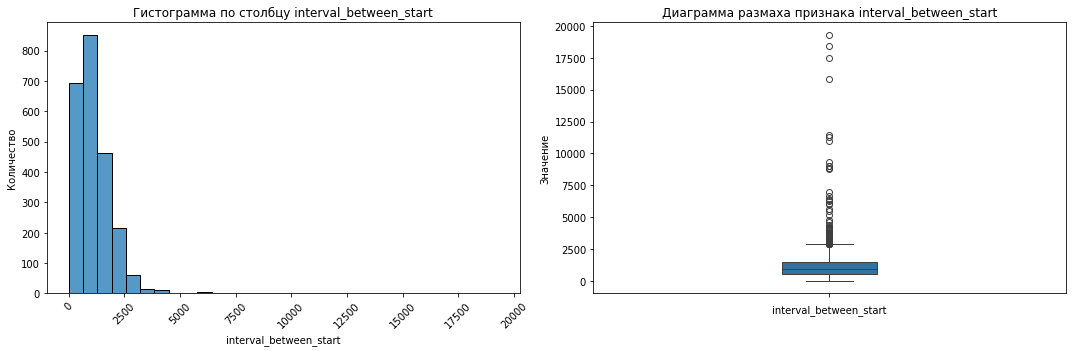

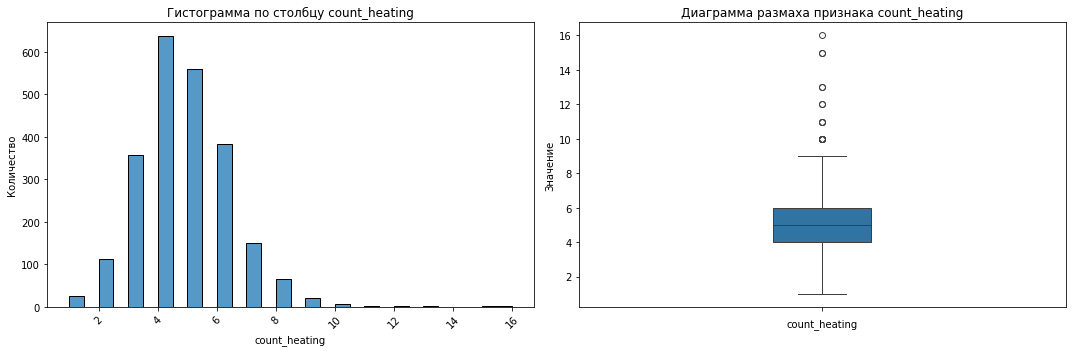

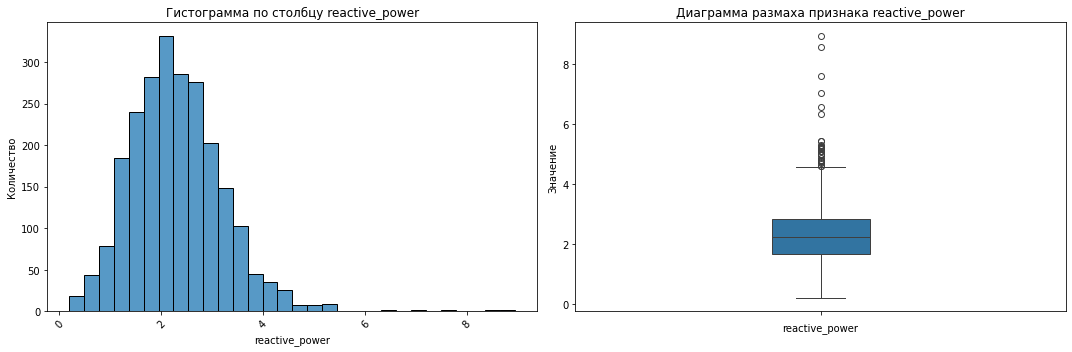

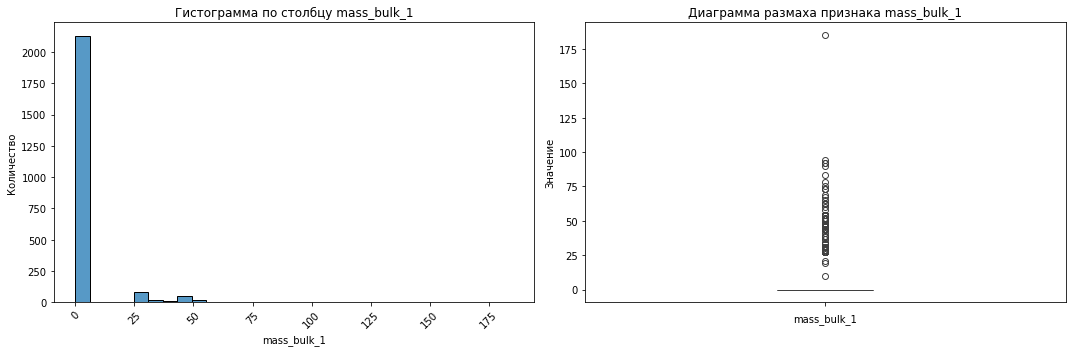

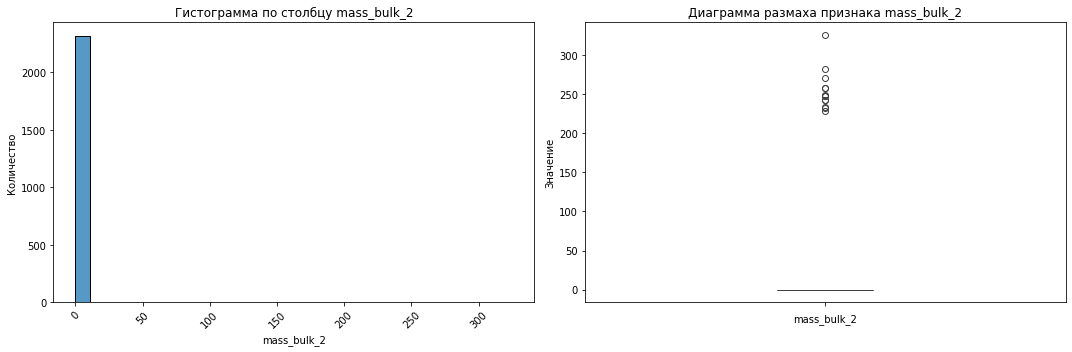

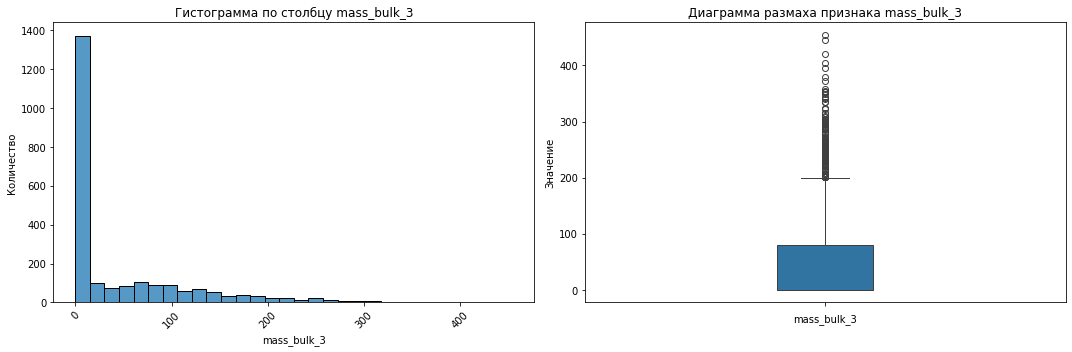

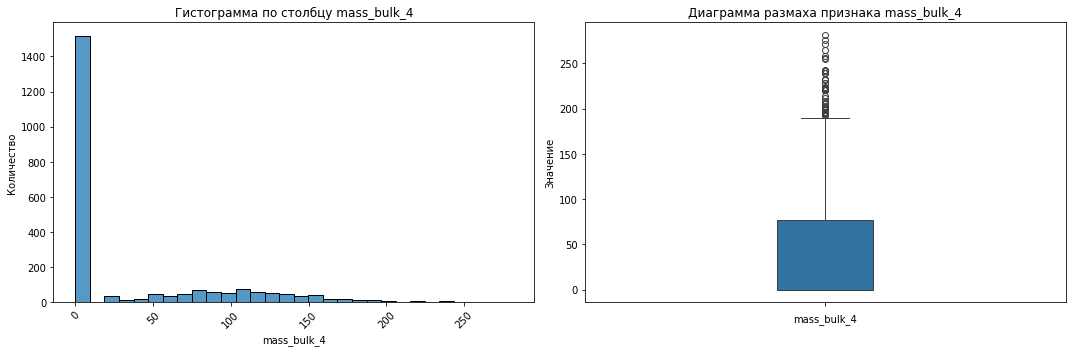

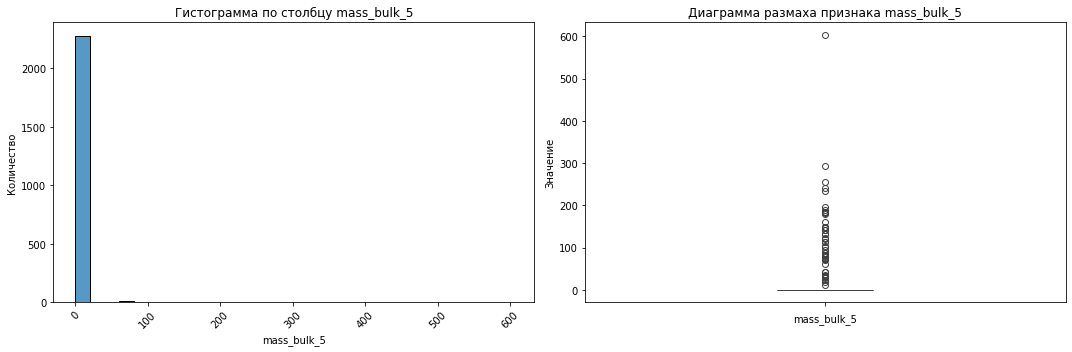

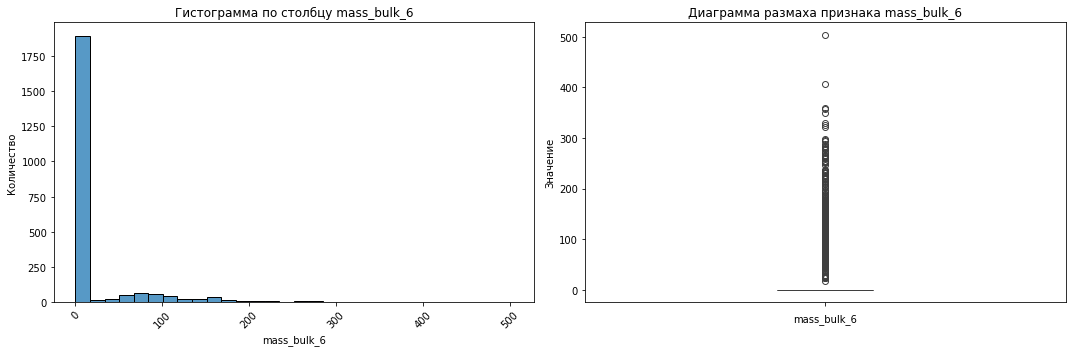

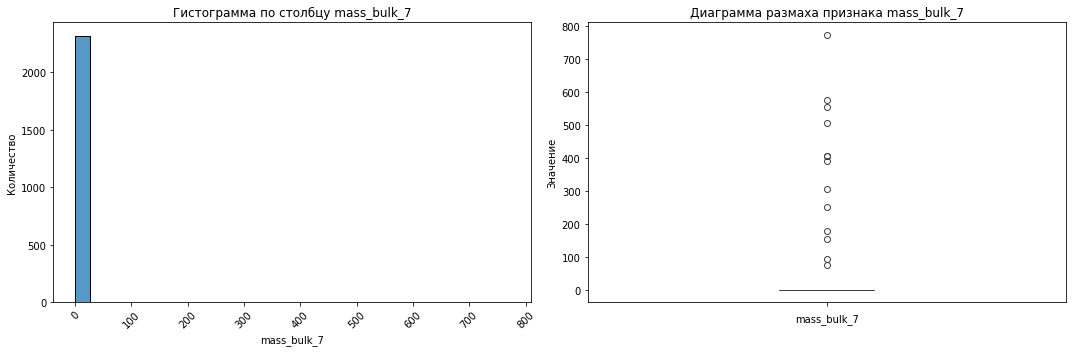

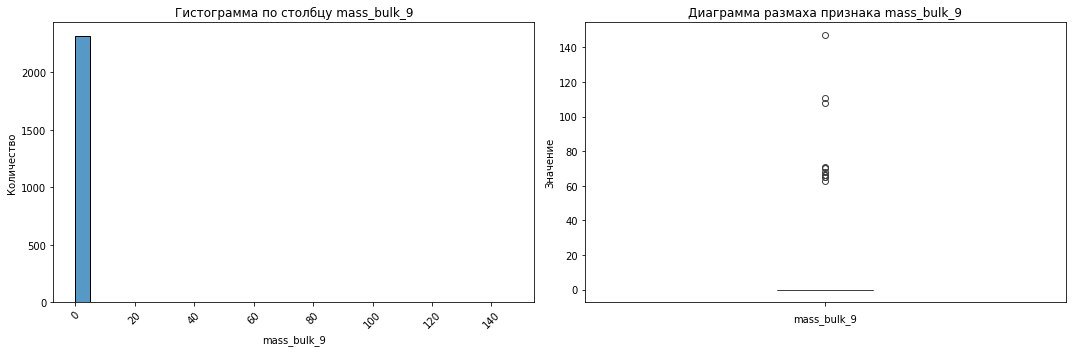

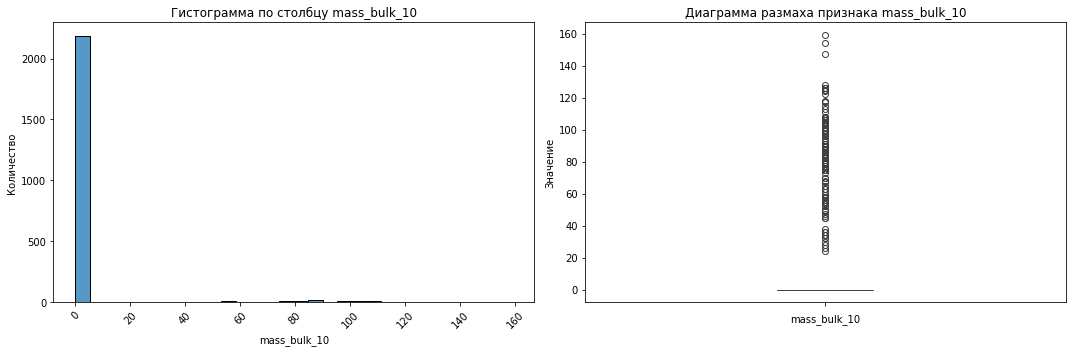

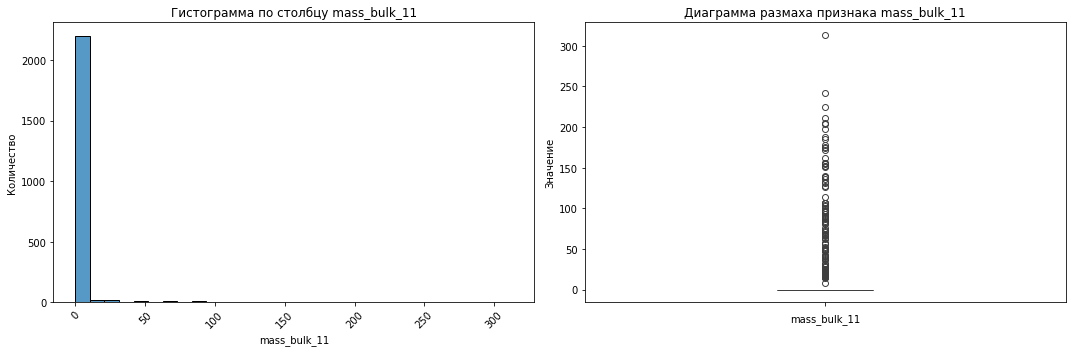

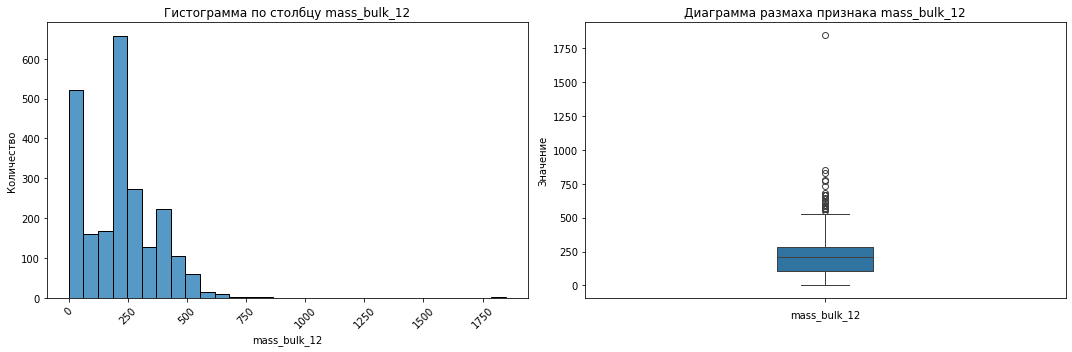

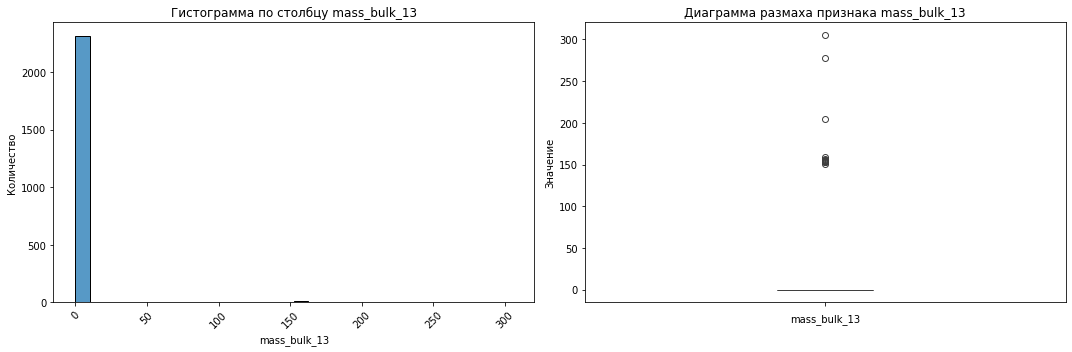

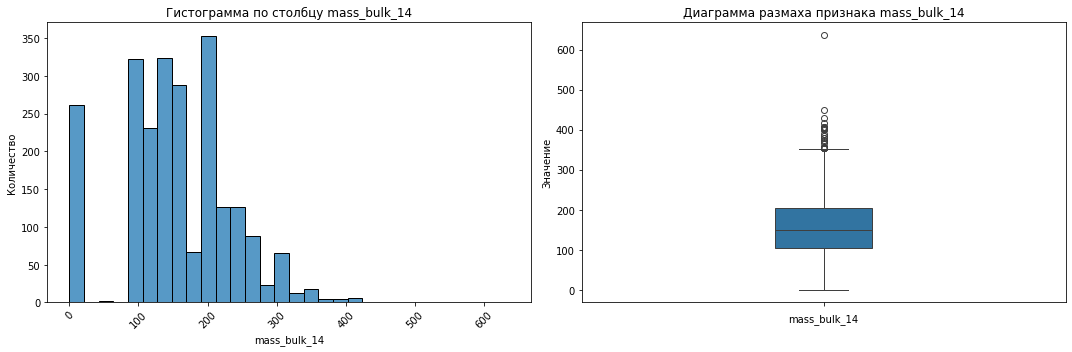

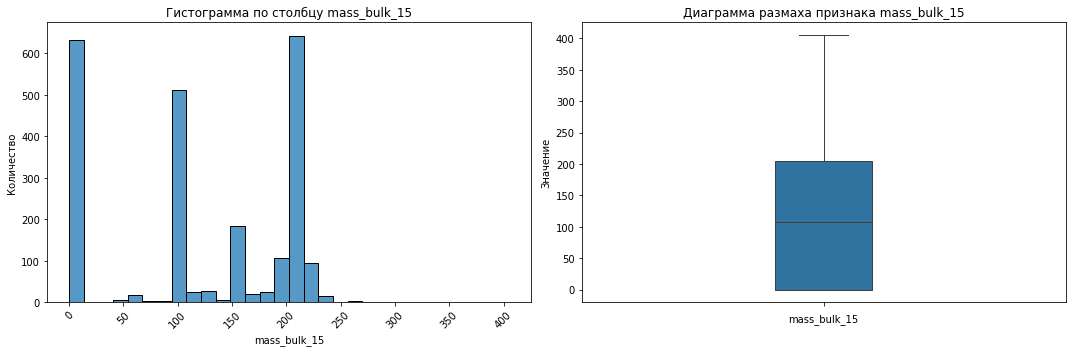

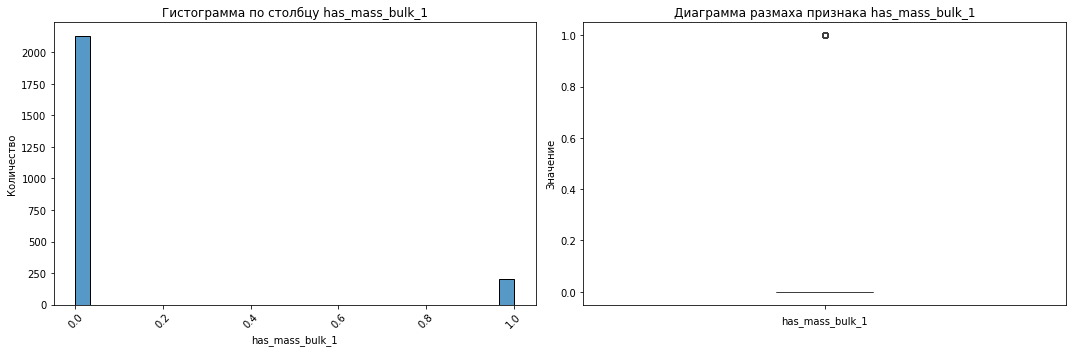

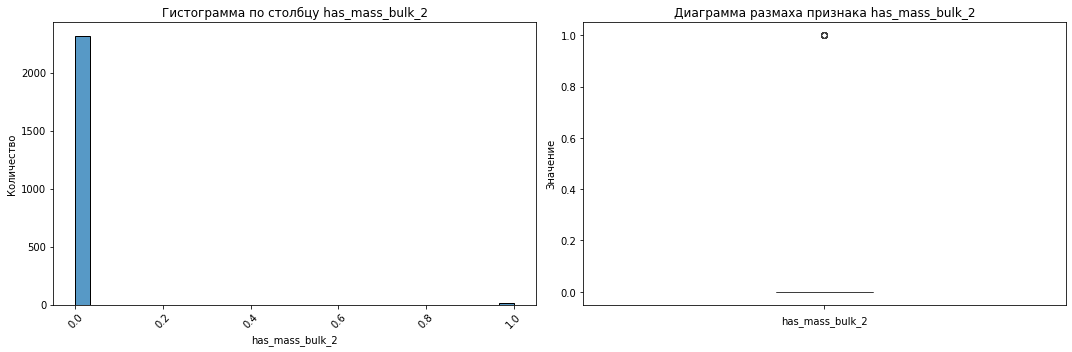

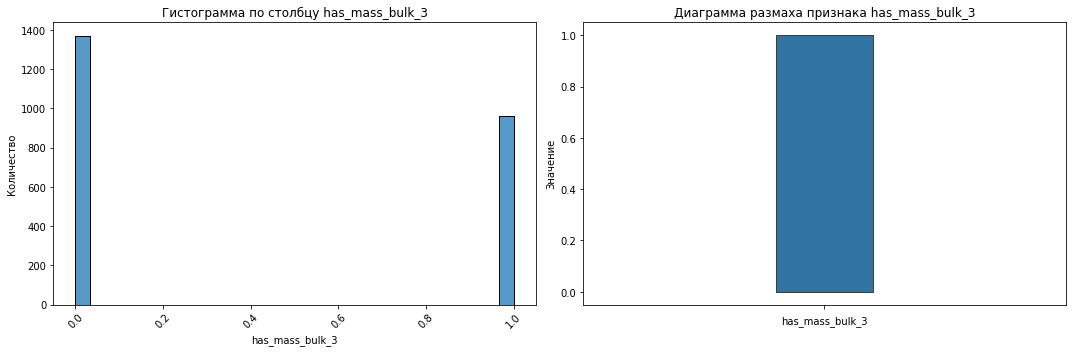

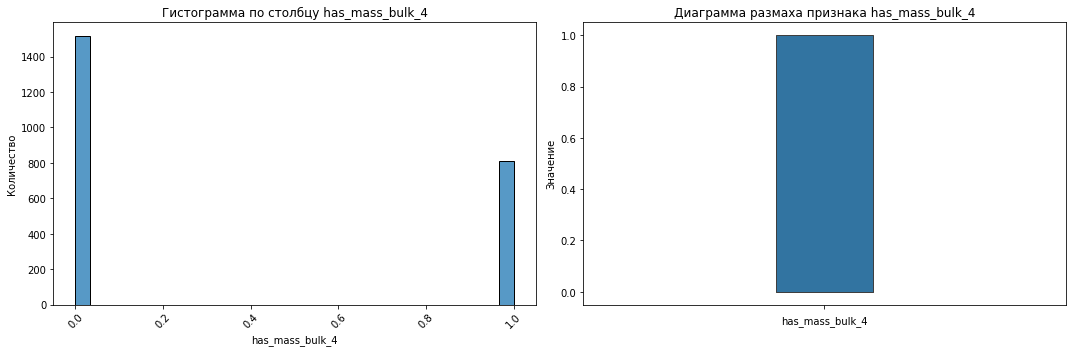

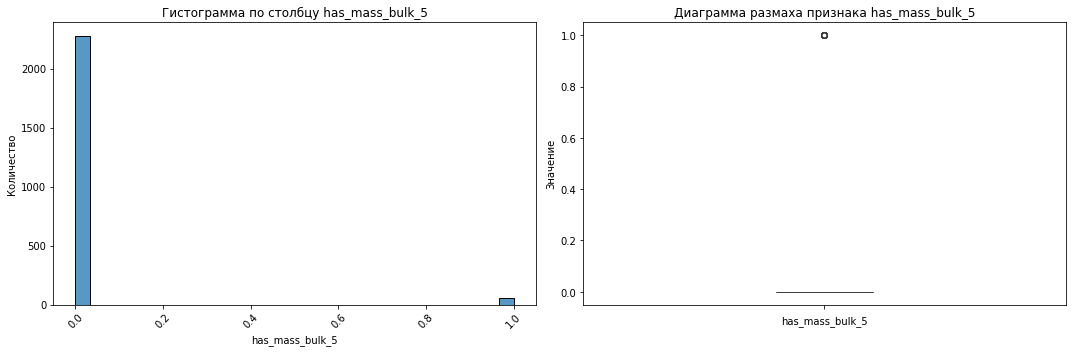

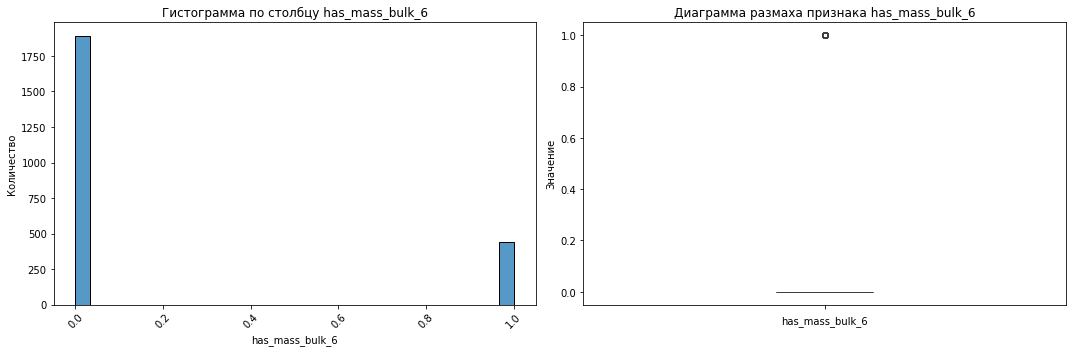

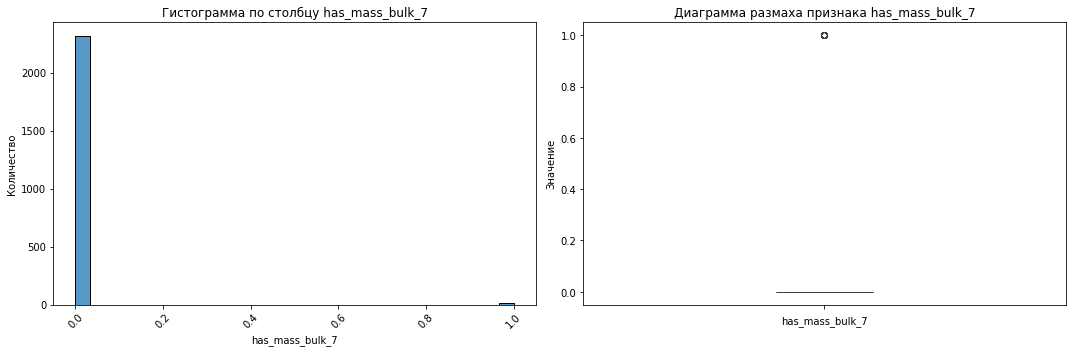

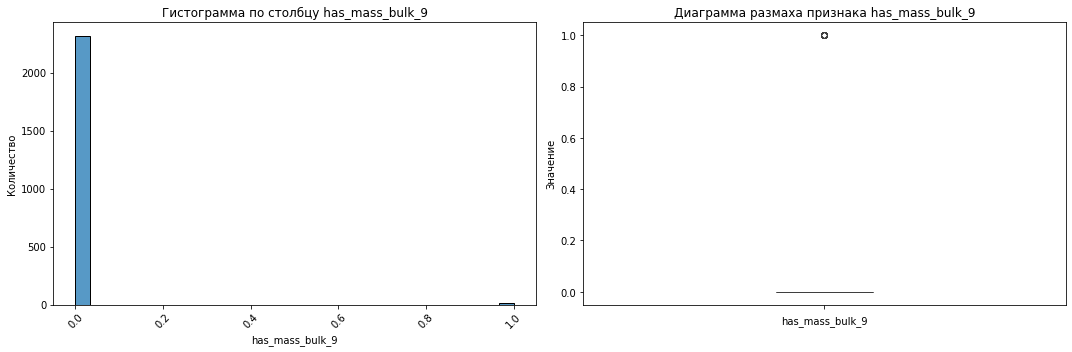

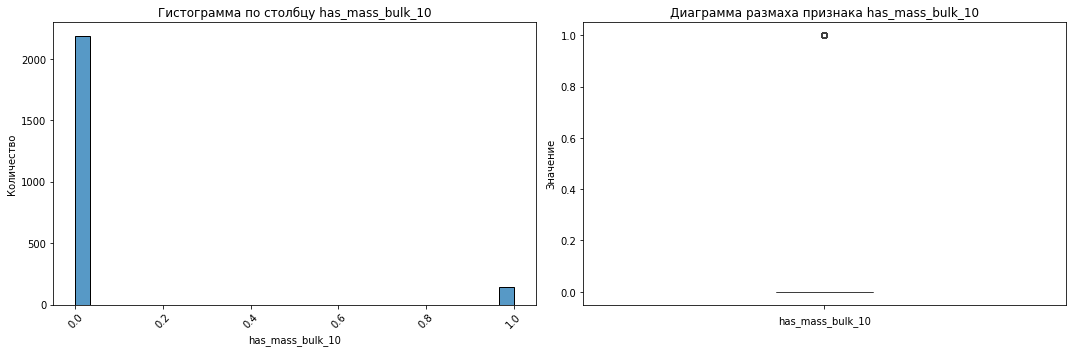

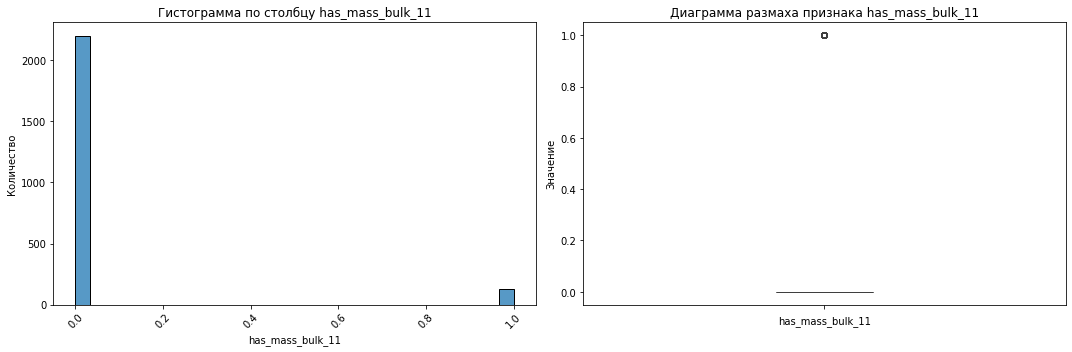

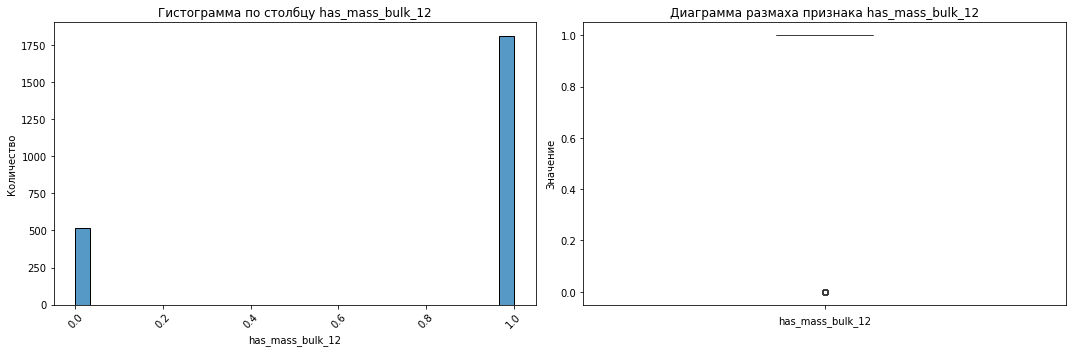

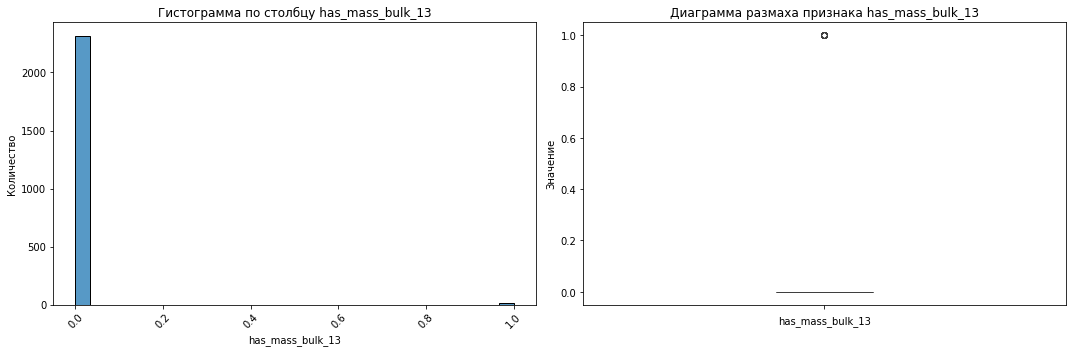

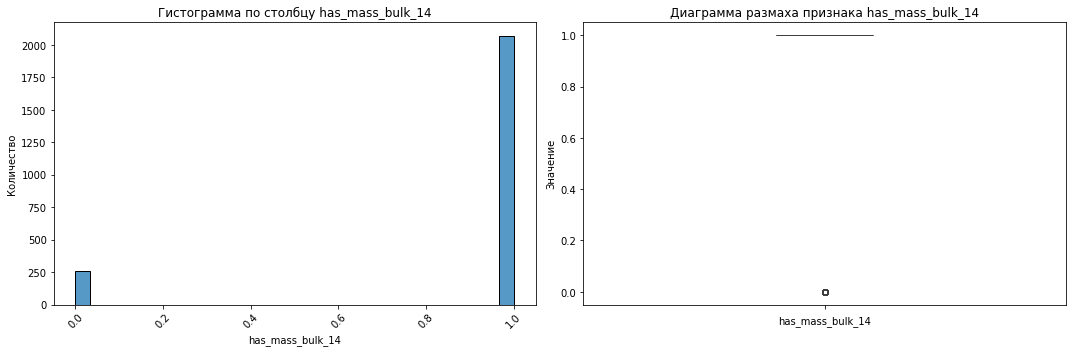

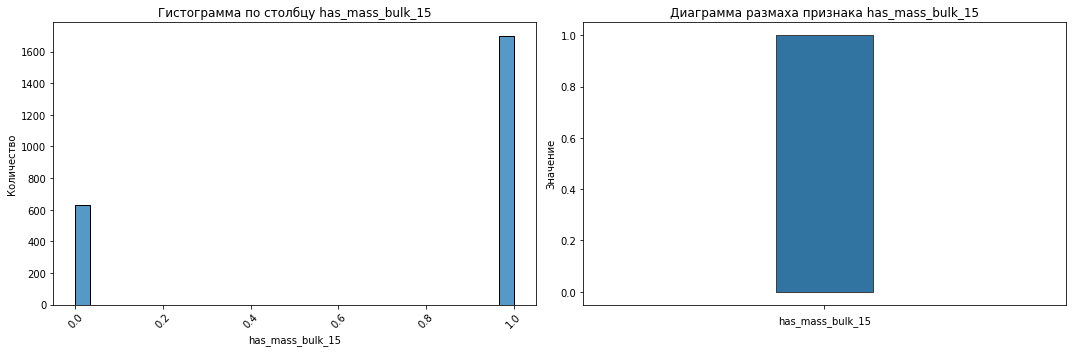

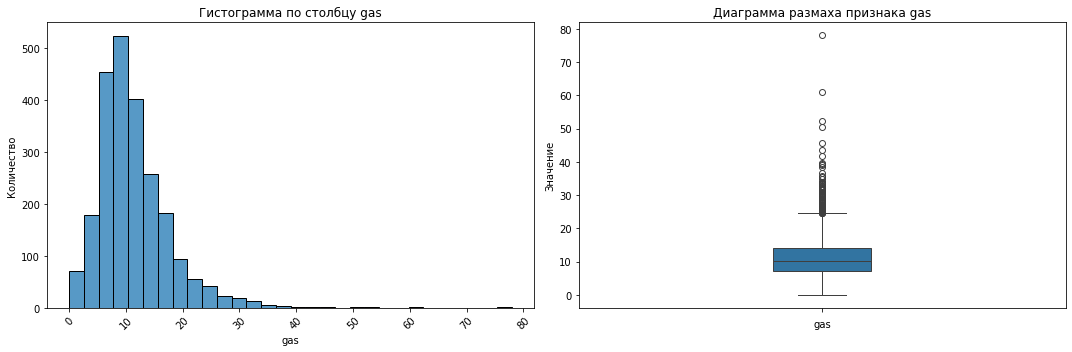

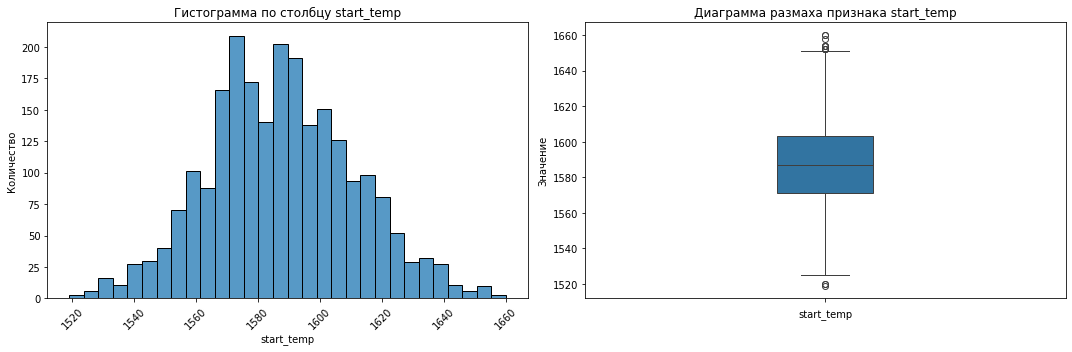

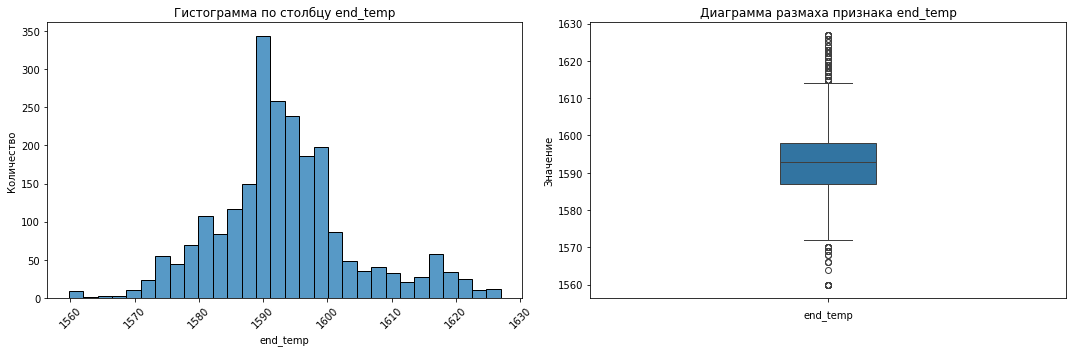

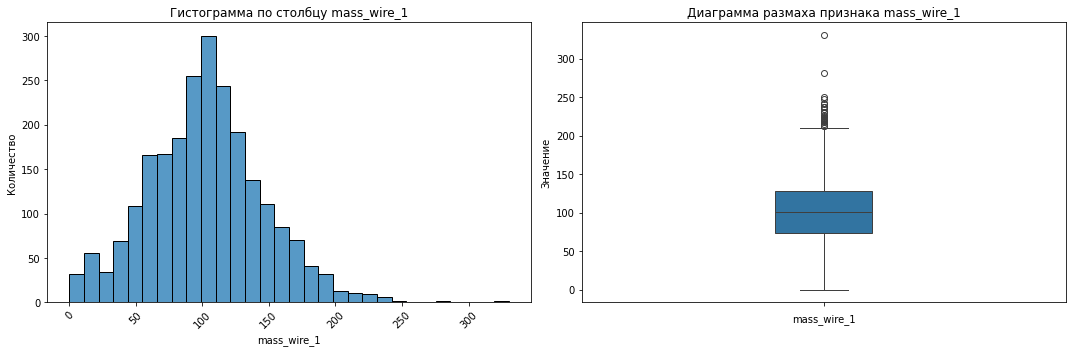

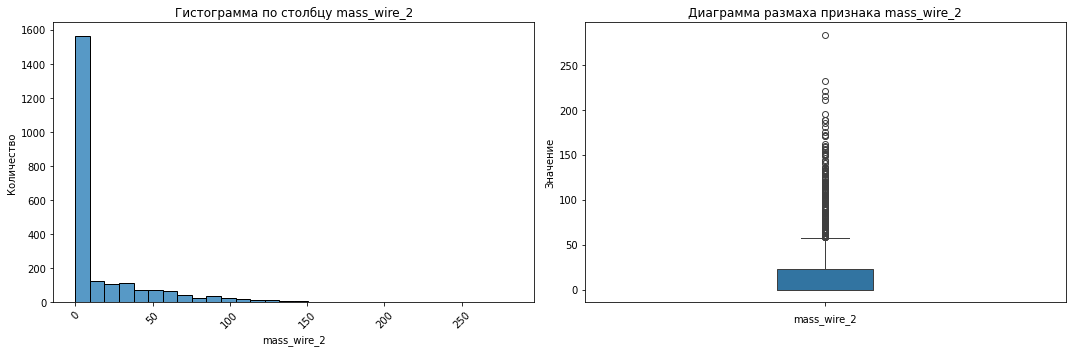

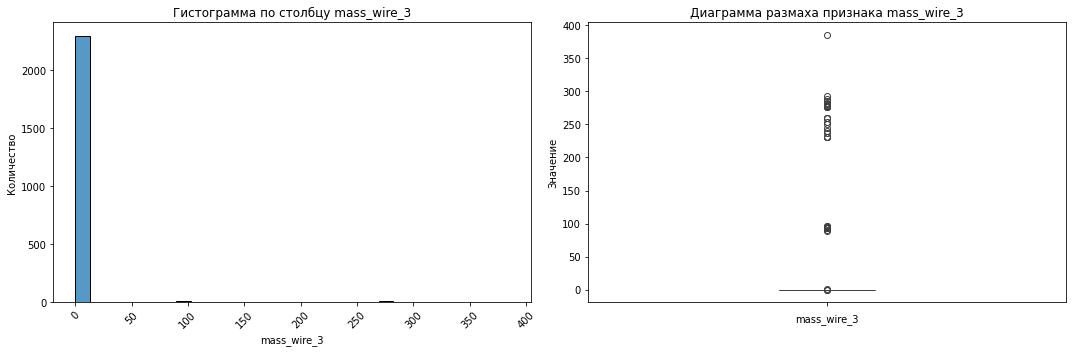

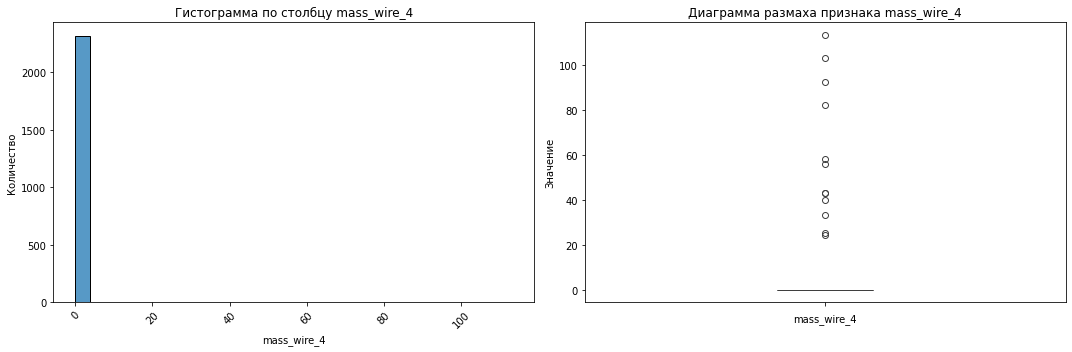

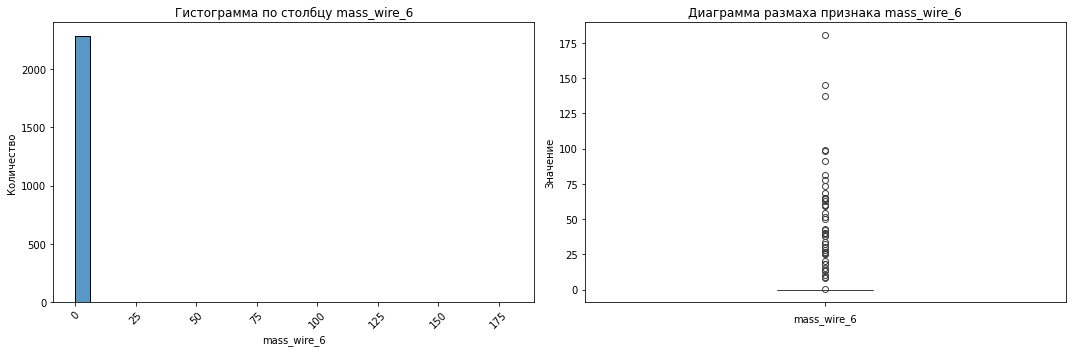

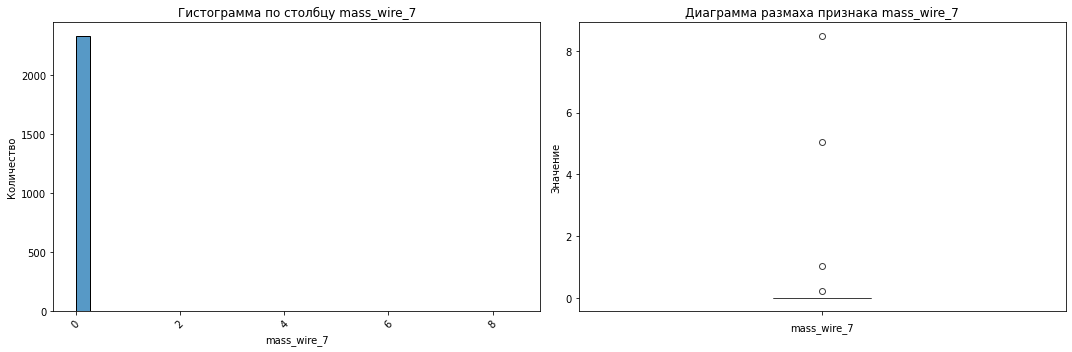

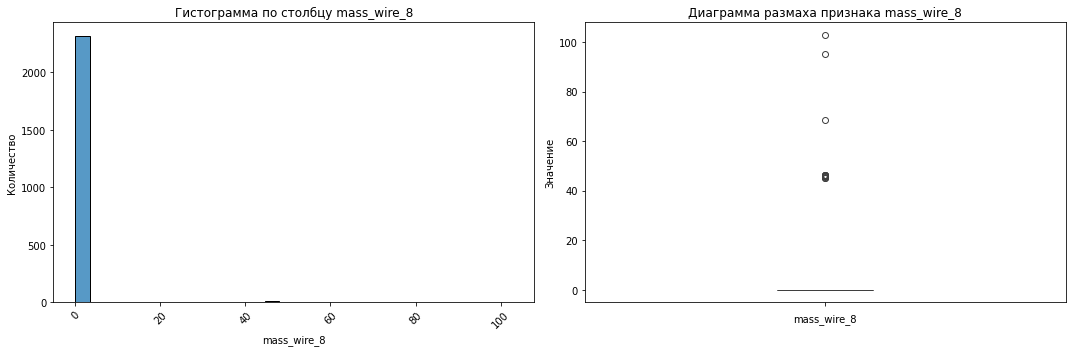

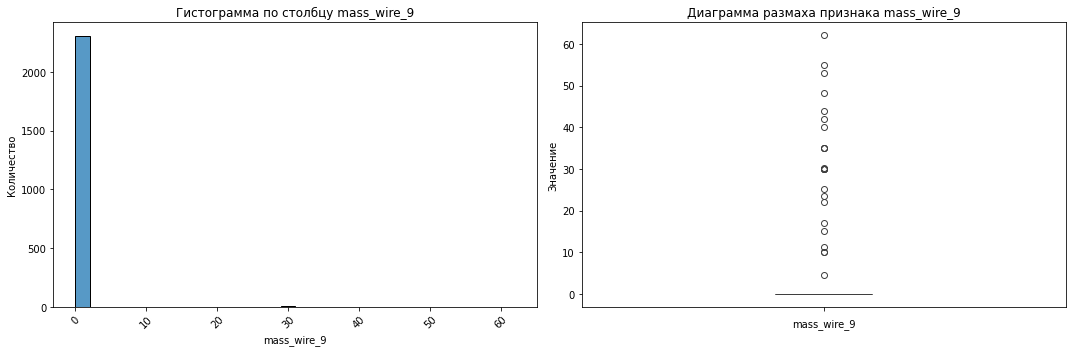

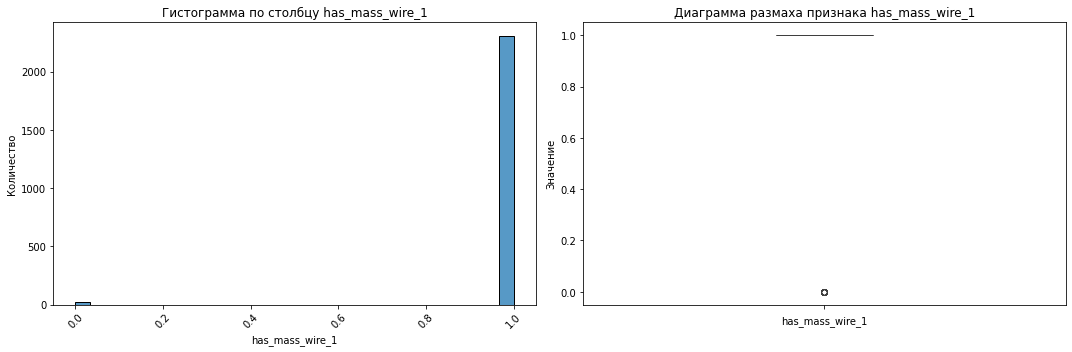

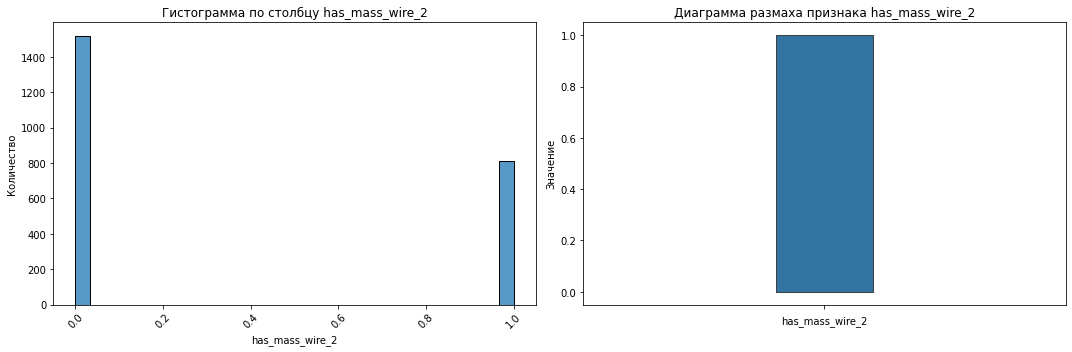

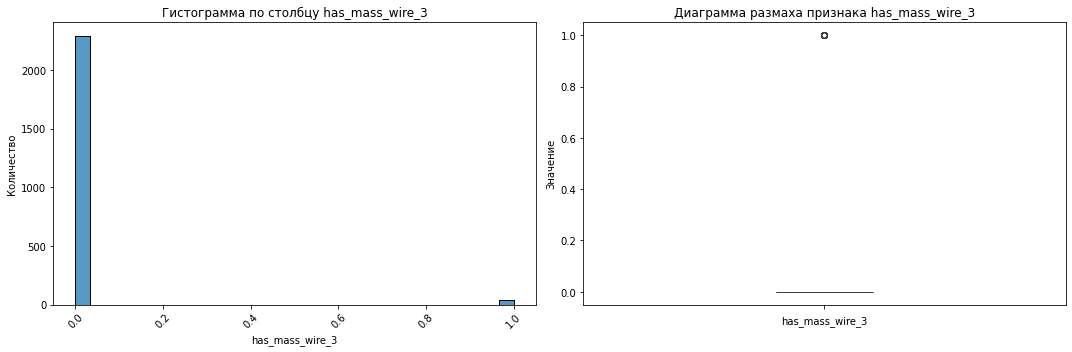

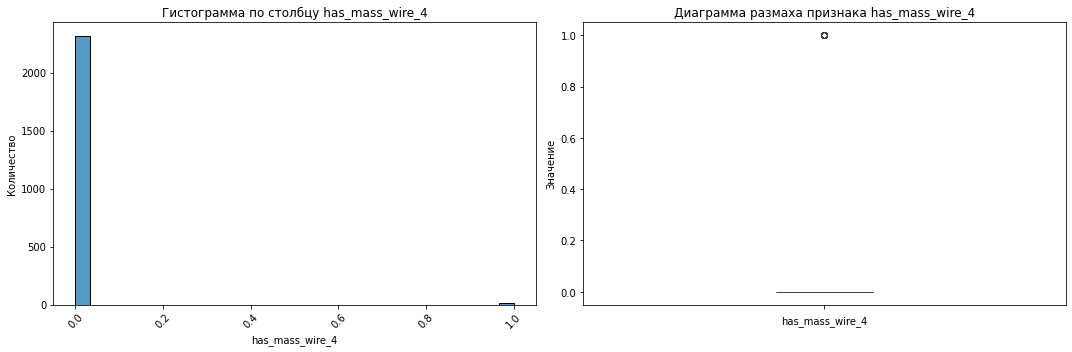

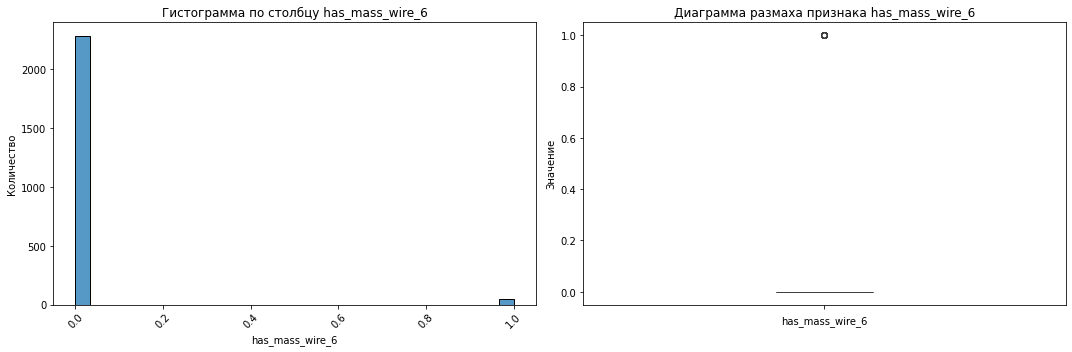

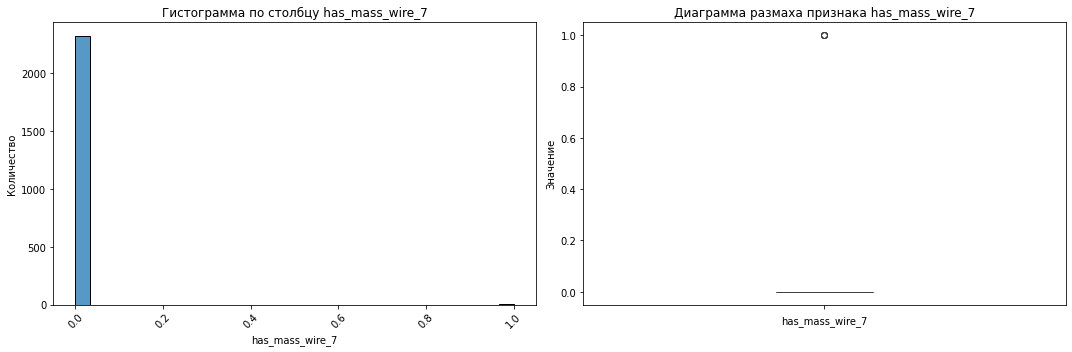

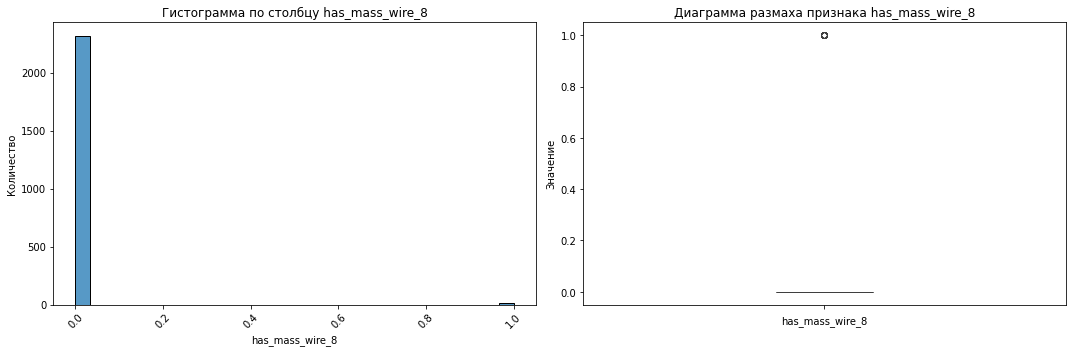

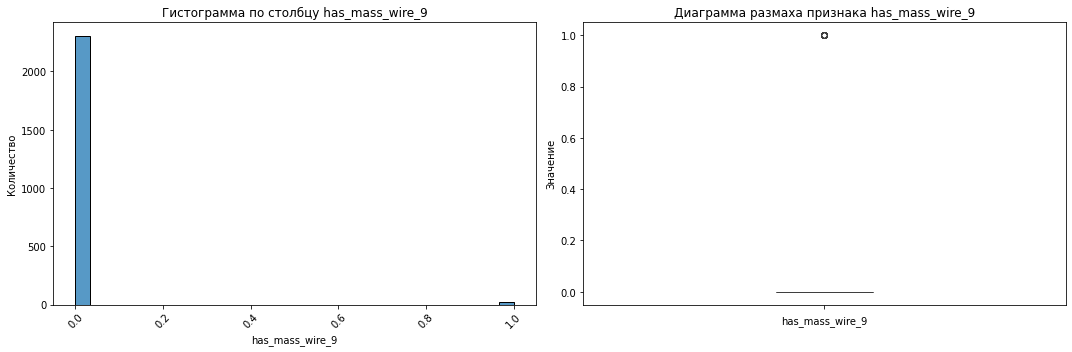

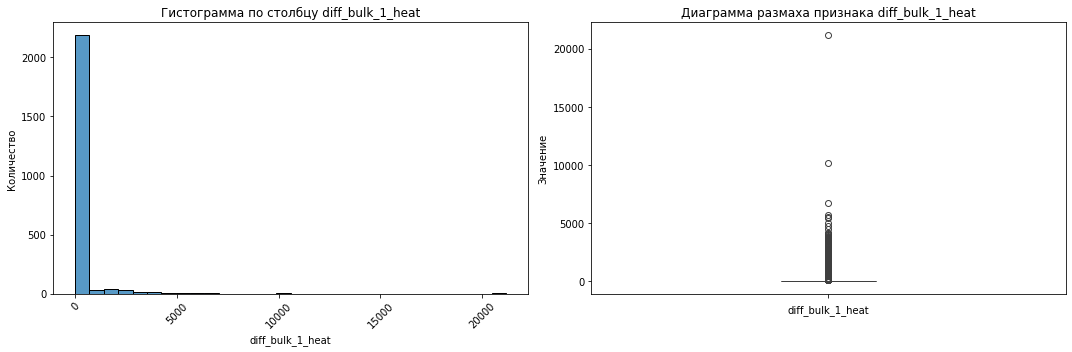

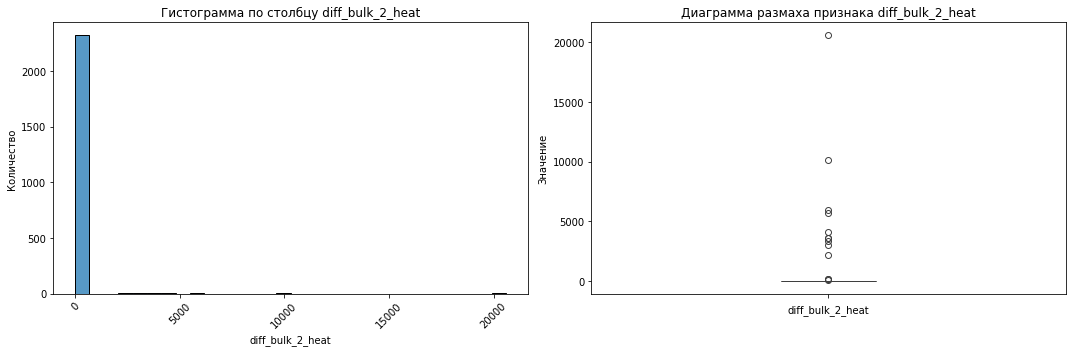

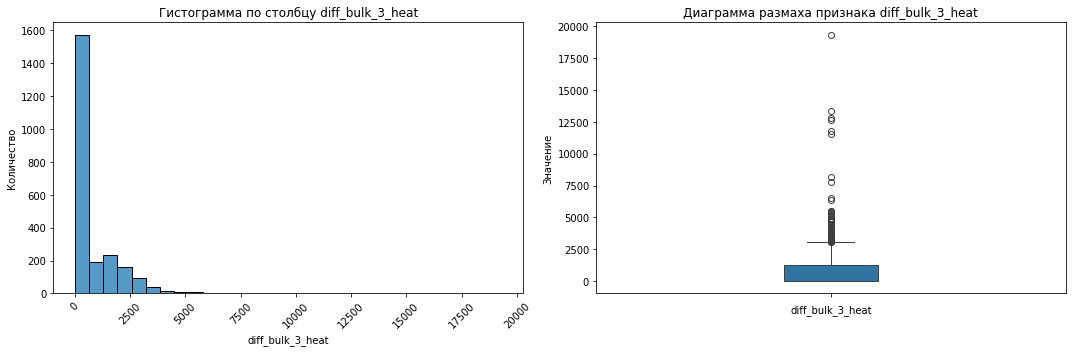

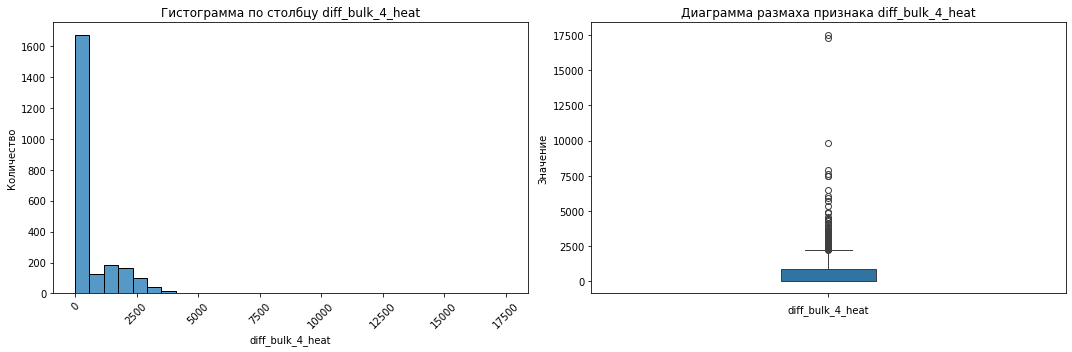

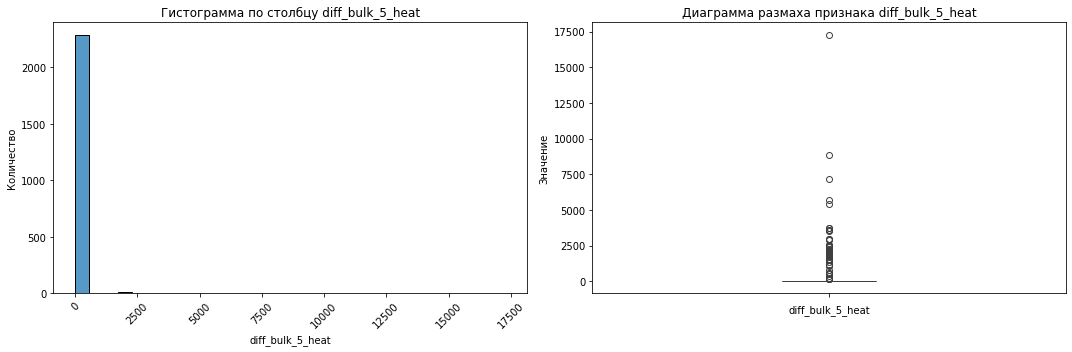

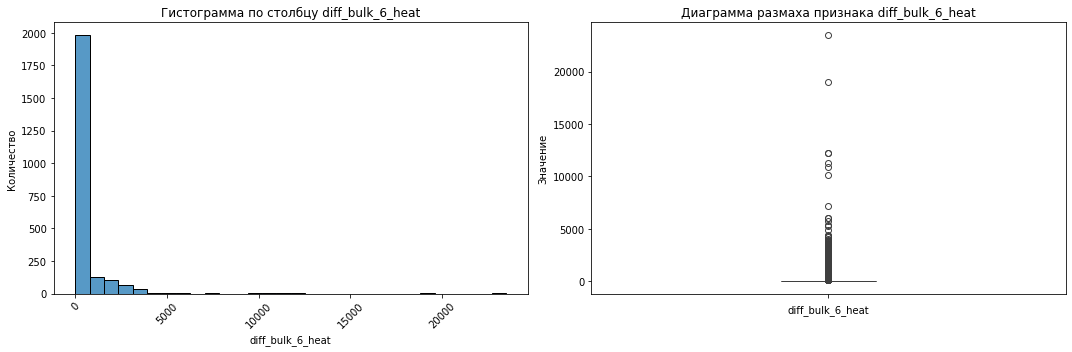

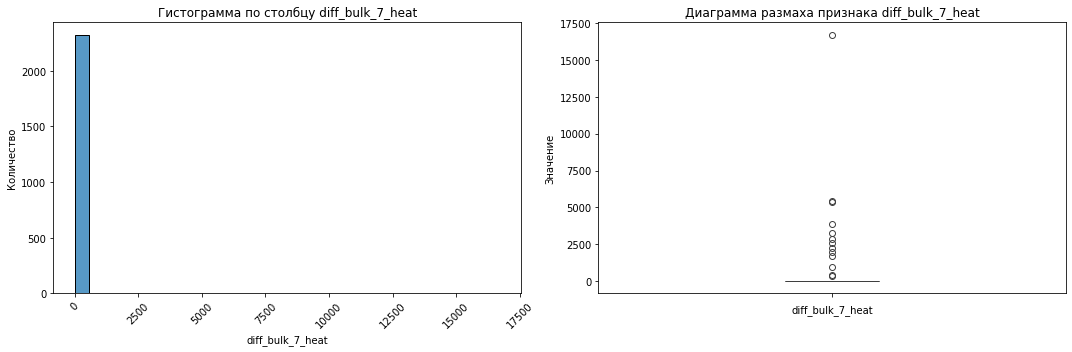

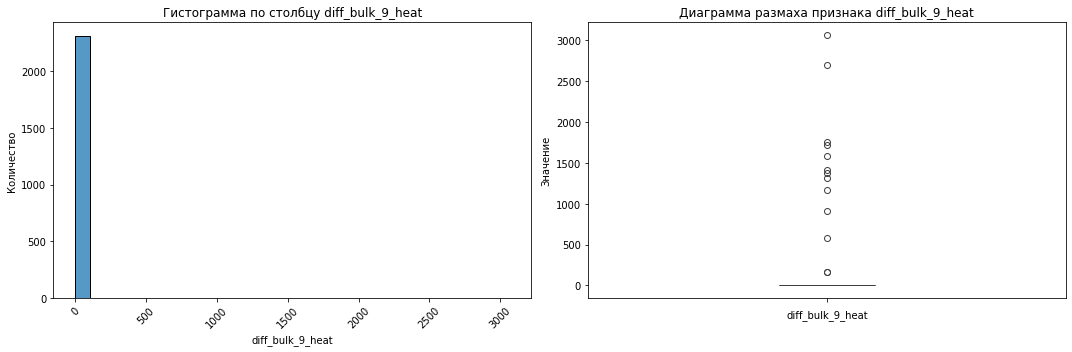

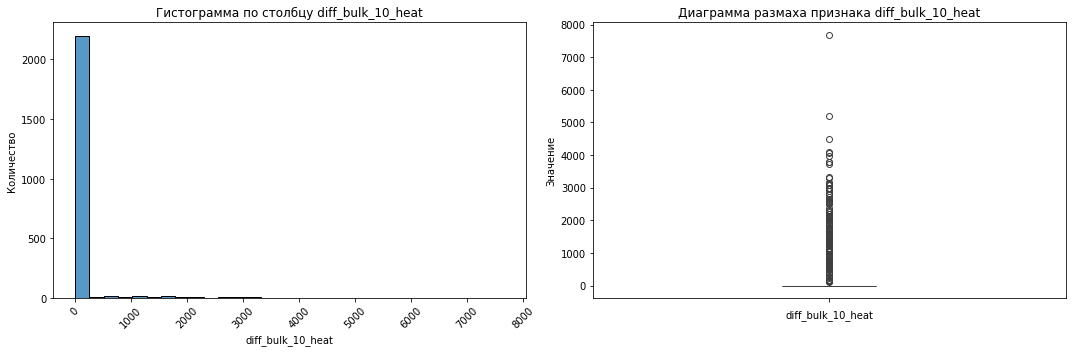

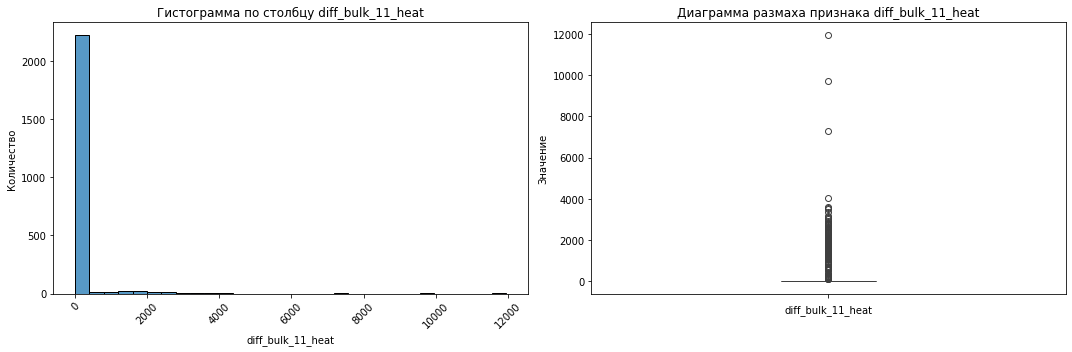

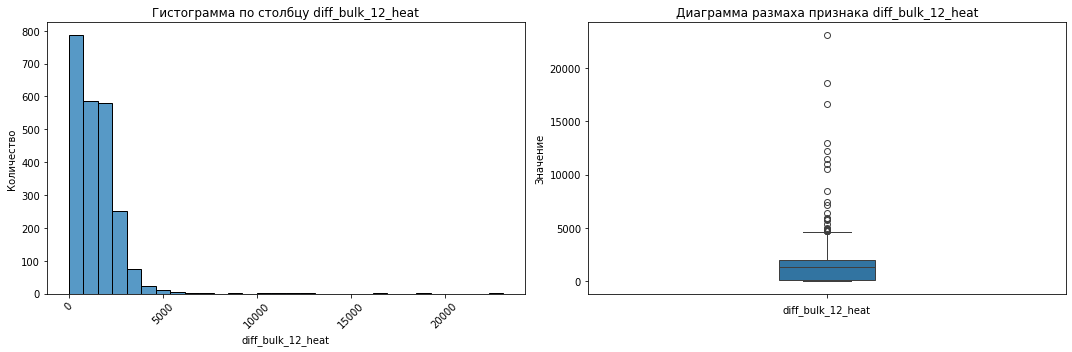

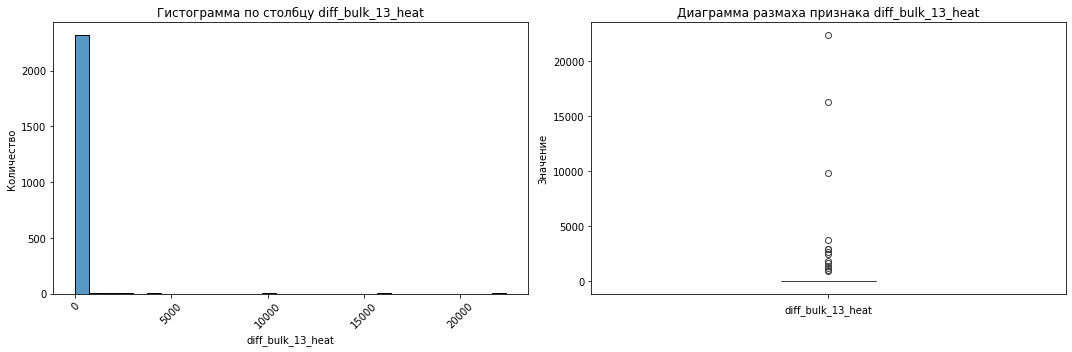

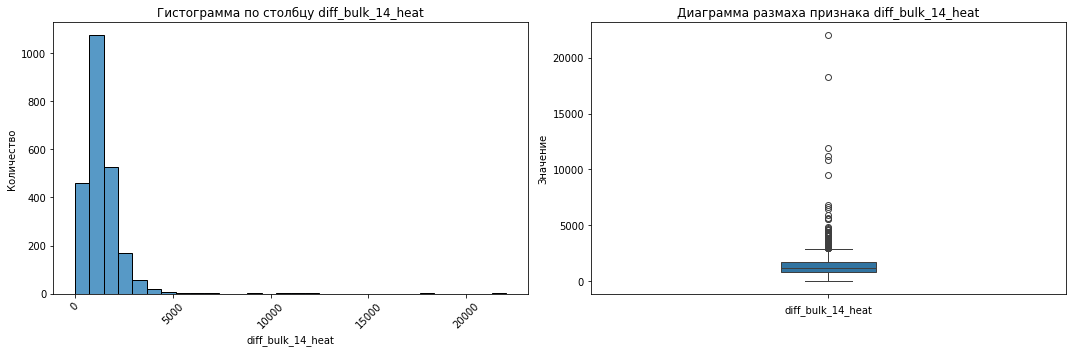

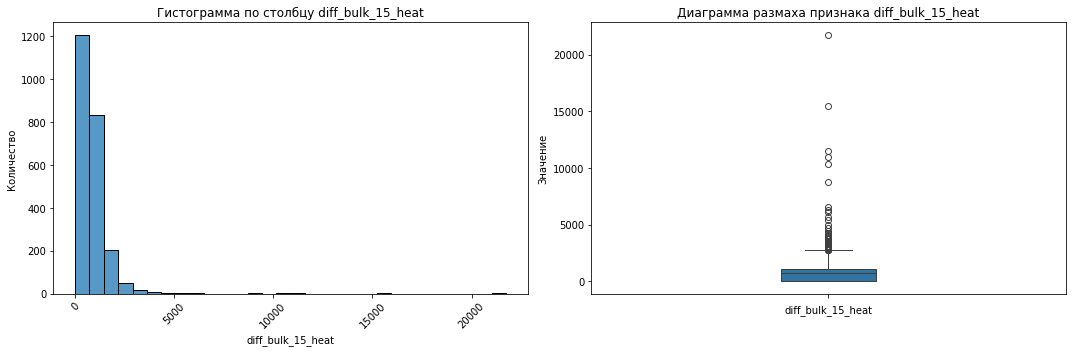

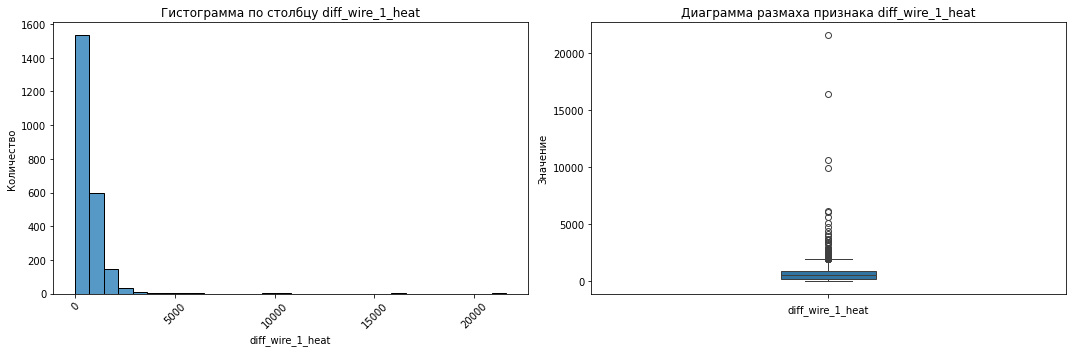

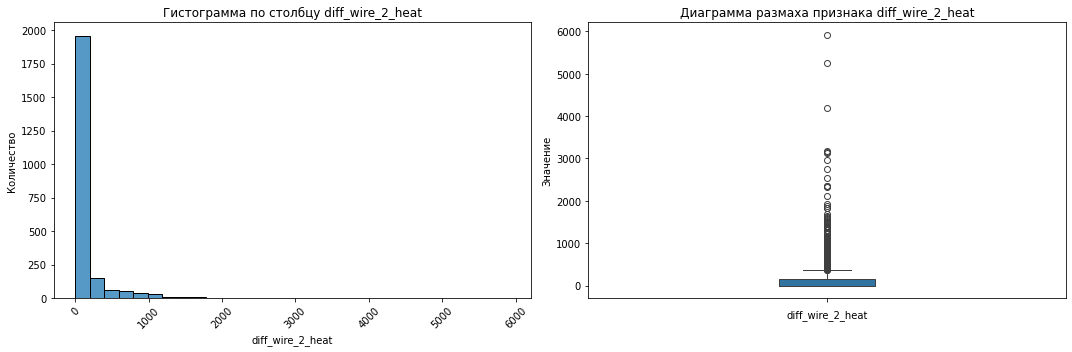

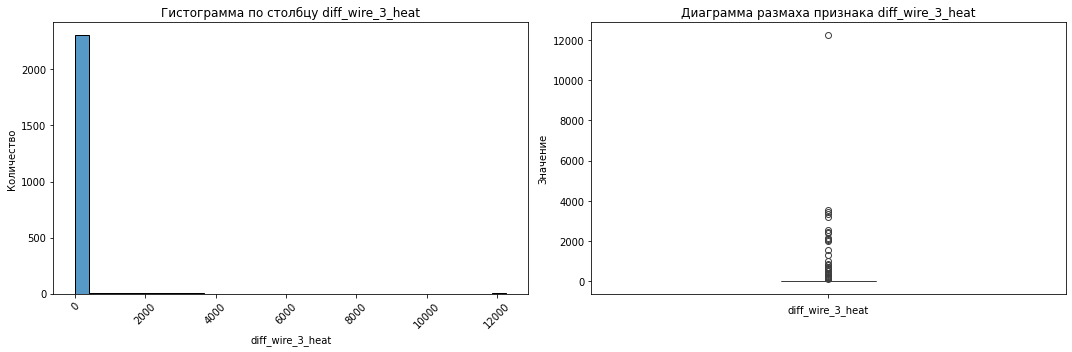

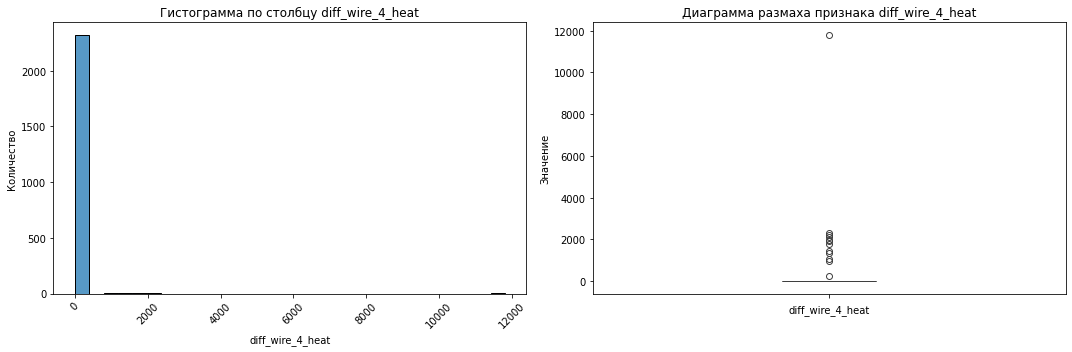

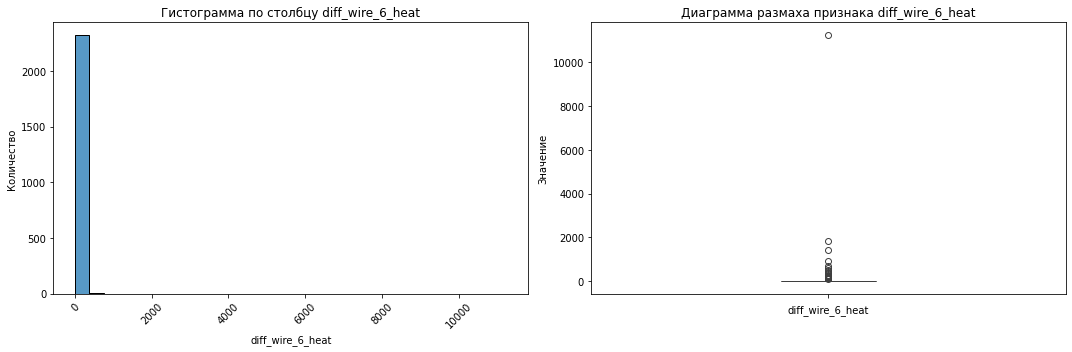

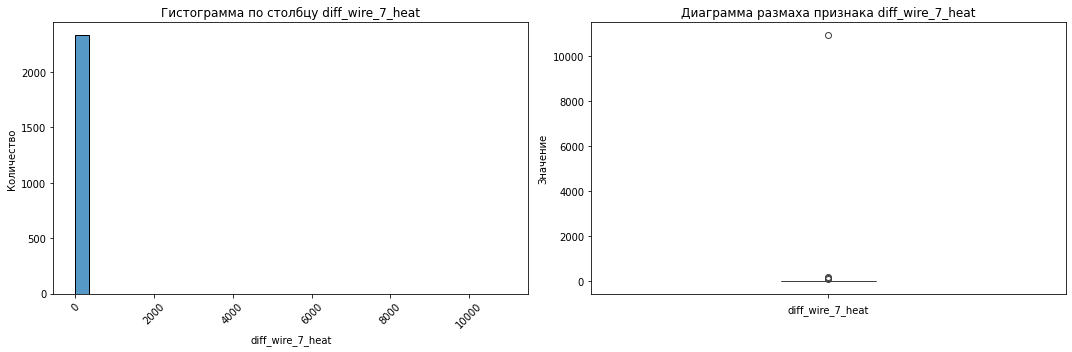

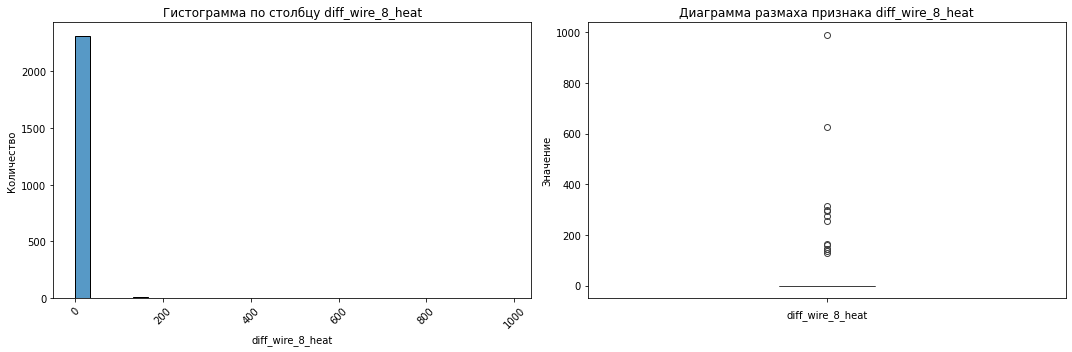

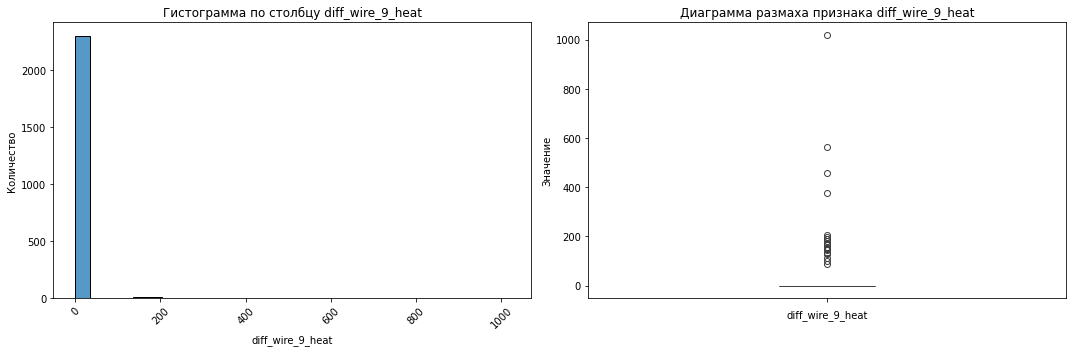

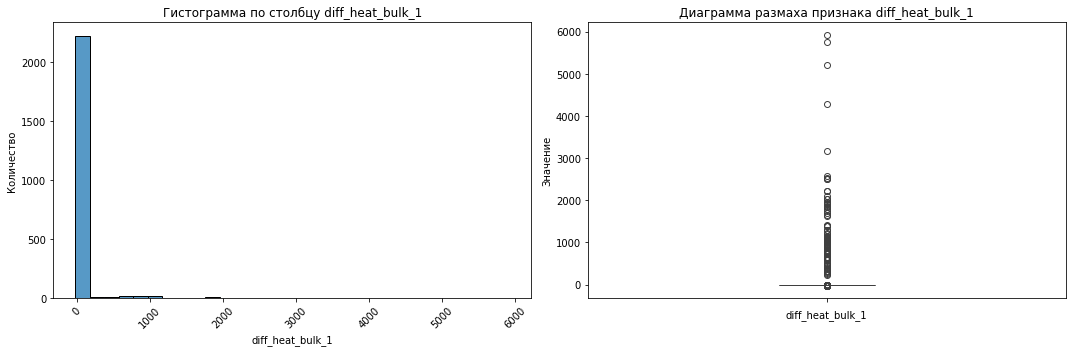

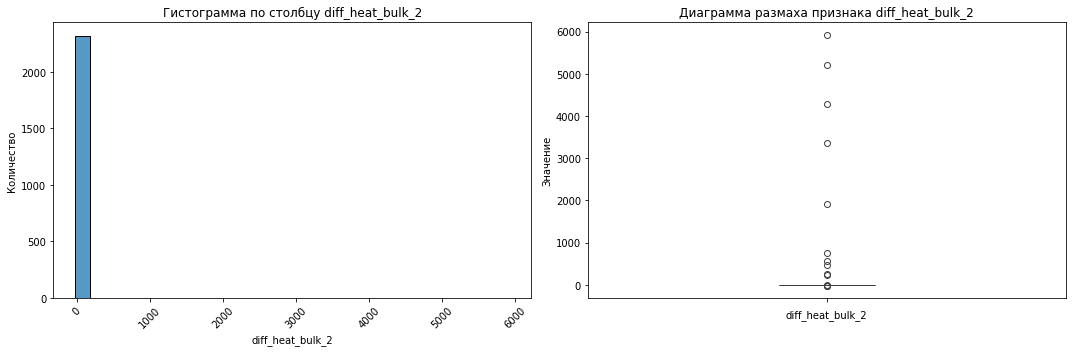

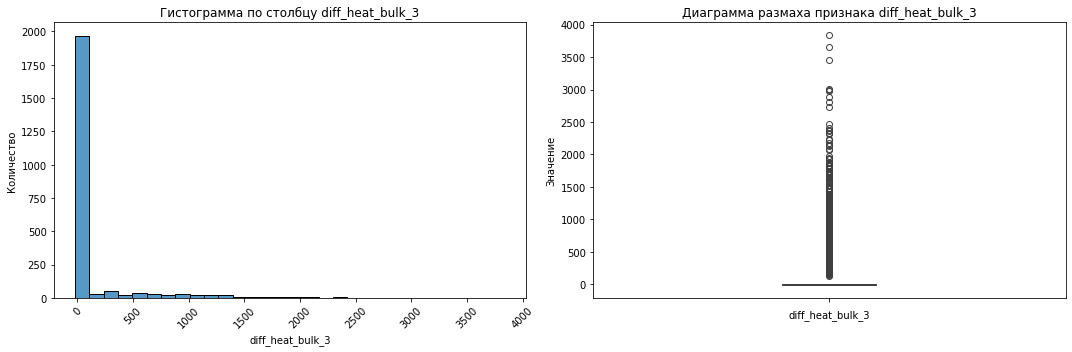

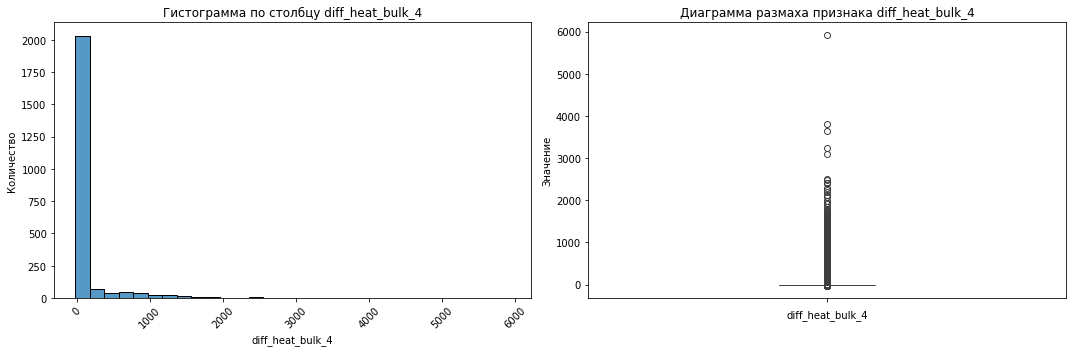

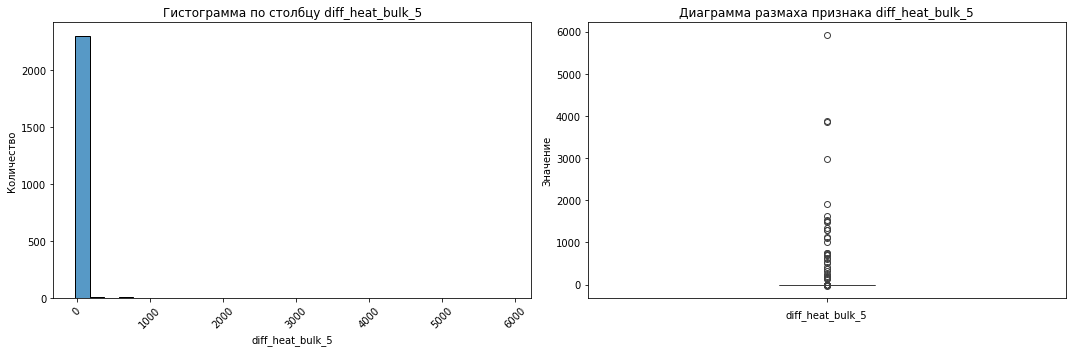

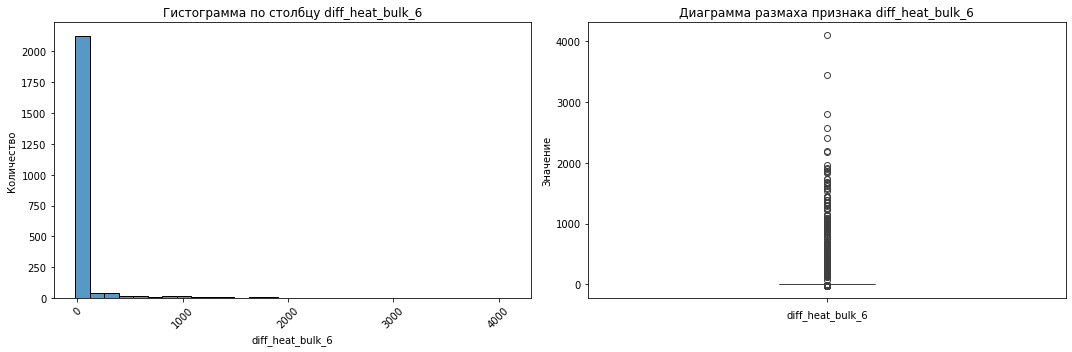

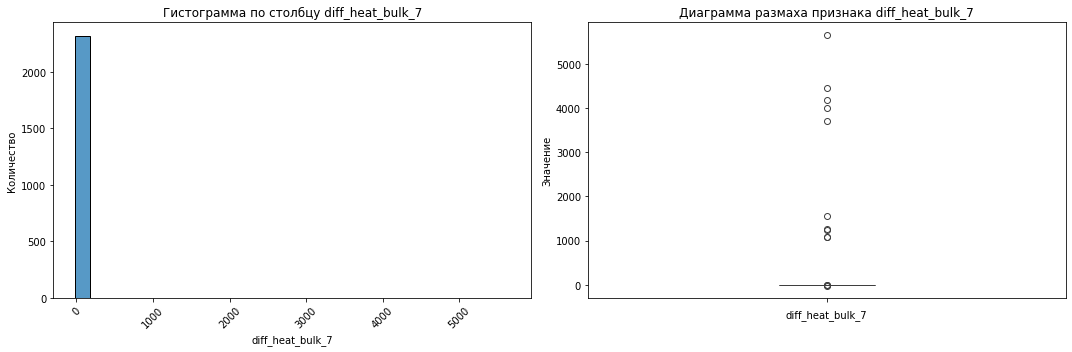

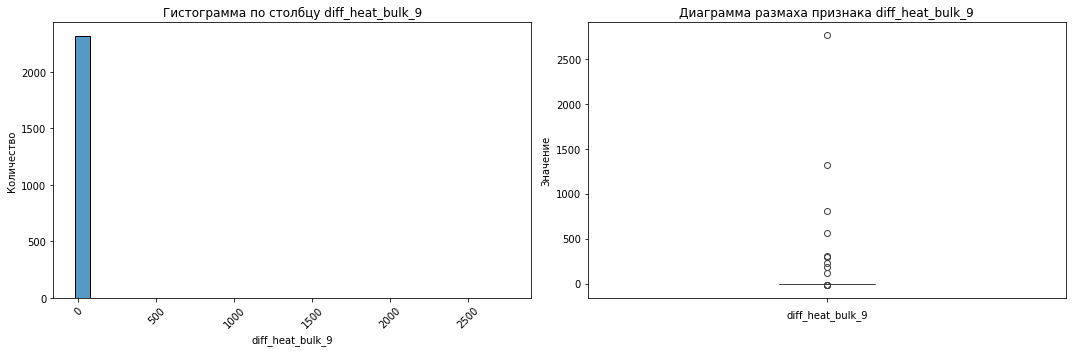

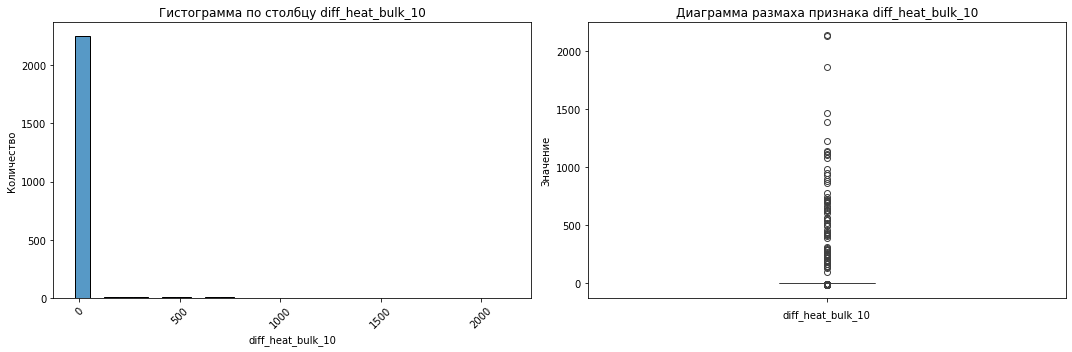

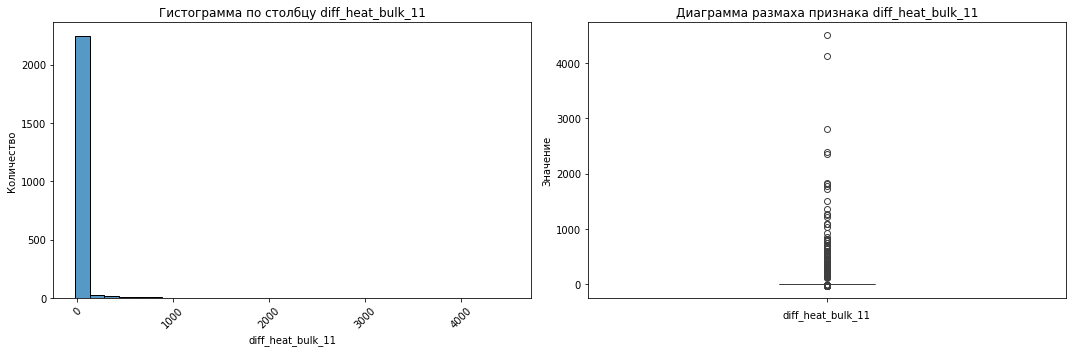

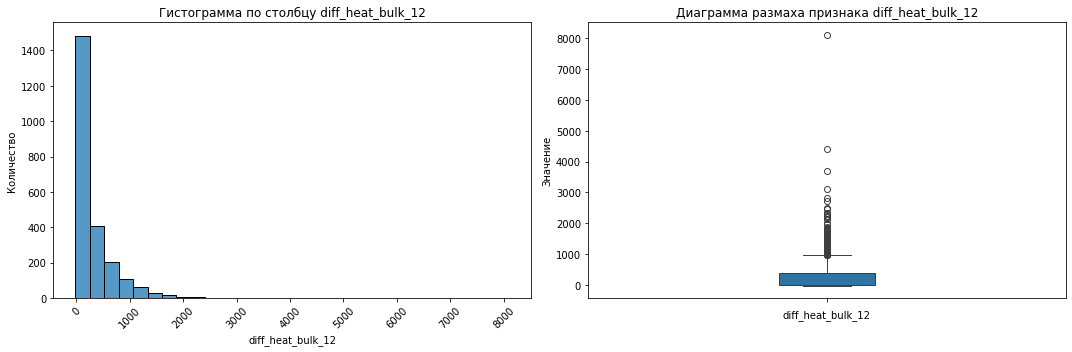

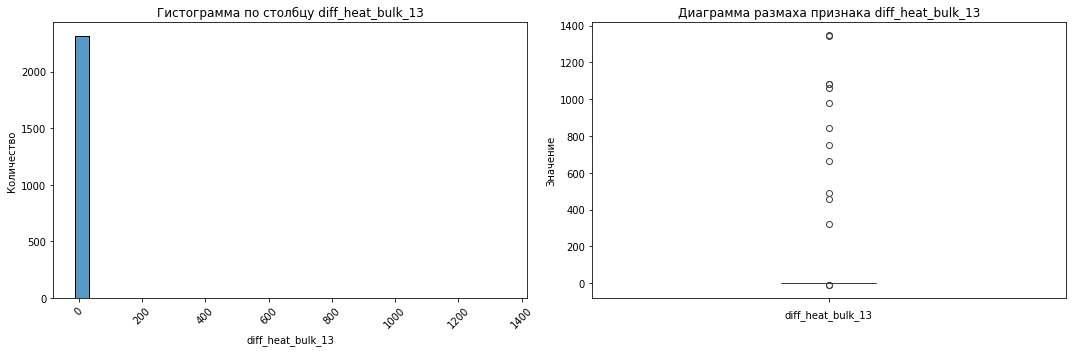

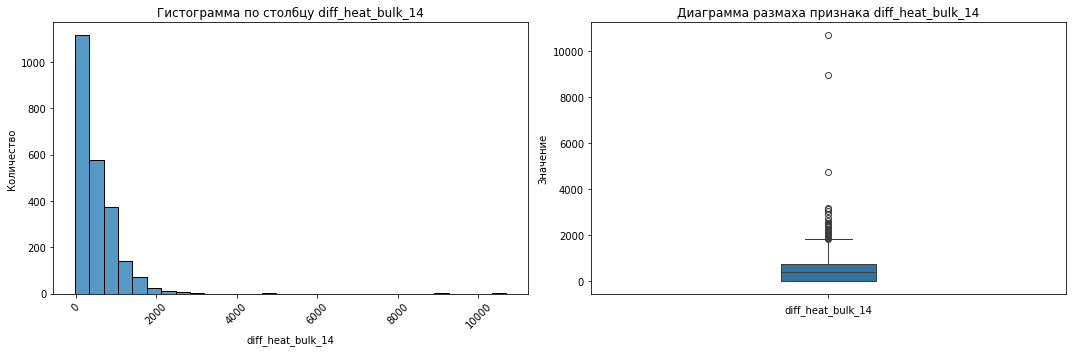

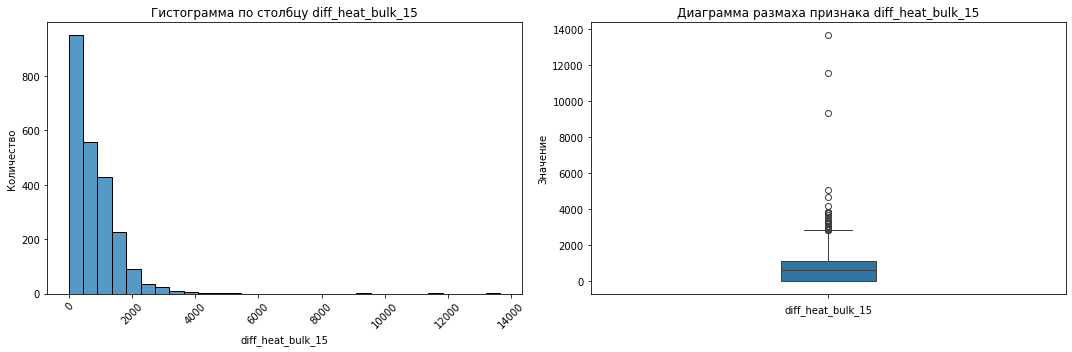

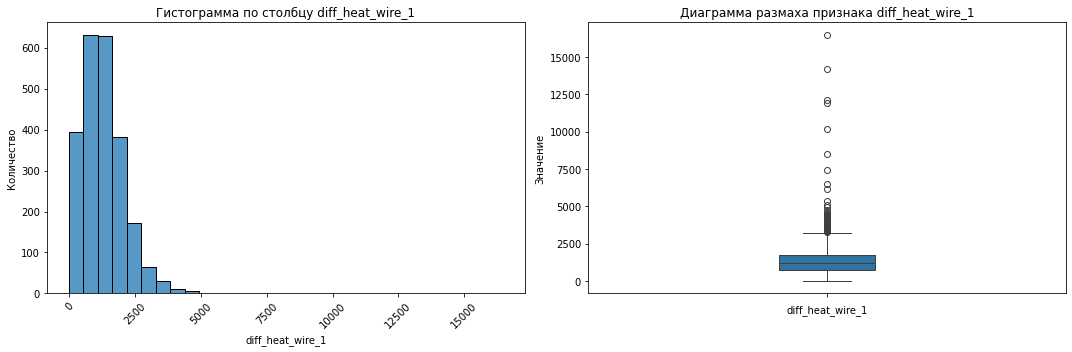

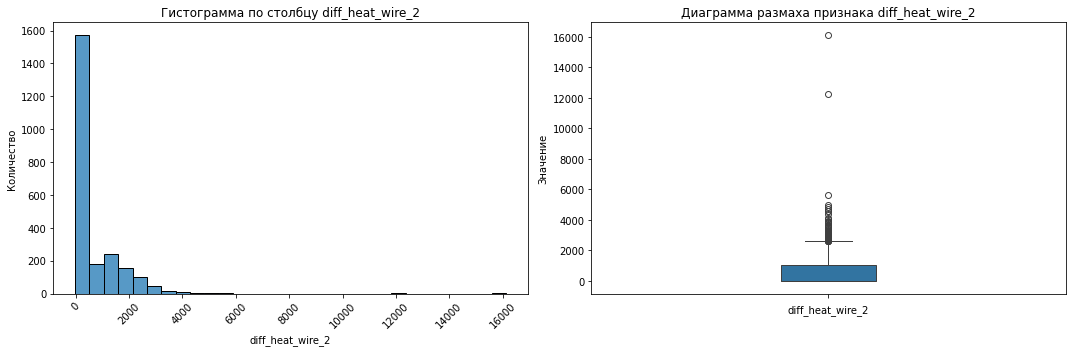

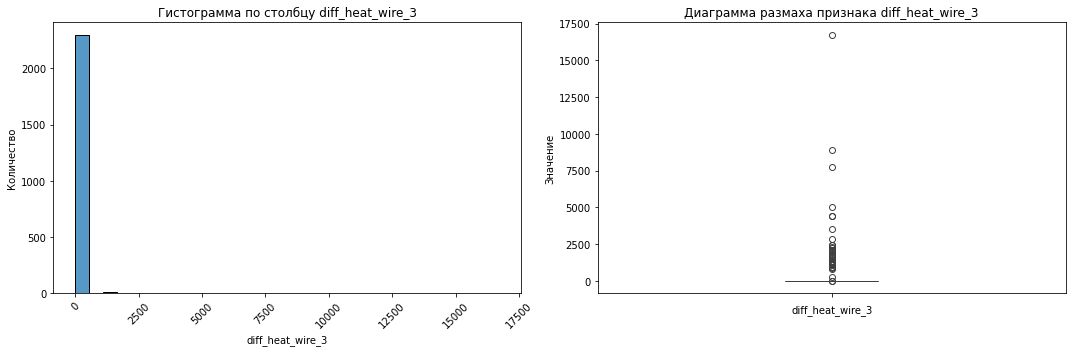

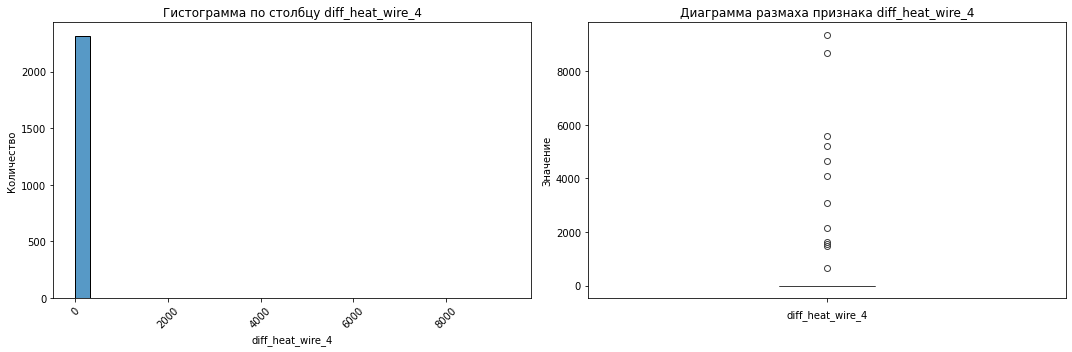

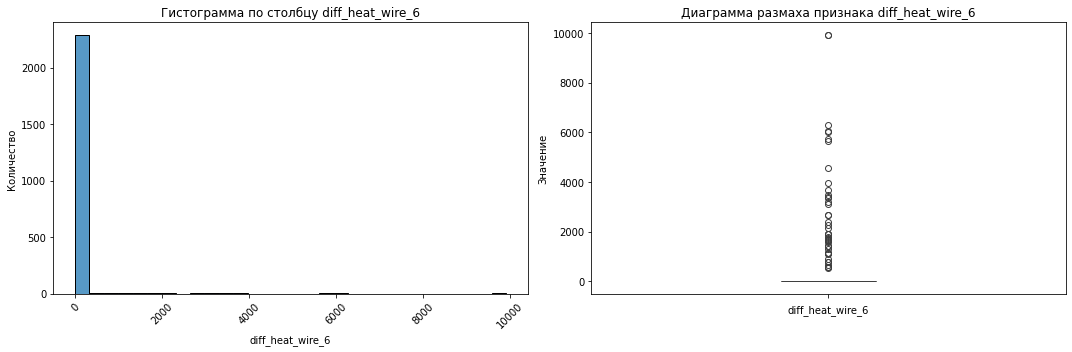

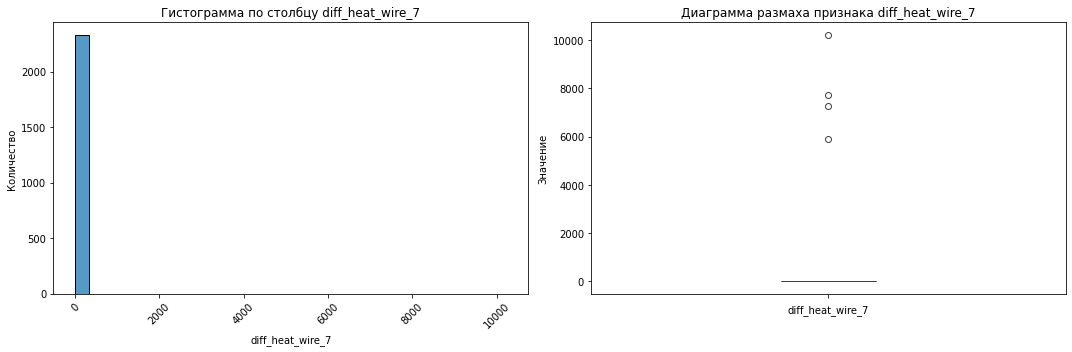

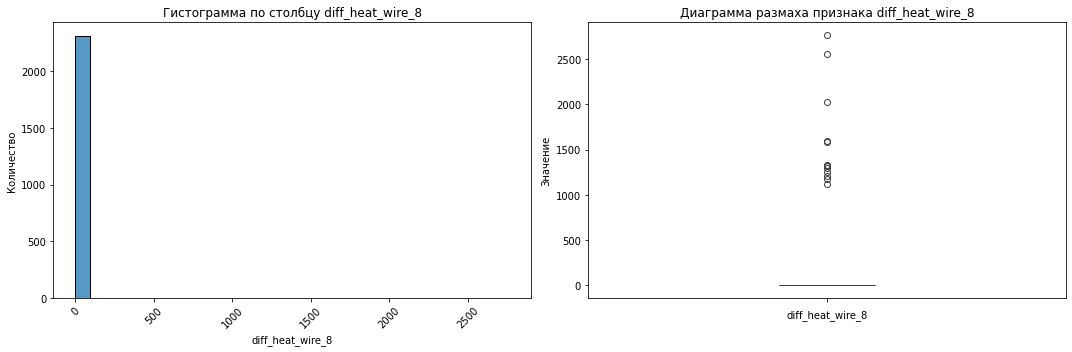

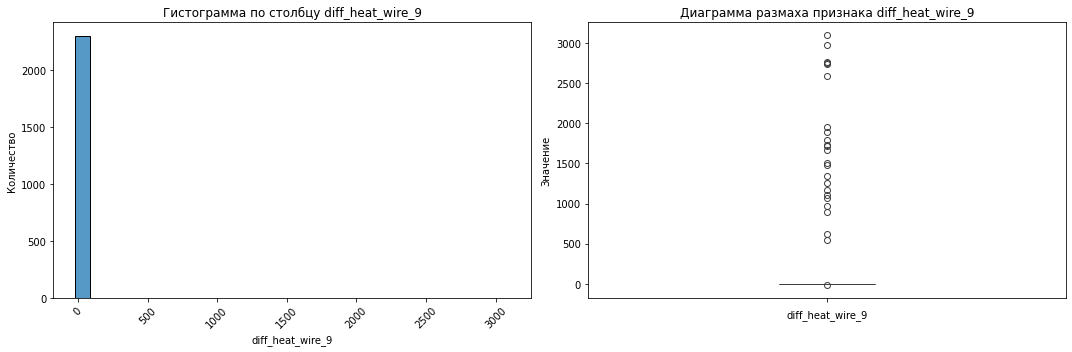

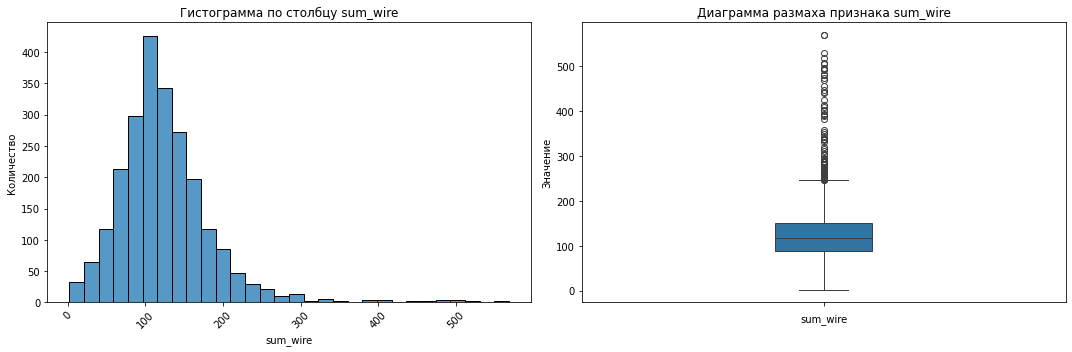

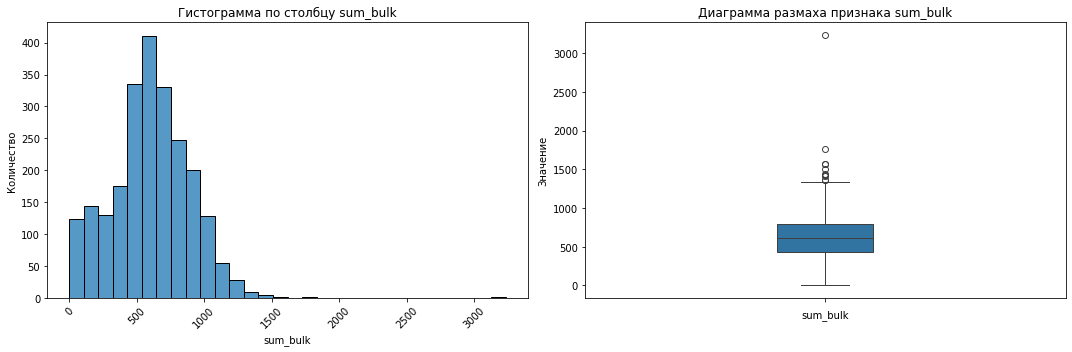

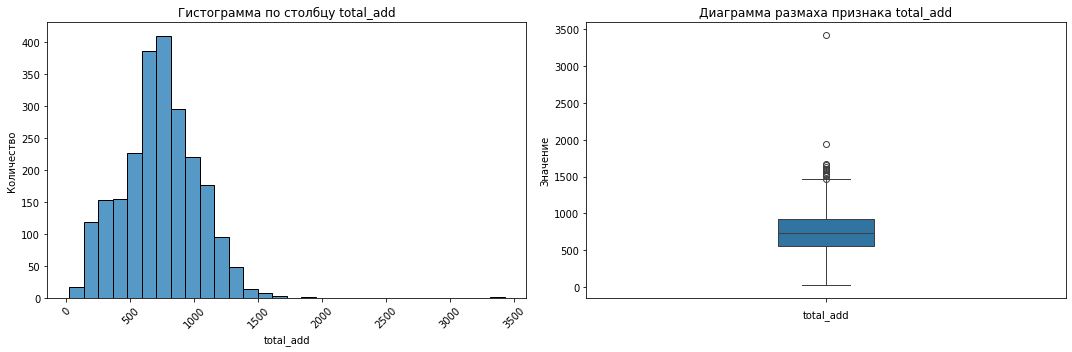

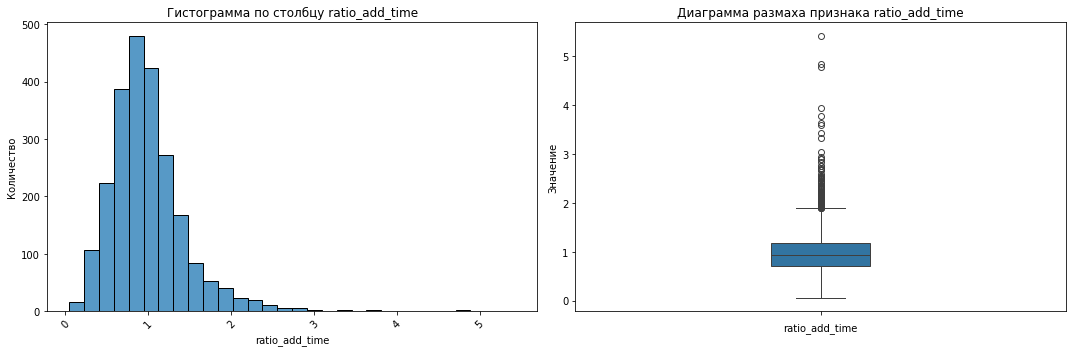

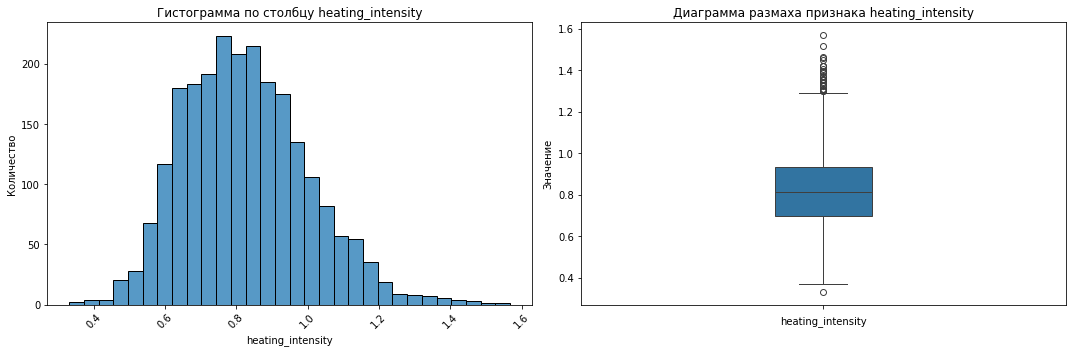

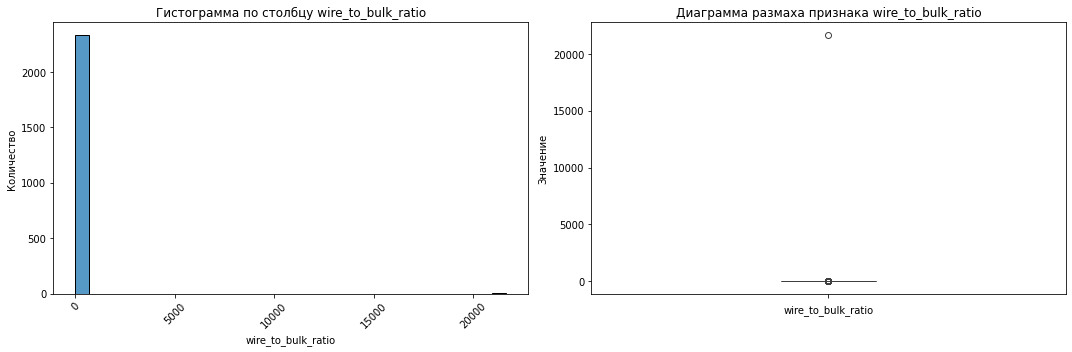

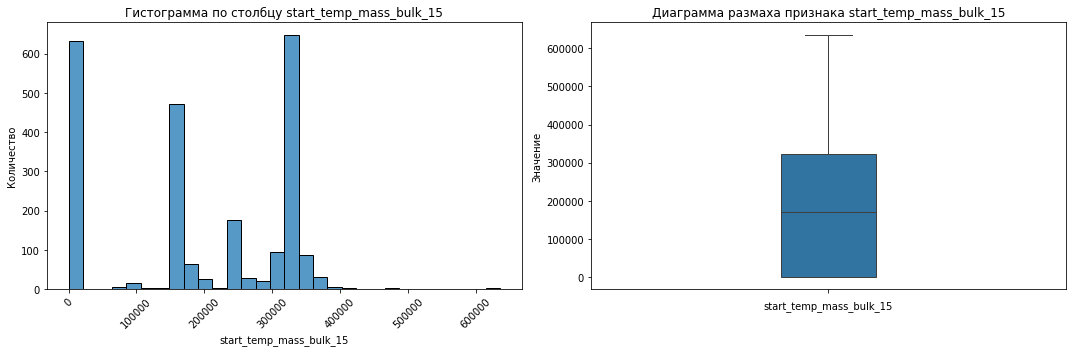

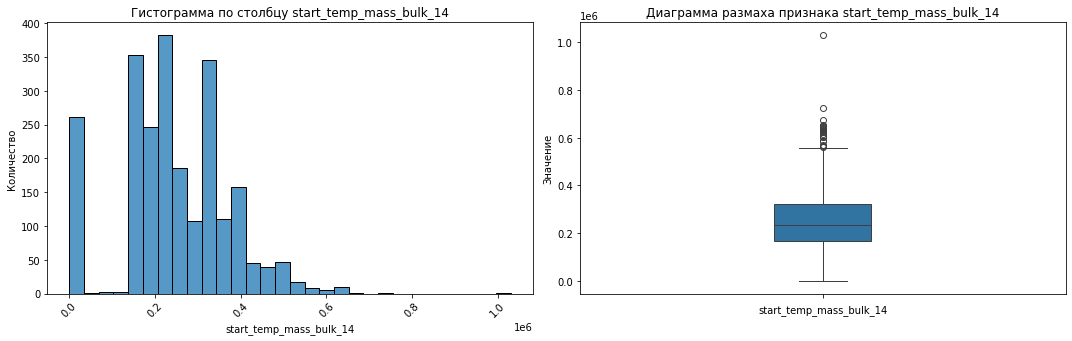

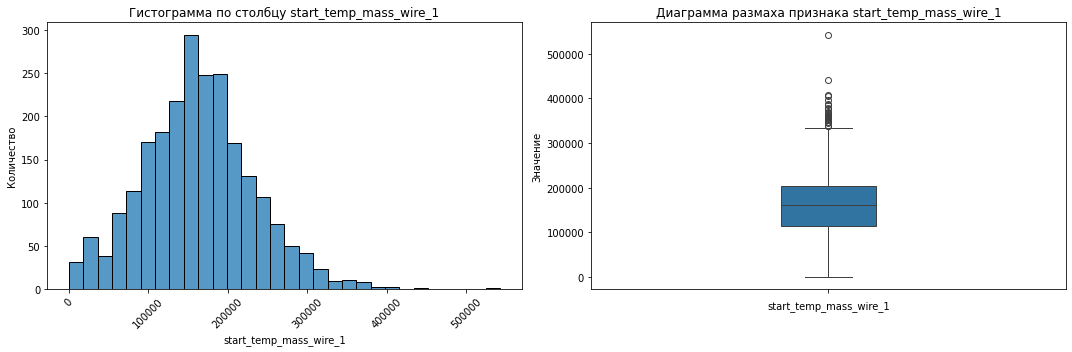

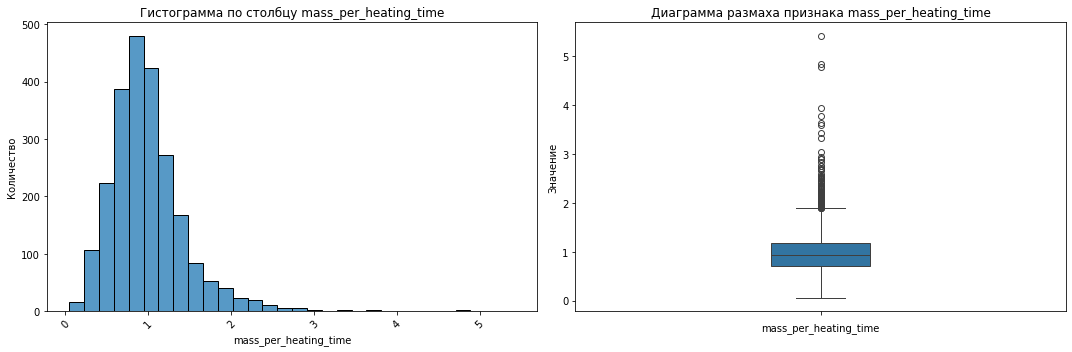

In [ ]:
lunge_analysis(filtered_df, filtered_df.drop('key', axis=1).columns)

Основное из диаграмм:
1. Практически все признаки распределены ненормальным образом.
2. Есть выбросы в ряде признаков, которые нужно удалить.

Согласно задание не должно быть партий, где не было добавлений порошкой, проволоки. Удалим эти ошибочные партии.

In [ ]:
filtered_df = filtered_df.loc[filtered_df['sum_bulk']!=0]

In [ ]:
filtered_df = filtered_df.loc[filtered_df['sum_wire']!=0]

Также не должно быть строк, в которых не осуществлялся нагрев и не было продувки газом.

In [ ]:
filtered_df = filtered_df.loc[filtered_df['heating_duration']!=0]

In [ ]:
filtered_df = filtered_df.loc[filtered_df['gas']!=0]

Из диаграмм видно, что выпадающих значений стало меньше, данные больше похожи на нормально распределенные.

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2328
Columns: 109 entries, key to mass_per_heating_time
dtypes: float64(107), int64(2)
memory usage: 2.0 MB


Количество отрезанных данные составило около 200 строк, что меньше 10% от того массива данных, которые оставались после отрезания строк с одним измерением температуры.

Сбросим индексы

In [ ]:
filtered_df = filtered_df.reset_index(drop=True)

### Корреляционный анализ

Создадим сперва списки признаков, которые будут необходимы при анализе корреляции и обучении модели.

In [ ]:
corr_columns = filtered_df.columns

In [ ]:
corr_columns_1 = corr_columns[1:55]

In [ ]:
corr_columns_2 = list(corr_columns[55:]) + ['end_temp']

In [ ]:
interval_columns_1 = ['active_power', 'apparent_power', 'expended_energy', 'heating_duration',
       'interval_between_start', 'count_heating', 'reactive_power',
       'mass_bulk_1', 'mass_bulk_2', 'mass_bulk_3', 'mass_bulk_4',
       'mass_bulk_5', 'mass_bulk_6', 'mass_bulk_7', 'mass_bulk_9',
       'mass_bulk_10', 'mass_bulk_11', 'mass_bulk_12', 'mass_bulk_13',
       'mass_bulk_14', 'mass_bulk_15', 'gas',
       'start_temp', 'end_temp', 'mass_wire_1', 'mass_wire_2', 'mass_wire_3',
       'mass_wire_4', 'mass_wire_6', 'mass_wire_7', 'mass_wire_8',
       'mass_wire_9']

In [ ]:
interval_columns_2 = [
    'diff_bulk_1_heat',
 'diff_bulk_2_heat',
 'diff_bulk_3_heat',
 'diff_bulk_4_heat',
 'diff_bulk_5_heat',
 'diff_bulk_6_heat',
 'diff_bulk_7_heat',
 'diff_bulk_9_heat',
 'diff_bulk_10_heat',
 'diff_bulk_11_heat',
 'diff_bulk_12_heat',
 'diff_bulk_13_heat',
 'diff_bulk_14_heat',
 'diff_bulk_15_heat',
 'diff_wire_1_heat',
 'diff_wire_2_heat',
 'diff_wire_3_heat',
 'diff_wire_4_heat',
 'diff_wire_6_heat',
 'diff_wire_7_heat',
 'diff_wire_8_heat',
 'diff_wire_9_heat',
 'diff_heat_bulk_1',
 'diff_heat_bulk_2',
 'diff_heat_bulk_3',
 'diff_heat_bulk_4',
 'diff_heat_bulk_5',
 'diff_heat_bulk_6',
 'diff_heat_bulk_7',
 'diff_heat_bulk_9',
 'diff_heat_bulk_10',
 'diff_heat_bulk_11',
 'diff_heat_bulk_12',
 'diff_heat_bulk_13',
 'diff_heat_bulk_14',
 'diff_heat_bulk_15',
 'diff_heat_wire_1',
 'diff_heat_wire_2',
 'diff_heat_wire_3',
 'diff_heat_wire_4',
 'diff_heat_wire_6',
 'diff_heat_wire_7',
 'diff_heat_wire_8',
 'diff_heat_wire_9',
 'sum_wire',
 'sum_bulk',
 'total_add',
 'ratio_add_time',
 'heating_intensity',
 'wire_to_bulk_ratio',
 'start_temp_mass_bulk_15',
 'start_temp_mass_bulk_14',
 'start_temp_mass_wire_1',
 'mass_per_heating_time',
 'end_temp'
]

In [ ]:
numeric_columns = set(interval_columns_1 + interval_columns_2)

In [ ]:
numeric_columns.remove('end_temp')

In [ ]:
cat_columns = ['has_mass_bulk_1',
       'has_mass_bulk_2', 'has_mass_bulk_3', 'has_mass_bulk_4',
       'has_mass_bulk_5', 'has_mass_bulk_6', 'has_mass_bulk_7',
       'has_mass_bulk_9', 'has_mass_bulk_10', 'has_mass_bulk_11',
       'has_mass_bulk_12', 'has_mass_bulk_13', 'has_mass_bulk_14',
       'has_mass_bulk_15', 'has_mass_wire_1', 'has_mass_wire_2',
        'has_mass_wire_3', 'has_mass_wire_4', 'has_mass_wire_6',
        'has_mass_wire_7', 'has_mass_wire_8', 'has_mass_wire_9',]

Построим теперь матрицу корреляций

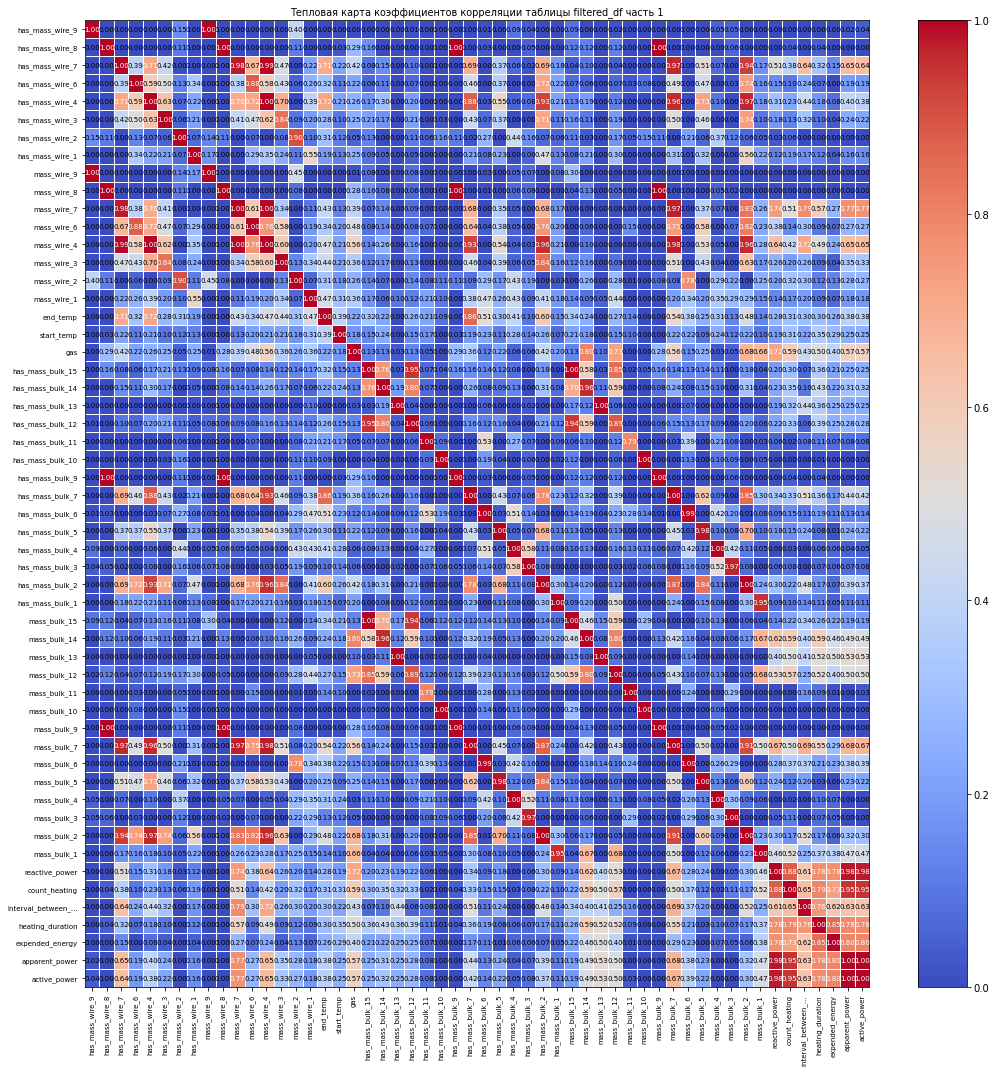

In [ ]:
phik_overview = filtered_df[corr_columns_1].phik_matrix(interval_cols=interval_columns_1)
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы filtered_df часть 1",
                        fontsize_factor=0.7,
                        figsize=(15, 15))
plt.tight_layout()
plt.show()

Из первой части видно, что целевой признак, end_temp, хорошо коррелирует с интервалами между нагревами, массой сыпучего вещества №2, №7 и очень сильно коррелирует с фактом добавление сыпучего вещества №7 и проволоки №4.

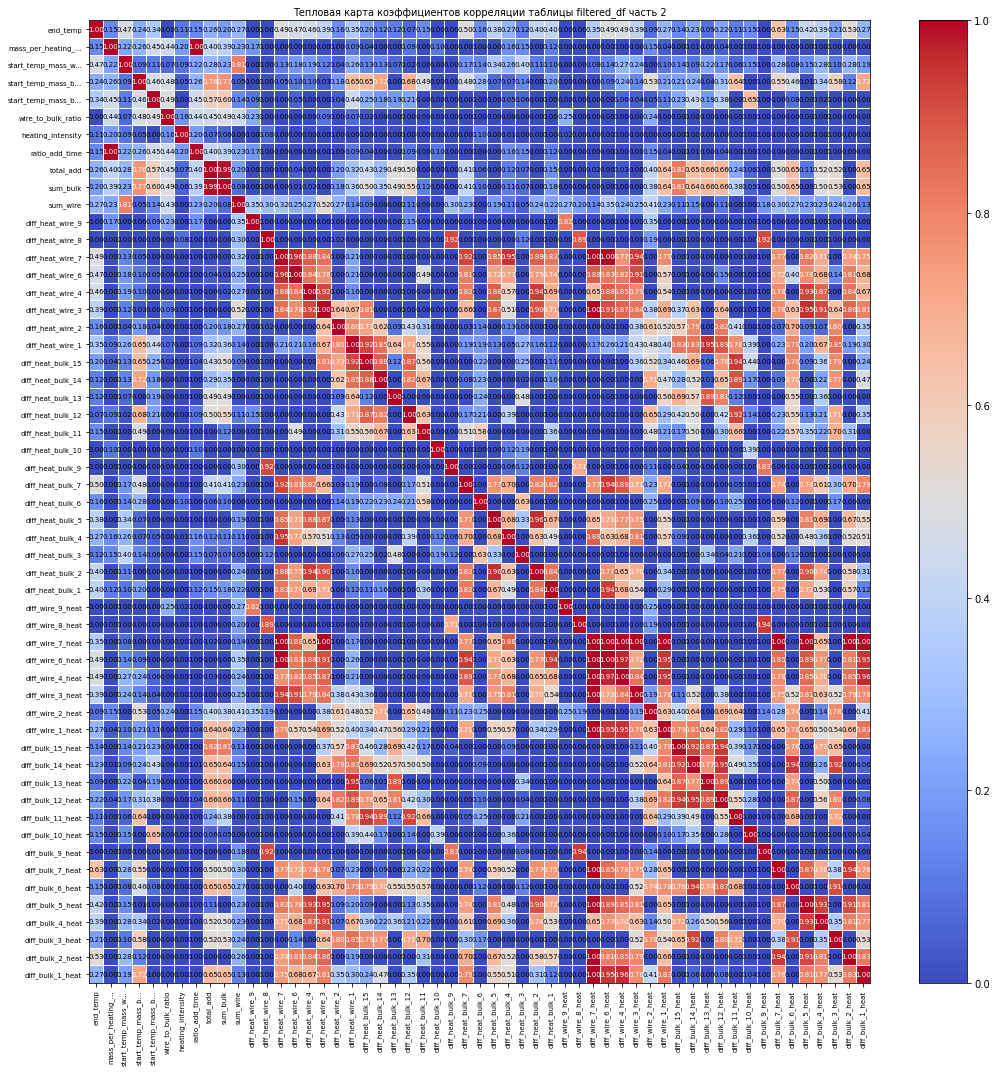

In [ ]:
phik_overview = filtered_df[corr_columns_2].phik_matrix(interval_cols=interval_columns_2)
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы filtered_df часть 2",
                        fontsize_factor=0.7,
                        figsize=(15, 15))
plt.tight_layout()
plt.show()

Из второй части видно, что сильная корреляция с разницей нагрева и подачей проволоки №4, 6, 7 и сыпучим веществом №2.

## Обучение модели

### Нейросеть

Сперва разделим данные.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    filtered_df.drop(['end_temp', 'key'], axis=1),
    filtered_df['end_temp'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE)

X_train.shape, X_test.shape

((1746, 107), (582, 107))

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>   

Выборки подготовлены корректно

Подготовим признаки для сети

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)

In [ ]:
X_train_ohe = ohe.fit_transform(X_train[cat_columns])
X_test_ohe = ohe.transform(X_test[cat_columns])

In [ ]:
cat_ohe_name = ohe.get_feature_names_out()

In [ ]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=cat_ohe_name)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=cat_ohe_name)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train[list(numeric_columns)])
X_test_scaled = scaler.transform(X_test[list(numeric_columns)])

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_columns)

In [ ]:
X_train_neuro = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_neuro = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
X_train_neuro.shape, X_test_neuro.shape

((1746, 107), (582, 107))

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_neuro.values)
X_test_tensor = torch.FloatTensor(X_test_neuro.values)
y_train_tensor = torch.FloatTensor(y_train.values)
y_test_tensor = torch.FloatTensor(y_test.values)

Теперь обучим нейросеть

In [ ]:
n_in_neurons = X_train_neuro.shape[1]
n_hidden_neurons_1 = 256
n_hidden_neurons_2 = 128
n_hidden_neurons_3 = 64
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.BatchNorm1d(n_hidden_neurons_1),

    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.BatchNorm1d(n_hidden_neurons_2),

    nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_3),

    nn.Linear(n_hidden_neurons_3, n_out_neurons),
)

In [ ]:
%%time

# Обучение с разными размерами батчей
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
loss = nn.L1Loss()
num_epochs = 500

batch_sizes = [64, 128, 256, 512, 1024]
mae_list = []

for batch_size in batch_sizes:
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.BatchNorm1d(n_hidden_neurons_1),

        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.BatchNorm1d(n_hidden_neurons_2),

        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
        nn.ReLU(),
        nn.BatchNorm1d(n_hidden_neurons_3),

        nn.Linear(n_hidden_neurons_3, n_out_neurons),
    )

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)

    num_batches = ceil(len(X_train_tensor)/batch_size)

    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train_tensor))

        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            end_index = min(start_index + batch_size, len(X_train_tensor))

            batch_indexes = order[start_index:end_index]
            X_batch = X_train_tensor[batch_indexes]
            y_batch = y_train_tensor[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch % 10 == 0:
            print(f'Batch size: {batch_size}, Epoch: {epoch}, Loss: {loss_value.item():.4f}')

        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test_tensor).flatten()
            mae = torch.mean(torch.abs(test_preds - y_test_tensor))
            mae_list.append(mae)
            print(f'При batch = {batch_size} MAE = {mae}')
            net.train()

# Вывод лучшего результата
best_batch_size = batch_sizes[np.argmin([m.item() for m in mae_list])]
print(f'\nЛучший размер батча: {best_batch_size}')

Batch size: 64, Epoch: 0, Loss: 1593.1343
Batch size: 64, Epoch: 10, Loss: 1576.1892
Batch size: 64, Epoch: 20, Loss: 1536.1409
Batch size: 64, Epoch: 30, Loss: 1468.9331
Batch size: 64, Epoch: 40, Loss: 1379.7183
Batch size: 64, Epoch: 50, Loss: 1274.7388
Batch size: 64, Epoch: 60, Loss: 1152.3425
Batch size: 64, Epoch: 70, Loss: 1002.7643
Batch size: 64, Epoch: 80, Loss: 849.0089
Batch size: 64, Epoch: 90, Loss: 675.7799
Batch size: 64, Epoch: 100, Loss: 491.5568
Batch size: 64, Epoch: 110, Loss: 288.1855
Batch size: 64, Epoch: 120, Loss: 77.2742
Batch size: 64, Epoch: 130, Loss: 4.9523
Batch size: 64, Epoch: 140, Loss: 4.7249
Batch size: 64, Epoch: 150, Loss: 7.0414
Batch size: 64, Epoch: 160, Loss: 9.4441
Batch size: 64, Epoch: 170, Loss: 11.6094
Batch size: 64, Epoch: 180, Loss: 9.3347
Batch size: 64, Epoch: 190, Loss: 6.2222
Batch size: 64, Epoch: 200, Loss: 7.4445
Batch size: 64, Epoch: 210, Loss: 7.6111
Batch size: 64, Epoch: 220, Loss: 6.2530
Batch size: 64, Epoch: 230, Loss: 

Как видно, результат у нейросети наилучший при batch = 128, при этом метрика MAE составила 7,96.

### Градиентные бустинги

Теперь обработаем данные и переберем параметры в pipeline

In [ ]:
# сформируем списки с названиями признаков
ohe_columns = list(cat_columns)
num_columns = list(numeric_columns)

# сформируем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False))
    ]
    )

# сформируем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

Признаки масштабированы верным способом, это хорошо)

In [ ]:
# сформируем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словари для бустингов
    {
        'models':[LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [3000],
        'models__num_leaves':[10, 50],
        'models__learning_rate':[0.001, 0.1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[XGBRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [3000],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models':[CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)],
        'models__n_estimators': [3000],
        'models__max_depth':[6, 32],
        'models__learning_rate':[0.003, 0.03],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }

]


In [ ]:
%%time

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидационной выборке:', -grid_search.best_score_)


# проверим работу модели на тестовой выборке
preds = grid_search.predict(X_test)

print(f'Метрика MAE на тестовой выборке: {mean_absolute_error(y_test, preds)}')
print(f'Метрика R2 на тестовой выборке: {r2_score(y_test, preds)}')

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['has_mass_bulk_1',
                                                   'has_mass_bulk_2',
                                                   'has_mass_bulk_3',
                              

Наилучшей моделью оказалась модель CatBoost с метрикой 5.66, что лучше нейросети. R2 составила 0,53, что является средним значением и означает, что 53% вариации зависимой переменной объясняется моделью.

In [ ]:
model_dummy = DummyRegressor()

model_dummy.fit(X_train, y_train)

preds_dummy = model_dummy.predict(X_test)

print('MAE базовой модели составляет:', mean_absolute_error(y_test, preds_dummy))

MAE базовой модели составляет: 8.039532388011029


Метрика базовой модели составляет 8,03 MAE, что хуже результатов нейросети и CatBoost.

Посмотрим, какие признаки для модели самые важные

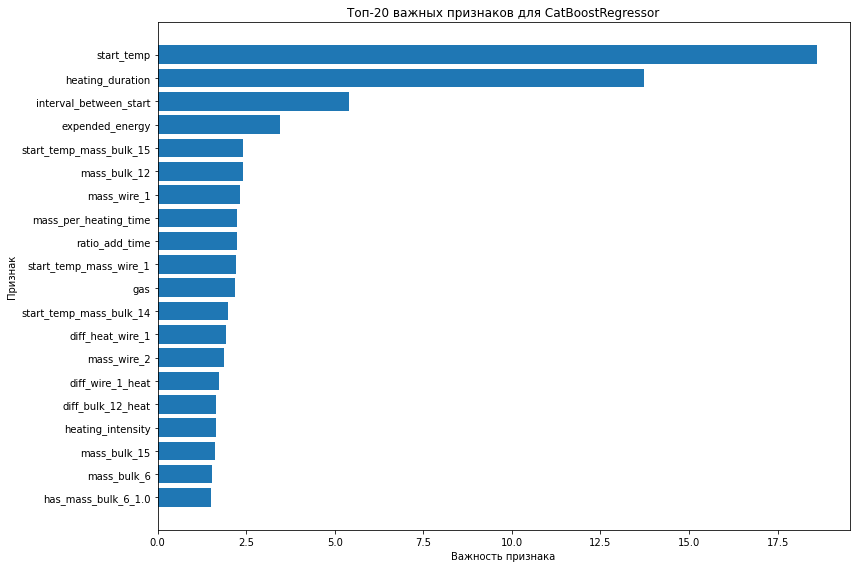

Топ-10 важных признаков:
                     feature  importance
37                start_temp   18.602739
53          heating_duration   13.718355
41    interval_between_start    5.405965
62           expended_energy    3.467943
50   start_temp_mass_bulk_15    2.424480
69              mass_bulk_12    2.422153
106              mass_wire_1    2.329071
31     mass_per_heating_time    2.246723
42            ratio_add_time    2.243602
56    start_temp_mass_wire_1    2.203712


In [ ]:
best_model = grid_search.best_estimator_
model = best_model.named_steps['models']

preprocessor = best_model.named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

ohe_feature_names = []
if len(ohe_columns) > 0:
    ohe_transformer = preprocessor.named_transformers_['ohe'].named_steps['ohe']
    ohe_feature_names = ohe_transformer.get_feature_names_out(ohe_columns).tolist()

num_feature_names = num_columns

feature_names = ohe_feature_names + num_feature_names

feature_importances = None

if hasattr(model, 'feature_importances_'):
    # Для деревьев и бустингов
    feature_importances = model.feature_importances_
elif hasattr(model, 'coef_'):
    # Для линейных моделей
    feature_importances = np.abs(model.coef_)

if feature_importances is not None:
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importances
    })

    importance_df = importance_df.sort_values('importance', ascending=False)

    top_n = min(20, len(importance_df))
    top_importance_df = importance_df.head(top_n)

    plt.figure(figsize=(12, 8))
    plt.barh(top_importance_df['feature'], top_importance_df['importance'])
    plt.xlabel('Важность признака')
    plt.ylabel('Признак')
    plt.title(f'Топ-{top_n} важных признаков для {type(model).__name__}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Топ-10 важных признаков:")
    print(importance_df.head(10))
else:
    print("Для данной модели не удалось извлечь важность признаков")

Наиболее важный признак оказался начальная температура. Построим график зависимости.

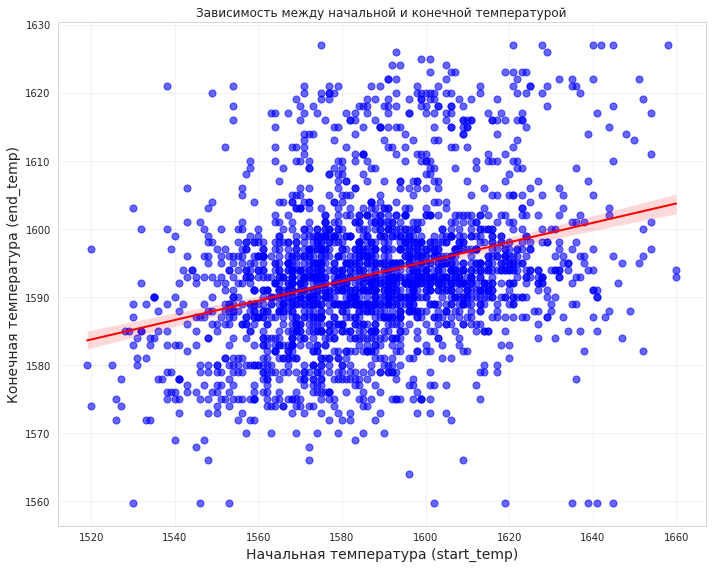

In [ ]:
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Создание scatter plot с добавлением линии регрессии
scatter = sns.regplot(
    x='start_temp',
    y='end_temp',
    data=filtered_df,
    scatter_kws={'alpha': 0.6, 's': 50, 'color': 'blue'},
    line_kws={'color': 'red', 'linewidth': 2}
)

# Вычисление коэффициента корреляции Пирсона
correlation = filtered_df['start_temp'].corr(filtered_df['end_temp'])

plt.title(f'Зависимость между начальной и конечной температурой')
plt.xlabel('Начальная температура (start_temp)', fontsize=14)
plt.ylabel('Конечная температура (end_temp)', fontsize=14)

plt.grid(True, alpha=0.3)
plt.tight_layout()

# Отображение графика
plt.show()

Несмотря на достаточно большой разброс, в целом есть некоторая зависимость.

## Выводы

**В рамках работы выполнено:**  
1. Загружены данные из базы данных.
2. Сделан анализ данных.
3. Обработаны аномальные значения.
4. Добавлены новые признаки.
5. Составлены и обучены несколько моделей, включая нейросеть.
6. Проанализирована работа лучшей модели.

**Результаты работы**  
1. Наилучше моделью после перебора является CatBoost с метрикой MAE 5.65. Нейросеть показала результат хуже, около 7,9.
2. Наиболее важный признак для модели - стартовая температура.
3. Также для модели важными оказались продолжительность нагрева, интервал между нагревами, затраченная энергия. Данные признаки вполне объяснимы с точки зрения физики процесса.

**Предложения по улучшению прогноза**
1. Предоставить характеристики сыпучего материала, а именно энтальпии плавления, теплоемкости и теплопроводности.
2. Предоставить площадь "зеркала" ковша.
3. Предоставить количество нагревателей в ковше и их относительное месторасположение.
Данные параметры позволят уточнить расчет с применением физико-химических расчетов.